# **Defending the Edge: Quality of Block Index**
proposing a mathematical basis for analysing and rating quality of play of Offensive Tackles against the Edge. Additional analysis is conveyed in relating the quality of play in the NFL to results from the NFL Combine. 

QBI is one of three proposed measures to gauge OT play against the Edge. 1. QBI, 2. Blocking Cohesion, 3. Time on Block. An overall score is generated for each OT based on these three measures. Herein is presented the algorithm for calculating QBI, Blocking Cohesion and Time on Block. These are combined into the QBI Metric, and the Block Metric which takes Cohesion and Time to generate a score which is added to the QBI to give an overall score. 

QBI + BM = Score

Data was aggregated by the <a href="https://colab.research.google.com/drive/1nPgD7U6zJIHLGlonTdbDhq3ApHCcMFCM?usp=sharing">OT_Defending_The_Edge_Metric_Aggregation.ipynb</a> notebook file


to plot plays, use defending-the-edge-plots.ipynb


In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from functools import partial
from matplotlib.animation import writers
import os



#%matplotlib inline

In [ ]:
# Import from GoogleDrive

from google.colab import drive
drive.mount('/content/gdrive')
os.chdir("//content/gdrive/MyDrive/nfl-big-data-bowl-2023/")

data_dir = "/content/gdrive/My Drive/nfl-big-data-bowl-2023/"
save_dir = "/content/gdrive/My Drive/nfl-big-data-bowl-2023/charts/"
lines_plots_dir = "/content/gdrive/My Drive/nfl-big-data-bowl-2023/lines_plots/"
#if on kaggle
#data_dir = "/kaggle/input/nfl-big-data-bowl-2023/"

'''
data_dir = "../input/metrics-databowl-v2/original_databowl.db"
OUTPUT_DIR = './'
'''

Mounted at /content/gdrive


'\ndata_dir = "../input/metrics-databowl-v2/original_databowl.db"\nOUTPUT_DIR = \'./\'\n'

In [ ]:
import sqlite3

# Create a SQL connection to a local SQLite database
#con = sqlite3.connect(data_dir + "original_databowl.db")
#con = sqlite3.connect(data_dir + "35_databowl.db")
#con = sqlite3.connect(data_dir + "40_databowl.db")
#con = sqlite3.connect(data_dir + "45_databowl.db")
#con = sqlite3.connect(data_dir + "full_databowl.db")



In [ ]:
!ls
!ls lines_plots
#!rm lines_plots/*

 charts				  play_predictor_3.csv
 combines.csv			  play_predictor_4.csv
'Copy of original_databowl.db'	  play_predictor_5.csv
 databowl_additional_tables.sql   play_predictor_6.csv
 databowl.db			  play_predictor_7.csv
 games.csv			  play_predictor_8.csv
 lines_metrics.sql		  play_predictor_data.csv
 lines_plots			  plays.csv
 models				  unwritable_databowl.db
 my_filengs_2016_passing.csv	  week1.csv
 ngs_2016_passing.csv.gz	  week2.csv
 ngs-data-main			  week3.csv
 old_databowl.db		  week4.csv
 original_databowl.db		  week5.csv
 pffScoutingData.csv		  week6.csv
 players.csv			  week7.csv
 play_predictor_1.csv		  week8.csv
 play_predictor_2.csv		  xgbcl_model.pkl


# **Measuring Euclidean Distance**

the Euclidean distance between two points in Euclidean space is the length of a line segment between the two points.

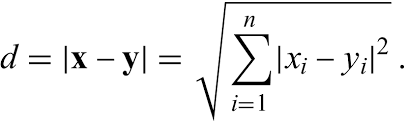



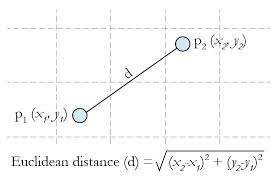

I use the euclidean distance between QB and OT, and for QB and DE as a metric for pressure on the Quarterback and for other metrics, for instance 'time on block' of OT on DE, measuring the (d) over a time series. Block Cohesion also ustilized Euclidean distance (d). 

In [ ]:
TIME_CONSTANT = 40 #defines the length of time to analyze a play 1 sec = 10

In [ ]:
def get_distance(p, q):
    """ 
    Return euclidean distance between points p and q
    assuming both to have the same number of dimensions
    p is a tuple of x,y coords ie Offensive Tackle (OT)
    q is a tuple of x,y coords ie Defensive End (DE)

    function called by metric_euclidean(offense_tracking, defender_tracking) see below
    """
    # sum of squared difference between coordinates
    s_sq_difference = 0
    for p_i,q_i in zip(p,q):
        s_sq_difference += (p_i - q_i)**2
    
    # take sq root of sum of squared difference
    distance = s_sq_difference**0.5
    return distance

# check the function
OT = (2, 3)
DE = (5, 7)
# distance b/w a and b
d = get_distance(OT, DE)
# display the result
print(d)

#https://docs.scipy.org/doc/scipy/reference/spatial.distance.html
from scipy.spatial import distance
res = distance.euclidean(OT, DE)
print(res)

5.0
5.0


# **Basic Metrics Functions**

In [ ]:
def combine_to_active_roster():
    #gets a list of OT in players table that match a row in combine table 
    sql = """
           select * from players as p, combine as c where p.officialPosition = 'T' and c.Name = p.displayName
    """
    #print(sql)  
    query = pd.read_sql_query(sql, con)
    #print(query)
    return query

OT_in_league = combine_to_active_roster()
#print(OT_in_league)



def blocker_metrics(nfl_id):
    sql = """
           select * from pffScoutingData as pff WHERE pff.nflId = """ + str(nfl_id) + """ 
    """  
    query = pd.read_sql_query(sql, con)
    return query

def plays_to_events(nfl_id, event):
    #nfl_id is the nflId of the blocker, here Offensive Tackle (OT)
    #event is the metric: pff_beatenByDefender, pff_hitAllowed, pff_hurryAllowed, pff_sackAllowed =1, 'none' is where all = 0
    event_plays = [] # a list for plays for given event
    
    if event == 'pff_beatenByDefender':
        sql = """
              select * from pffScoutingData as pff WHERE pff.nflId = """ + str(nfl_id) + """
              AND pff.pff_beatenByDefender = 1  
        """  
        beatenByDefender_query = pd.read_sql_query(sql, con)
        for i,r in beatenByDefender_query.iterrows():
          game_plays = str(r['gameId']) + "," + str(r['playId']) + "," + str(r['pff_nflIdBlockedPlayer'])
          event_plays.append(game_plays)


    if event == 'pff_hitAllowed':
        sql = """
              select * from pffScoutingData as pff WHERE pff.nflId = """ + str(nfl_id) + """ 
              AND pff.pff_hitAllowed = 1 
        """  
        hitAllowed_query = pd.read_sql_query(sql, con)
        for i,r in hitAllowed_query.iterrows():
          game_plays = str(r['gameId']) + "," + str(r['playId']) + "," + str(r['pff_nflIdBlockedPlayer'])
          event_plays.append(game_plays)

    if event == 'pff_hurryAllowed':
        sql = """
              select * from pffScoutingData as pff WHERE pff.nflId = """ + str(nfl_id) + """ 
              AND pff.pff_hurryAllowed = 1 
        """  
        hurryAllowed_query = pd.read_sql_query(sql, con)
        for i,r in hurryAllowed_query.iterrows():
          game_plays = str(r['gameId']) + "," + str(r['playId']) + "," + str(r['pff_nflIdBlockedPlayer'])
          event_plays.append(game_plays)

    if event == 'pff_sackAllowed':
        sql = """
              select * from pffScoutingData as pff WHERE pff.nflId = """ + str(nfl_id) + """ 
              AND pff.pff_sackAllowed = 1 
        """  
        #print(sql)
        sackAllowed_query = pd.read_sql_query(sql, con)
        for i,r in sackAllowed_query.iterrows():
          game_plays = str(r['gameId']) + "," + str(r['playId']) + "," + str(r['pff_nflIdBlockedPlayer'])
          event_plays.append(game_plays)
        
    if event == 'none':
        sql = """
              select * from pffScoutingData as pff WHERE pff.nflId = """ + str(nfl_id) + """ 
              AND pff.pff_hitAllowed = 0 
              AND pff.pff_hurryAllowed = 0 
              AND pff.pff_sackAllowed = 0 
              AND pff.pff_beatenByDefender = 0 
        """  
        none_query = pd.read_sql_query(sql, con)
        for i,r in none_query.iterrows():
          game_plays = str(r['gameId']) + "," + str(r['playId']) + "," + str(r['pff_nflIdBlockedPlayer'])
          event_plays.append(game_plays)

    return event_plays




def listToString(s):
   
    # initialize an empty string
    str1 = " "
   
    # return string 
    return (str1.join(s))


def player_tracking_clipped(nfl_id, game_id, play_id):

    sql = """
           select * from weeks as wk WHERE wk.nflId = """ + str(nfl_id) + """ 
           AND  wk.gameId = """ + str(game_id) + """ 
           AND  wk.playId = """ + str(play_id) + """ 
    """  
    query = pd.read_sql_query(sql, con)
    #print(sql)
    #print(query)
    return query


def combine_results(nfl_id):
    name_sql = """
           select p.displayName from players as p WHERE p.nflId = """ + str(nfl_id) + """ 
            
    """  
    name = pd.read_sql_query(name_sql, con)
    name = name.values.tolist()
    for n in name:
      player_name = n
      player_name = listToString(player_name)
      player_name = player_name.replace("'", " " )

    sql = """
           select * from combine as c WHERE c.Name = '""" + str(player_name) + """' 
            
    """  
    query = pd.read_sql_query(sql, con)
    #print(sql)
    #print(query)
    return query

def player_role(nfl_id):

    sql = """
           select pff_positionLinedUp from pffScoutingData as pff WHERE pff.nflId = """ + str(nfl_id) + """ 
    """  
    query = pd.read_sql_query(sql, con)
    #print(sql)
    #print(query)
    return query

def metric_euclidean(offense_tracking, defender_tracking):
    #reference 1 variables, usually offensive player    
    x_y_coords = offense_tracking[['x', 'y']]
    records = x_y_coords.to_records(index=False)
    result = list(records)
    x_y_coords_list = result
    reference1_id = offense_tracking.iloc[0]['nflId']
    game_id = offense_tracking.iloc[0]['gameId']
    play_id = offense_tracking.iloc[0]['playId']
    ref1_role = player_role(reference1_id) #make a lookup of pff_position
    ref1_role = ref1_role.iloc[0]['pff_positionLinedUp']
    ref1_acceleration = offense_tracking['a'].max() 
    ref1_yards = offense_tracking['dis'].sum()
    ref1_avg_speed = offense_tracking['s'].mean() #avg(s), alter table ref1 speed, ref2 seed
    play_length = len(offense_tracking) * .1 #sum of frames



    #reference 2 variables, usually defender
    x_y_coords_defender = defender_tracking[['x', 'y']]
    defender_records = x_y_coords_defender.to_records(index=False)
    defender_result = list(defender_records)
    defender_x_y_coords_list = defender_result
    reference2_id = defender_tracking.iloc[0]['nflId']
    ref2_role = player_role(reference2_id) #make a lookup of pff_position
    ref2_role = ref2_role.iloc[0]['pff_positionLinedUp']
    ref2_acceleration = defender_tracking['a'].max() 
    ref2_yards = defender_tracking['dis'].sum() #sum(dis), alter table ref1 yards, ref2 yards
    ref2_avg_speed = defender_tracking['s'].mean() #avg(s), alter table ref1 speed, ref2 seed



    for c,k in enumerate(defender_x_y_coords_list):
      reference1_x = x_y_coords_list[c][0]
      reference1_y = x_y_coords_list[c][1]
      ref1_tuple = x_y_coords_list[c]
      reference2_x = defender_x_y_coords_list[c][0]
      reference2_y = defender_x_y_coords_list[c][1]
      ref2_tuple = defender_x_y_coords_list[c]
      euclidian_distance = get_distance(ref1_tuple, ref2_tuple)
    
      # Create a new record
      cursor = con.cursor()
      sql = "INSERT INTO `frame_metrics` (`reference1_id`, `reference2_Id`, `reference1_x`, `reference1_y`, `gameId`, `playId`, `ref1_role`, `ref2_role`, `reference2_x`, `reference2_y`, `euclidean`, `ref1_acceleration`, `ref2_acceleration`, `ref1_yards`, `ref2_yards`, `ref1_avg_speed`, `ref2_avg_speed`, `play_length`) VALUES (" + str(reference1_id) + ", " + str(reference2_id) + ", " + str(reference1_x) +", " + str(reference1_y) + ", " + str(game_id) + ", " + str(play_id) + ", '" + ref1_role + "', '" + ref2_role + "', " + str(reference2_x) + ", " + str(reference2_y) + ", " + str(euclidian_distance) + ", " + str(ref1_acceleration) + "," + str(ref2_acceleration) + ", " + str(ref1_yards) + "," + str(ref2_yards) + ", " + str(ref1_avg_speed) + ", " + str(ref2_avg_speed) + "," + str(play_length) + ")"         
      print(sql)
      # Execute the query
      cursor.execute(sql)
      # the connection is not autocommited by default. So we must commit to save our changes.
      con.commit()
                
def convert_yds_to_mph(seconds, distance):    
    d_ft = distance * 3
    d_inches = d_ft * 12
    d_yards = d_ft / 3.0
    d_miles = d_ft / 5280.0
    miles = print("Input distance in miles ", d_miles)

    hours=float(seconds)/3600
    mph = float(d_miles)/seconds*3600
    return(mph)

def get_nflids_OT(): 
    sql = """
           select DISTINCT(wk.nflId) from pffScoutingData as pff, weeks as wk where pff.pff_positionLinedUp IN ('LT', 'RT') 
AND pff.nflId = wk.nflId  
    """ 
    query = pd.read_sql_query(sql, con)
    #print(query)
    return query


def get_clipped_nflids_OT(): 
    sql = """
           select DISTINCT(wk.nflId) from frames_metrics where fm.ref1_role IN ('LT', 'RT')   
    """ 
    query = pd.read_sql_query(sql, con)
    #print(query)
    return query



def get_metric_nflids(): 
    sql = """
           select DISTINCT(reference1_id) from frame_metrics where ref1_role IN ('LT', 'RT') 
    """ 
    query = pd.read_sql_query(sql, con)
    #print(query)
    return query



################## END Function Definitions ####################################

# **Basic Metrics from PffScoutingData**


4 Base Metrics: beatenByDefender, hitAllowed, hurryAllowed, sackAllowed as maintained in the PFF table PffScoutingData. 

In [ ]:
#how much weight to put on each of the different metric events, sack is more damaging then hurry, etc. 
clipped_nflids = get_nflids_OT()

nfl_ids = clipped_nflids[['nflId']]
print(nfl_ids)

for c,r in nfl_ids.iterrows():
  player_id = r['nflId']
  player_metric = blocker_metrics(player_id)
  if(len(player_metric) >= 1):
    #get total (sum) of 4 metrics tracked by pff for OL in pffScoutingData table
    beaten_by_defender = player_metric['pff_beatenByDefender'].sum()
    hit_allowed = player_metric['pff_hitAllowed'].sum()
    hurry_allowed = player_metric['pff_hurryAllowed'].sum()
    sack_allowed = player_metric['pff_sackAllowed'].sum()
    #get [gameId, playId, pff_nflIdBlockedPlayer] returned in a list for each metric event
    beaten_plays = plays_to_events(player_id, 'pff_beatenByDefender')
    hit_plays = plays_to_events(player_id, 'pff_hitAllowed')
    hurry_plays = plays_to_events(player_id, 'pff_hurryAllowed')
    sack_plays = plays_to_events(player_id, 'pff_sackAllowed')
    combine_performance = combine_results(player_id)
    #display metrics for each player
    print()
    print("-------------------------------------------------------")
    print(c)
    print("Player Metrics: ", r['nflId'])
    print("Combine Performance: ", combine_performance)
    print()
    print("Total Plays: ", len(player_metric))
    print("Fouls Committed: ")
    print("beaten by defender: ", beaten_by_defender, beaten_plays)
    print("hit allowed: ", hit_allowed, hit_plays)
    print("hurry allowed: ", hurry_allowed, hurry_plays)
    print("sack allowed: ", sack_allowed, sack_plays)

    print()


#TODO: add accounting for penalties, penalty yards, etc. is there a model for holding

       nflId
0    42377.0
1    52421.0
2    37082.0
3    42654.0
4    41232.0
..       ...
119  48158.0
120  39983.0
121  44970.0
122  53868.0
123  52516.0

[124 rows x 1 columns]

-------------------------------------------------------
0
Player Metrics:  42377.0
Combine Performance:              Name Pos      School        College   Ht     Wt  40yd  Vertical  \
0  Donovan Smith  OT  Penn State  College Stats  6-6  338.0  5.27      32.0   

   Bench  Broad Jump  3Cone  Shuttle  \
0   26.0       109.0   7.95     4.79   

                             Drafted (tm/rnd/yr) Player-additional  
0  Tampa Bay Buccaneers / 2nd / 34th pick / 2015          SmitDo02  

Total Plays:  306
Fouls Committed: 
beaten by defender:  12.0 ['2021090900,559,42403.0', '2021091910,1025,42480.0', '2021091910,1754,53611.0', '2021091910,2313,42346.0', '2021091910,2359,42346.0', '2021091910,3564,42346.0', '2021100313,2135,43435.0', '2021100313,2401,43435.0', '2021101007,1914,46307.0', '2021101400,3823,44826.0', '20

# **Modeling of Edge Blocking**

Modeling is composed of:


1.   Quality of Block Index
2.   Gain/Loss of Momentum of Rusher against Blocker
3.   Block Metrics: Measures Interface of Blocker/Defender
4.   Straight Line Deterrence: Blocker's ability to keep Defender from a straight line trajectory toward the QB





## **frame_metrics table:**
has two references divided up into 3 aspects: ot-to-de, qb-to-ot, qb-to-de, holds euclidean measurements and x,y of blocker, defender and QB

**ot-to-de** is used to measure quality of block index which is to say the amount of control over the Defensive End by the Offensive Tackle

**qb-to-ot** is used to measure how far the OT remains from the QB

**qb-to-de** is used to measure how far the DE remains from the QB and whether he enters the buffer zone around the quarter back 1.5 yds, then there is the reach zone which is <1.0 yds around the QB, and of course the death zone which is <.7 yds from the QB. 

All measured by Euclidean distance. 

# **QBI Rating for Each Play**

Is an index that keeps a score from 0-3.  Penalty points are given when the OT gets beaten, it is less if the OT regains control of the defender after being beaten.  Penalty points are give (.5pts) if the Blocker or Defender enters: 1. the Buffer Zone around QB 1.5yds; the Danger Zone around QB 1.0yds or the Sack Zone, even if not sacked by Defender, <.7 yds from QB, the theoretical reach of any given Defense Rusher. QBI is stored in qbi_metrics table in db. 

**Functions for QBI and general metrics functions**

In [ ]:
def game_frames(reference1_id, reference2_id, game_id, play_id):

    sql = """
           select * from frame_metrics as fm WHERE fm.reference1_id = """ + str(reference1_id) + """ 
           AND  fm.reference2_id = """ + str(reference2_id) + """ 
           AND  fm.gameId = """ + str(game_id) + """ 
           AND  fm.playId = """ + str(play_id) + """ 
    """  
    query = pd.read_sql_query(sql, con)
    return query

def ids_for_frames(game_id, play_id):

    sql = """
           select DISTINCT reference1_id, reference2_id, ref1_role, ref2_role from frame_metrics as fm WHERE fm.gameId = """ + str(game_id) + """ 
           AND  fm.playId = """ + str(play_id) + """ 
    """  
    query = pd.read_sql_query(sql, con)
    return query




def add_data_to_metrics(blocker_id, defender_id, game_id, play_id, buffer, dangerarea, sackarea, def_buffer, def_dangerarea, def_sackarea, beaten, regained, rating):
    #print(write_buffer)

    cursor = con.cursor()
    sql = "INSERT INTO `qbi_metrics` (`blocker_id`, `defender_id`, `gameId`, `playId`, `qbi_rating`, `beaten`, `regained`, `block_buffer`, `block_dangerarea`, `block_sackarea`, `rush_buffer`, `rush_dangerarea`, `rush_sackarea` ) VALUES (" + str(blocker_id) + "," + str(defender_id) + "," + str(game_id) + "," + str(play_id) + "," + str(rating) + ", " + str(beaten) + ","  + str(regained) + ", " + str(buffer) + ", " + str(dangerarea) + "," + str(sackarea) + "," + str(def_buffer) + "," + str(def_dangerarea) + "," + str(def_sackarea) + ")"
    print(sql)   
    # Execute the query
    cursor.execute(sql)
    # the connection is not autocommited by default. So we must commit to save our changes.
    con.commit()
    


def rate_play(play_dataframe, blocker_id, defender_id, game_id, play_id):
    penalty = False
    rating = 3
    play_length_unclipped = len(play_dataframe)
    pos = 0
    beaten = False
    regained = False
    penalty_value = 0
    buffer_penalty = False
    def_buffer_penalty = False
    buffer_penalty_value = 0
    def_buffer_penalty_value = 0
    dangerarea_penalty = False
    def_dangerarea_penalty = False
    dangerarea_penalty_value = 0
    def_dangerarea_penalty_value = 0
    sackarea_penalty = False
    def_sackarea_penalty = False
    sackarea_penalty_value = 0
    def_sackarea_penalty_value = 0
    play_dataframe = play_dataframe[5:play_length_unclipped-5]
    play_length = len(play_dataframe)
    
    
    if play_length >= 35:
        play_length = 35 #maximum play length is 3.5 sec, 35 frames
    else:
        play_length = play_length
    
    #print("play length original/clipped: ", play_length_unclipped, play_length)
    for c,i in play_dataframe.iterrows():
        if c > 39:
            break
            
        block_distance = i['block_euclidean']
        qb_blocker_distance = i['qb_blocker_euclidean']
        qb_rusher_distance = i['qb_rusher_euclidean']
        
        #print("row: ", c, qb_blocker_distance, qb_rusher_distance)
        
        rusher_min = qb_rusher_distance
        blocker_min = qb_blocker_distance
        
         
        #  beat by a difference of .01 in euclidean distance is around .33 inches
        #  beat by a difference of .1 in euclidean distance is around 3.6 incehs
        if(qb_rusher_distance < qb_blocker_distance):
            beaten = True
            regained = False
            pos = c
            #print("beaten")
        
        if(qb_rusher_distance > qb_blocker_distance and beaten == True):
            regained = True
            #print("regained control")
         
            
        if rusher_min < 1.5:
            #print("def in buffer zone, subtracting points")
            if def_buffer_penalty == False:
                def_buffer_penalty_value = def_buffer_penalty_value + .5
            def_buffer_penalty = True
            
        if rusher_min < 1.0:
            #print("def in danger area, subtracint points")
            if def_dangerarea_penalty == False:
                def_dangerarea_penalty_value = def_dangerarea_penalty_value + .5
            def_dangerarea_penalty = True
            
        if rusher_min < .7:
            #print("def in sack zone, block zeroed out")
            if def_sackarea_penalty == False:
                def_sackarea_penalty_value = def_sackarea_penalty_value + 3
            def_sackarea_penalty = True
            
    
        if blocker_min < 1.5:
            #print("blocker in buffer zone")
            if buffer_penalty == False:
                buffer_penalty_value = buffer_penalty_value + .5
            buffer_penalty = True
            
        if blocker_min < 1.0:
            #print("blocker in dangerarea")
            if dangerarea_penalty == False:
                dangerarea_penalty_value = dangerarea_penalty_value + .5
            dangerarea_penalty = True
            
    
        if blocker_min < .7:
            #print("blocker in sack/reach zone")
            if sackarea_penalty == False:
                sackarea_penalty_value = sackarea_penalty_value + 3
            sackarea_penalty = True
            
        
        
    if(beaten == True and regained == True):        
        #print("heuristic penalty triggered")
        penalty = True
        penalty_value = .25
    
    if(beaten == True and regained == False):
        penalty = True
        penalty_value = .50
        
    
    #rating = rating - penalty_value
    rating = rating - penalty_value - buffer_penalty_value - dangerarea_penalty_value - sackarea_penalty_value - def_buffer_penalty_value - def_dangerarea_penalty_value - def_sackarea_penalty_value
    
    if rating < 0:
        rating = 0
    
    #add_data_to_metrics() stuff here    
    if buffer_penalty == True:
        write_buffer = 1
    else:
        write_buffer = 0
    
    if dangerarea_penalty == True:
        write_dangerarea = 1
    else:
        write_dangerarea = 0
    
    if sackarea_penalty == True:
        write_sackarea = 1
    else: 
        write_sackarea = 0
    
    if def_buffer_penalty == True:
        def_write_buffer = 1
    else:
        def_write_buffer = 0
    
    if def_dangerarea_penalty == True:
        def_write_dangerarea = 1
    else:
        def_write_dangerarea = 0
    
    if def_sackarea_penalty == True:
        def_write_sackarea = 1
    else: 
        def_write_sackarea = 0
    
    if beaten == True:
        write_beaten = 1
    else:
        write_beaten = 0
    
    if regained == True:
        write_regained = 1
    else: 
        write_regained = 0
    
    add_data_to_metrics(blocker_id, defender_id, game_id, play_id, write_buffer, write_dangerarea, write_sackarea, def_write_buffer, def_write_dangerarea, def_write_sackarea, write_beaten, write_regained, rating)
    
    
    return rating



def plays_for_player(nfl_id):

    sql = """
           select DISTINCT gameId, playId from frame_metrics as fm WHERE fm.reference1_id = """ + str(nfl_id) + """ 
    
    """  
    query = pd.read_sql_query(sql, con)
    return query

def passer_for_play(nfl_id, game_id, play_id):

    sql = """
           select DISTINCT reference1_id from frame_metrics as fm WHERE fm.reference2_id = """ + str(nfl_id) + """ 
           AND fm.playId = """ + str(play_id) + """  
           AND fm.gameId = """ + str(game_id) + """
    """  
    query = pd.read_sql_query(sql, con)
    return query

def defender_for_play(nfl_id, game_id, play_id):

    sql = """
           select DISTINCT reference2_id from frame_metrics as fm WHERE fm.reference1_id = """ + str(nfl_id) + """ 
           AND fm.playId = """ + str(play_id) + """  
           AND fm.gameId = """ + str(game_id) + """
    """  
    query = pd.read_sql_query(sql, con)
    return query

def add_data_to_block_metrics(blocker_id, defender_id, game_id, play_id, arm_score, arm_cnt, control_score, control_cnt, interface_score, interface_cnt, total_frames, euclideans, efficiency, momentum_rating, distances_list, qb_de_eucl_avg, qb_de_rating):
    cursor = con.cursor()
    sql = "INSERT INTO `block_metrics` (`blocker_id`, `defender_id`, `gameId`, `playId`, `arm_score`, `arm_cnt`, `control_score`, `control_cnt`, `interface_score`, `interface_cnt`, `total_frames`, `euclideans`, `efficiency`, `momentum_rating`, `distances_list`, `qb_de_eucl_avg`, `qb_de_rating` ) VALUES (" + str(blocker_id) + "," + str(defender_id) + "," + str(game_id) + "," + str(play_id) + "," + str(arm_score) + ", " + str(arm_cnt) + ","  + str(control_score) + ", " + str(control_cnt) + ", " + str(interface_score) + "," + str(interface_cnt) + "," + str(total_frames) + ",'" + str(euclideans) + "', " + str(efficiency) + ", " + str(momentum_rating) + ", '" + str(distances_list) + "', "+str(qb_de_eucl_avg)+", "+str(qb_de_rating)+")"
    print(sql)   
    # Execute the query
    cursor.execute(sql)
    # the connection is not autocommited by default. So we must commit to save our changes.
    con.commit()

def nflids_of_tackles():
    #select DISTINCT(reference1_id) from frame_metrics where ref1_role IN ('RT', 'LT')    
    sql = """
           select DISTINCT(reference1_id) from frame_metrics where ref1_role IN ('RT', 'LT')
    """  
    query = pd.read_sql_query(sql, con)
    return query

# **QBI Aggregation and Write to SQLite DB Metric Table**

In [ ]:


def aggregate_qbi(nfl_id):
  tackle_plays = plays_for_player(nfl_id)
  df_length = len(tackle_plays) - 1
  for c,t in tackle_plays.iterrows():
      #print(c)
      if c > df_length:
          break
      
      game_id = t['gameId']
      play_id = t['playId']
      #get passer id
      passer_id = passer_for_play(nfl_id, game_id, play_id)
      passer_id = passer_id['reference1_id'][0]
      #get defender id
      defender_id = defender_for_play(nfl_id, game_id, play_id)
      defender_id = defender_id['reference2_id'][0]
      #get euclidean dataframes
      player_tracking_for_play = game_frames(nfl_id, defender_id, game_id, play_id)
      qb_tracking_offense = game_frames(passer_id, nfl_id, game_id, play_id)
      qb_tracking_defense = game_frames(passer_id, defender_id, game_id, play_id)

      df_len = len(player_tracking_for_play)
      #quality check proper frame length
      if df_len > TIME_CONSTANT + 10:
        df_len = TIME_CONSTANT + 10
      df_limit = df_len - 5 #this just clips the first 5 and last 5 but does not limit play to 3.5s or 35frames, need to limit to 35 frames
      #[5:df_limit]
      block_metrics = player_tracking_for_play[['ref1_role', 'ref2_role', 'euclidean']]
      qb_metrics_offense = qb_tracking_offense[['ref1_role', 'ref2_role', 'euclidean']]
      qb_metrics_defense = qb_tracking_defense[['ref1_role', 'ref2_role', 'euclidean']]
      #print(len(block_metrics), len(qb_metrics_offense), len(qb_metrics_defense))
      block_metrics.rename(columns = {'ref1_role':'Blocker', 'ref2_role':'Rusher', 'euclidean':'block_euclidean'}, inplace = True)
      qb_metrics_offense.rename(columns = {'ref1_role':'QB_offense', 'ref2_role':'QB_Blocker', 'euclidean':'qb_blocker_euclidean'}, inplace = True)
      qb_metrics_defense.rename(columns = {'ref1_role':'QB_defense', 'ref2_role':'QB_Rusher', 'euclidean':'qb_rusher_euclidean'}, inplace = True)
      block_metrics = block_metrics[5:df_len-5]
      qb_metrics_offense = qb_metrics_offense[5:df_len-5]
      qb_metrics_defense = qb_metrics_defense[5:df_len-5]
      #print(len(block_metrics), len(qb_metrics_offense), len(qb_metrics_defense))
      metrics_concat = pd.concat([block_metrics, qb_metrics_offense, qb_metrics_defense], axis=1)
      rating_data = metrics_concat[['block_euclidean', 'qb_blocker_euclidean', 'qb_rusher_euclidean']]

      play = rating_data
      play_rating = rate_play(play, nfl_id, defender_id, game_id, play_id)

#uncomment to aggregate qbi data and write to qbi_metrics db table




# **QBI Aggregate Driver**

In [ ]:

#after 41222 error

nfl_ids = [35443, 41475, 45630, 39947, 41296, 48181, 41237, 44844, 44832]

for c,r in enumerate(nfl_ids):

  nfl_id = r
  aggregate_qbi(nfl_id)

'''

clipped_nflids = nflids_of_tackles()
nfl_ids = clipped_nflids[['reference1_id']]

for c,r in nfl_ids.iterrows():
  nfl_id = r['reference1_id']
  aggregate_qbi(nfl_id)
  
'''


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


INSERT INTO `qbi_metrics` (`blocker_id`, `defender_id`, `gameId`, `playId`, `qbi_rating`, `beaten`, `regained`, `block_buffer`, `block_dangerarea`, `block_sackarea`, `rush_buffer`, `rush_dangerarea`, `rush_sackarea` ) VALUES (35443,42444,2021091204,417,3, 0,0, 0, 0,0,0,0,0)
INSERT INTO `qbi_metrics` (`blocker_id`, `defender_id`, `gameId`, `playId`, `qbi_rating`, `beaten`, `regained`, `block_buffer`, `block_dangerarea`, `block_sackarea`, `rush_buffer`, `rush_dangerarea`, `rush_sackarea` ) VALUES (35443,42444,2021091204,487,3, 0,0, 0, 0,0,0,0,0)
INSERT INTO `qbi_metrics` (`blocker_id`, `defender_id`, `gameId`, `playId`, `qbi_rating`, `beaten`, `regained`, `block_buffer`, `block_dangerarea`, `block_sackarea`, `rush_buffer`, `rush_dangerarea`, `rush_sackarea` ) VALUES (35443,42444,2021091204,516,3, 0,0, 0, 0,0,0,0,0)
INSERT INTO `qbi_metrics` (`blocker_id`, `defender_id`, `gameId`, `playId`, `qbi_rating`, `beaten`, `regained`, `block_buffer`, `block_dangerarea`, `block_sackarea`, `rush_buf

"\n\nclipped_nflids = nflids_of_tackles()\nnfl_ids = clipped_nflids[['reference1_id']]\n\nfor c,r in nfl_ids.iterrows():\n  nfl_id = r['reference1_id']\n  aggregate_qbi(nfl_id)\n  \n"

In [ ]:

sql = "select * from qbi_metrics"
#sql = "select AVG(qm.qbi_rating), COUNT(qm.playId), p.*, qm.*FROM qbi_metrics as qm, players as p WHERE p.nflId = qm.blocker_id GROUP BY qm.blocker_id ORDER BY AVG(qm.qbi_rating) DESC"

#sql = "SELECT name FROM sqlite_schema WHERE type IN ('table','view') AND name NOT LIKE 'sqlite_%'ORDER BY 1"
query = pd.read_sql_query(sql, con)
print(len(query))
#display(query)
with pd.option_context('display.max_rows', None,):
    display(query)

0


Empty DataFrame
Columns: [blocker_id, defender_id, gameId, playId, qbi_rating, beaten, regained, block_buffer, block_dangerarea, block_sackarea, rush_buffer, rush_dangerarea, rush_sackarea]
Index: []

select AVG(qb.qbi_rating), COUNT(qb.rowid), qb.blocker_id, p.* from qbi_metrics as qb, players as p WHERE p.nflId = qb.blocker_id GROUP BY qb.blocker_id ORDER BY AVG(qb.qbi_rating) DESC


-------------------



select AVG(qbi_rating), blocker_id from qbi_metrics GROUP BY blocker_id ORDER BY AVG(qbi_rating) DESC

---------------------

initial sample is first 34 players:


qbi top:


tristan wirfs 52421, all pro1, pro bowl qbi: 2.90287, pff: 85.0

riley reiff pff: 67.3

brian o'neill pff: 73.7

rashawn slater: pff: 83.7

dion dawkins: pff: 77.5

lane johnson: pff: 82.4

kelvin beachum: pff: 63.8

D.J. Humphries pff: 67.8

Morgan Moses pff: 70.9

Jawaan Taylor pff: 60.3

Donovan Smith: pff: 83.3

George Fant: pff: 71.1

Wirfs and Slater consistently in domain experts top 5 OT, here 1 and 4

This is only for Pass protection, does not include Rush blocking which is also included in domain experts opinions and rankings. 

# **Measuring Cohesion in Blocking**

2 measures: Blocking Cohesion and Time on Block

Cohesion measures the closeness of blocker to defender a rough measure of the degree of interface between the two.

Time on Block measures the length of the block, how long the blocker is able to engage the defender to deter them from the Quarterback

In these measures anything < 1.6667, which is the combined reach of two players with a height around 6'6" standing face to face, the general starting limit of any possible physical contact

In [ ]:
#cohesion and time metrics, block_metrics functions
def distance_for_interface(nfl_id, game_id, play_id, start, end):
    
    sql = """
           SELECT frameId,dis from weeks where gameId = """ + str(game_id) + """ AND playId = """ + str(play_id) + """ AND nflId = """ + str(nfl_id) + """  
           LIMIT """+str(start)+""","""+str(end)+""" 
    """ 

    #print(sql) 
    query = pd.read_sql_query(sql, con)
    return query 

def rate_distances(distances, euclideans):
    distances_list = []
    rating = 0
    distance_end = len(distances) -1
    distance_val = distances['dis'][0]
    distance_val_end = distances['dis'][distance_end]
    slowed = []
    increased = []
    #add up frames where momentum slowed to momentum increased
    #divide slowed by total interface frames = score
    
    #print(distance_val, distance_val_end)

    for c,i in distances.iterrows():
      #print(c,i['dis'])
      distances_list.append(i['dis'])
      if c > 0:
        prev_dis = distances['dis'][c-1]
        current_dis = i['dis']
      
    
      if c > 0 and prev_dis >= current_dis:
        slowed.append(current_dis)
      else:
        increased.append(i['dis'])

    #print(len(increased))
    #print(len(slowed))
    #print(len(distances))

    rating = len(slowed) / len(distances)
    
    
    return rating, distances_list

# **Defensive Euclideans**

In [ ]:
'''
def update_defensive_euclideans(blocker_id, game_id, play_id, qb_de_eucl_avg, qb_de_rating):
  cursor = con.cursor()
  sql = "UPDATE block_metrics SET 'qb_de_eucl_avg' = "+str(qb_de_eucl_avg)+" AND 'qb_de_rating' = "+ str(qb_de_rating)+" WHERE blocker_id = "+ str(blocker_id) + " AND gameId = "+str(game_id)+" AND playId = "+str(play_id)
  #print(sql)   qb_de_eucl_avg	qb_de_rating
  #sql = "UPDATE block_metrics SET qb_de_eucl_avg=5.050740308479186 AND qb_de_rating=1 WHERE blocker_id=41475.0 AND gameId=2021091208 AND playId=377"
  sql = "UPDATE block_metrics SET qb_de_eucl_avg=5.050740308479186 AND qb_de_rating=1 WHERE blocker_id=41475"
  print(sql)
  cursor.execute(sql)
  # the connection is not autocommited by default. So we must commit to save our changes.
  con.commit() 

  sql = "select * from block_metrics where blocker_id = 41475 and playId = 377"

  query = pd.read_sql_query(sql, con)
  print(query) 

'''


def aggregate_defensive_euclideans(nfl_id, game_id, play_id):
  #get passer id
  passer_id = passer_for_play(nfl_id, game_id, play_id)
  passer_id = passer_id['reference1_id'][0]
  #get defender id
  defender_id = defender_for_play(nfl_id, game_id, play_id)
  defender_id = defender_id['reference2_id'][0]
      
  qb_defender_eucl = 0.000 
  rating = 0



  player_tracking_for_play = game_frames(nfl_id, defender_id, game_id, play_id)
  df_len = len(player_tracking_for_play)

  df_limit = df_len - 5
  if df_len > TIME_CONSTANT + 10:
    df_len = TIME_CONSTANT + 10


  block_metrics = player_tracking_for_play[['ref1_role', 'ref2_role', 'euclidean']]
  block_metrics.rename(columns = {'ref1_role':'Blocker', 'ref2_role':'Rusher', 'euclidean':'block_euclidean'}, inplace = True)
  block_metrics = block_metrics[5:df_len-5]

  #get euclidean dataframes
  qb_tracking_offense = game_frames(passer_id, nfl_id, game_id, play_id)
  qb_tracking_defense = game_frames(passer_id, defender_id, game_id, play_id)

  block_metrics = player_tracking_for_play[['ref1_role', 'ref2_role', 'euclidean']]
  qb_metrics_offense = qb_tracking_offense[['ref1_role', 'ref2_role', 'euclidean']]
  qb_metrics_defense = qb_tracking_defense[['ref1_role', 'ref2_role', 'euclidean']]

  block_metrics.rename(columns = {'ref1_role':'Blocker', 'ref2_role':'Rusher', 'euclidean':'block_euclidean'}, inplace = True)
  qb_metrics_offense.rename(columns = {'ref1_role':'QB_offense', 'ref2_role':'QB_Blocker', 'euclidean':'qb_blocker_euclidean'}, inplace = True)
  qb_metrics_defense.rename(columns = {'ref1_role':'QB_defense', 'ref2_role':'QB_Rusher', 'euclidean':'qb_rusher_euclidean'}, inplace = True)
  block_metrics = block_metrics[5:df_len-5]
  qb_metrics_offense = qb_metrics_offense[5:df_len-5]
  qb_metrics_defense = qb_metrics_defense[5:df_len-5]

  metrics_concat = pd.concat([block_metrics, qb_metrics_offense, qb_metrics_defense], axis=1)
  rating_data = metrics_concat[['block_euclidean', 'qb_blocker_euclidean', 'qb_rusher_euclidean']]

  play = rating_data

  interface_zone = play.loc[play['block_euclidean'] < 1.6667]
  interface_zone_index = interface_zone['block_euclidean'].index
  interface_start = interface_zone_index[0]
  interface_end = len(interface_zone)


  #qb_defender = play['qb_rusher_euclidean'][interface_start:interface_end]
  #qb_defender_eucl = play['qb_rusher_euclidean'][interface_start:interface_end].mean()
  qb_defender = interface_zone['qb_rusher_euclidean']
  qb_defender_eucl = interface_zone['qb_rusher_euclidean'].mean()


  
  qb_defender_cnt = len(qb_defender)

  

  if qb_defender_cnt > 4: 
      
      qb_def_len = len(qb_defender)
      
      qb_def_start = qb_def_len - qb_def_len
      qb_def_end = qb_def_len - 1
      
      start_eucl = 0
      end_eucl = 0
      for rownum,(indx,values) in enumerate(qb_defender.iteritems()):
        if qb_def_start == rownum:
          start_eucl = values

        if qb_def_end == rownum:
          end_eucl = values

        if end_eucl > start_eucl:
          rating = 1
      '''
      print("blocker id: ", nfl_id)
      print("rating: ", rating, start_eucl, end_eucl) 
      print("eucl avg: ", qb_defender_eucl)  
          #update_defensive_euclideans(nfl_id, game_id, play_id, qb_defender_eucl, rating)  

      print("-------------------")
      print()
      print()
      '''
  if qb_defender_cnt < 4:
    qb_defender_eucl = 0
    rating = 0

  return qb_defender_eucl, rating     
      
   

  

In [ ]:



def aggregate_block_metrics(nfl_id):
  tackle_plays = plays_for_player(nfl_id)
  df_length = len(tackle_plays) - 1
  print(nfl_id)
  for c,t in tackle_plays.iterrows():
      if c > df_length:
          break
      
      game_id = t['gameId']
      play_id = t['playId']
      #get defender id
      defender_id = defender_for_play(nfl_id, game_id, play_id)
      defender_id = defender_id['reference2_id'][0]
      player_tracking_for_play = game_frames(nfl_id, defender_id, game_id, play_id)
      df_len = len(player_tracking_for_play)
      df_limit = df_len - 5
      if df_len > TIME_CONSTANT + 10:
        df_len = TIME_CONSTANT + 10
      

      block_metrics = player_tracking_for_play[['ref1_role', 'ref2_role', 'euclidean']]
      block_metrics.rename(columns = {'ref1_role':'Blocker', 'ref2_role':'Rusher', 'euclidean':'block_euclidean'}, inplace = True)
      block_metrics = block_metrics[5:df_len-5]
      #print(len(block_metrics))
      interface_zone = block_metrics.loc[block_metrics['block_euclidean'] < 1.6667]
      
      interface_zone_cnt = len(interface_zone)

     
      
      if interface_zone_cnt > 4:

          interface_zone_index = interface_zone['block_euclidean'].index
          interface_start = interface_zone_index[0]
          interface_end = len(interface_zone)

          control_block = block_metrics.loc[block_metrics['block_euclidean'] < .8]
          
          distances = distance_for_interface(nfl_id, game_id, play_id, interface_start-1, interface_end)
          
          eucls = interface_zone['block_euclidean']

          momentum_rating, distances_list = rate_distances(distances, interface_zone)
          distances_list = str(distances_list)
          
          #print(momentum_rating, distances_list)

          control_cnt = len(control_block)
          eucl_avg = interface_zone['block_euclidean'].mean()
          interface_cnt = len(interface_zone)
          control_ratio = control_cnt / interface_cnt
          interface_ratio = interface_cnt / len(block_metrics)
          arm_block_cnt = interface_cnt - control_cnt
          arm_block_ratio = arm_block_cnt / interface_cnt
          #regularization_factor = 35 / interface_cnt
          arm_score = arm_block_cnt * .8
          control_score = control_cnt * 1
          final_score = arm_score + control_score 
          #final_score = final_score * regularization_factor
          final_score = arm_score + control_score #out of 28 + 35, 63 total possible points
          interface_score = final_score
          total_frames = df_len - 10
          if df_len > TIME_CONSTANT + 10:
            total_frames = TIME_CONSTANT
          #euclideans = eucls.to_string(index = True) 
          euclideans = eucls.values.tolist() 
          block_efficiency = final_score / interface_cnt
          qb_de_eucl, qb_de_rating = aggregate_defensive_euclideans(nfl_id, game_id, play_id)
      else:
        continue

      add_data_to_block_metrics(nfl_id, defender_id, game_id, play_id, arm_score, arm_block_cnt, control_score, control_cnt, interface_score, interface_cnt, total_frames, euclideans, block_efficiency, momentum_rating, distances_list, qb_de_eucl, qb_de_rating)
      blocks = interface_zone
   
    
         
    

# **Aggregate Block Metrics Driver**

In [ ]:

def rated_players():
    
    sql = """
           select blocker_id from leaderboard
    """ 

    #print(sql) 
    query = pd.read_sql_query(sql, con)
    return query 
#46152
clipped_nflids = rated_players()
#print(clipped_nflids)
nfl_ids = clipped_nflids[['blocker_id']]
print(nfl_ids)
for c,r in nfl_ids.iterrows():
     nfl_id = r['blocker_id']
     aggregate_block_metrics(nfl_id)


'''
nfl_ids = [
35443,
41475,
45630,
39947,
41296,
48181,
41237,
44844,
44832
]

for r in nfl_ids:

     nfl_id = r 
     aggregate_block_metrics(nfl_id)
     
     #print("-------------------------")
     #print()
'''

35443


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


INSERT INTO `block_metrics` (`blocker_id`, `defender_id`, `gameId`, `playId`, `arm_score`, `arm_cnt`, `control_score`, `control_cnt`, `interface_score`, `interface_cnt`, `total_frames`, `euclideans`, `efficiency`, `momentum_rating`, `distances_list`, `qb_de_eucl_avg`, `qb_de_rating` ) VALUES (35443,42444,2021091204,417,6.4, 8,0, 0, 6.4,8,26,'[1.4838463532320314, 1.3182184947875681, 1.2028299963003983, 1.1825819210524025, 1.2165936051122443, 1.2741271522104878, 1.3903237033151623, 1.5426276284314437]', 0.8, 0.875, '[0.4, 0.38, 0.37, 0.35, 0.34, 0.31, 0.29, 0.27]', 6.33615285566608, 1)
INSERT INTO `block_metrics` (`blocker_id`, `defender_id`, `gameId`, `playId`, `arm_score`, `arm_cnt`, `control_score`, `control_cnt`, `interface_score`, `interface_cnt`, `total_frames`, `euclideans`, `efficiency`, `momentum_rating`, `distances_list`, `qb_de_eucl_avg`, `qb_de_rating` ) VALUES (35443,42444,2021091204,487,4.0, 5,9, 9, 13.0,14,24,'[1.4984325143295512, 1.3118688958886118, 1.140570032922131, 0.9

In [ ]:
#sql = "select DISTINCT reference1_id, reference2_id from frame_metrics where playId = 97"
#sql = "select rowid from frame_metrics"
#sql = "select * from qbi_metrics"
sql = "select * from block_metrics"
#sql = "SELECT * FROM sqlite_master"
#sql = "SELECT name FROM sqlite_schema WHERE type IN ('table','view') AND name NOT LIKE 'sqlite_%'ORDER BY 1"
#480_2021090900, 97_2021090900, 410_2021090900, 434_2021090900, 456_2021090900, clipped_tracking
query = pd.read_sql_query(sql, con)
print(len(query))
#display(query)
with pd.option_context('display.max_rows', None,):
    display(query.tail(100))

10769


blocker_id  defender_id      gameId  playId  arm_score  arm_cnt  \
10669       44832        46135  2021091212    1199        6.4        8   
10670       44832        42349  2021091212    1239        8.0       10   
10671       44832        42349  2021091212    1260       13.6       17   
10672       44832        46135  2021091212    1437       18.4       23   
10673       44832        42349  2021091212    1499       18.4       23   
10674       44832        42349  2021091212    1540       12.8       16   
10675       44832        46135  2021091212    1564       10.4       13   
10676       44832        46135  2021091212    1593        5.6        7   
10677       44832        46135  2021091212    1810       14.4       18   
10678       44832        52518  2021091212    1855        7.2        9   
10679       44832        42349  2021091212    1877       12.8       16   
10680       44832        42355  2021091212    1901       17.6       22   
10681       44832        53876  2021091212    1944        6.4        8   
10682       44832        42349  2021091212    1989       21.6       27   
10683       44832        42349  2021091212    2008        5.6        7   
10684       44832        46135  2021091212    2129        8.0       10   
10685       44832        46135  2021091212    2151        4.8        6   
10686       44832        42355  2021091212    2532       10.4       13   
10687       44832        46135  2021091212    2554       13.6       17   
10688       44832        53876  2021091212    2630       28.0       35   
10689       44832        43332  2021091212    2703        8.8       11   
10690       44832        42349  2021091212    3181        8.8       11   
10691       44832        43333  2021091904     444        7.2        9   
10692       44832        47790  2021091904     498        4.8        6   
10693       44832        43352  2021091904     522        8.8       11   
10694       44832        46098  2021091904     594       10.4       13   
10695       44832        43787  2021091904     639        6.4        8   
10696       44832        47790  2021091904     658        5.6        7   
10697       44832        47790  2021091904     682       11.2       14   
10698       44832        52481  2021091904     846        7.2        9   
10699       44832        47790  2021091904     912        6.4        8   
10700       44832        47790  2021091904     936        5.6        7   
10701       44832        43787  2021091904    1200       18.4       23   
10702       44832        43333  2021091904    1222        8.0       10   
10703       44832        52428  2021091904    1379        6.4        8   
10704       44832        43333  2021091904    1403       12.8       16   
10705       44832        52481  2021091904    1448        8.8       11   
10706       44832        52481  2021091904    1472       10.4       13   
10707       44832        43787  2021091904    1494        4.8        6   
10708       44832        47790  2021091904    1535        8.8       11   
10709       44832        47790  2021091904    1940        3.2        4   
10710       44832        47790  2021091904    1962       14.4       18   
10711       44832        47790  2021091904    1991        2.4        3   
10712       44832        47790  2021091904    2030       13.6       17   
10713       44832        47790  2021091904    2120        8.8       11   
10714       44832        47790  2021091904    2165        3.2        4   
10715       44832        48508  2021091904    2299       15.2       19   
10716       44832        46098  2021091904    2339       14.4       18   
10717       44832        47790  2021091904    2382        3.2        4   
10718       44832        43352  2021091904    2640        6.4        8   
10719       44832        43325  2021091904    2682        3.2        4   
10720       44832        47790  2021091904    2723        3.2        4   
10721       44832        43352  2021091904    2939       11.2       14   
10722      

**Correlation of Control Technique Block to Momentum:**

select AVG(momentum_rating) from block_metrics where momentum_rating IS NOT NULL AND efficiency > 0.81  results: 0.552673365103773

select AVG(momentum_rating) from block_metrics where momentum_rating IS NOT NULL AND efficiency < 0.81  results: 0.51266800203436

select AVG(momentum_rating), COUNT(rowid) from block_metrics where momentum_rating IS NOT NULL AND control_cnt > arm_cnt result: 1597 plays avg(momentum_rating) is .5700

select AVG(momentum_rating), COUNT(rowid) from block_metrics where momentum_rating IS NOT NULL AND control_cnt < arm_cnt: 4670 plays avg(momentum_rating) is .5237


**conclusion**: arm blocking is less controlling and efficient at controlling momentum then close blocking. 

# **Position Index**

This is an index of how much an OT is able to alter the trajectory of the Rusher and change their position and angle of attack toward the target of the Quarter Back

There is a relationship between tightness of distance between blocker and rusher and angle of attack and rusher closure speed on the QB. 

**Positional Index Functions**

In [ ]:
#positional functions

def coord_ascender(coord_val, sequencer, time_frames):
  i = 0
  l = sequencer
  ret_val = 0
  y = 0
  asc_list = [coord_val]
  while i < time_frames:
      y = coord_val + l
      i += 1
      l += sequencer
      asc_list.append(y)
  ret_val = y 
  return ret_val, asc_list

def coord_descender(coord_val, sequencer, time_frames):
    i = 0
    k = sequencer
    ret_val = 0
    x = 0
    desc_list = [coord_val]
    while i < time_frames:
        x = coord_val - k
        i += 1
        k += sequencer
        desc_list.append(x)
    ret_val = x
    return ret_val, desc_list


def add_data_to_lines_metrics(blocker_id, defender_id, game_id, play_id, score, total_frames, euclideans, lines_list):
    cursor = con.cursor()
    sql = "INSERT INTO `lines_metrics` (`blocker_id`, `defender_id`, `gameId`, `playId`, `score`, `total_frames`, `euclideans`, `lines_list` ) VALUES (" + str(blocker_id) + "," + str(defender_id) + "," + str(game_id) + "," + str(play_id) + "," + str(score) + ", " + str(total_frames) + ",'" + str(euclideans) + "', '" + str(lines_list) + "')"
    print(sql)
    print()   
    # Execute the query
    cursor.execute(sql)
    # the connection is not autocommited by default. So we must commit to save our changes.
    con.commit()

def Average(lst):
    return sum(lst) / len(lst)

In [ ]:
#Generate Straight Lines,  func pass in tracking_data

# changes: approx based on pace of previous frame, then project in straight line, then measure from that point to actual point. 
# estimate number of steps it would take to reach qb from actual position, then generate next step in straight line. 
import math


def generate_straight_lines(tracking_data, distances):
  #display(tracking_data)
  #display(distances)
  
  time_frames = len(tracking_data)
  coords_list = [] #list of straight line predicted lists
  m = 0
  for c,k in tracking_data.iterrows():
      x_y_list = []
      rush_x = k['rush_x']
      rush_y = k['rush_y']
      qb_x = k['qb_x']
      qb_y = k['qb_y']
            
      current_dis = distances['dis'][m]
      dis_rush_to_qb = k['qb_rusher_euclidean']
      #print(dis_rush_to_qb)
      time_steps = dis_rush_to_qb / current_dis
      if math.isinf(time_steps):
        continue

      time_steps = int(time_steps)
    

      if rush_x > qb_x:
          x_diff = rush_x - qb_x  
      else:
          x_diff = qb_x - rush_x

      if rush_y > qb_y:
          y_diff = rush_y - qb_y
      else:
          y_diff = qb_y - rush_y

      x_sequencer = x_diff / time_steps #was time_frames
      y_sequencer = y_diff / time_steps #was time_frames

      if rush_x > qb_x:
          x_diff = rush_x - qb_x
          x, x_list = coord_descender(rush_x, x_sequencer, time_steps)     
      else:
          x_diff = qb_x - rush_x
          x, x_list = coord_ascender(rush_x, x_sequencer, time_steps)

      if rush_y > qb_y:
          y_diff = rush_y - qb_y
          y, y_list = coord_descender(rush_y, y_sequencer, time_steps)
      else:
          y_diff = qb_y - rush_y
          y, y_list = coord_ascender(rush_y, y_sequencer, time_steps)
      

      x_y_list.append(x_list)
      x_y_list.append(y_list)
      coords_list.append(x_y_list)

      time_frames -= 1
      m += 1

  return coords_list

In [ ]:
#run euclidean measure for predicted next step compared to actual step for each straight line
def measure_positional_euclideans(tracking_data, coords_list, interface_start, game_id, play_id, defender_id):

  euclideans_list = []

  #print("tracking_data: ", len(tracking_data))
  #print("coords list: ", len(coords_list))
  #display(tracking_data)
  
  cnt = 0
  for c,i in tracking_data.iterrows():
    if c > interface_start: #interface_start is in block metric cohesion section
      if len(tracking_data) != len(coords_list):
        continue
      act_meas_x = i['rush_x']
      act_meas_y = i['rush_y']
      pred_c = cnt
      pred_elem = pred_c + 1
      pred_meas_x = coords_list[pred_c][0][0]
      pred_meas_y = coords_list[pred_c][1][1]
      act_tuple = (act_meas_x, act_meas_y)
      pred_tuple = (pred_meas_x, pred_meas_y)
      eucl_distance = get_distance(act_tuple, pred_tuple) 
      euclideans_list.append(eucl_distance)
      cnt += 1

  if len(euclideans_list) > 1:   
      avg_euclideans = Average(euclideans_list)    
      #print("eucl length in measure_euclideans ", nfl_id, game_id, play_id, len(euclideans_list), avg_euclideans)
      if (len(tracking_data) == len(coords_list)):
          add_data_to_lines_metrics(nfl_id, defender_id, game_id, play_id, avg_euclideans, len(tracking_data), str(euclideans_list), str(coords_list))

In [ ]:
def aggregate_positional_index(nfl_id):
  tackle_plays = plays_for_player(nfl_id)
  df_length = len(tackle_plays) - 1
  #df_length = 6 #debugging line
  errors_list = []
  for c,t in tackle_plays.iterrows():
      if c > df_length:
          break
      
      game_id = t['gameId']
      play_id = t['playId']
      #get passer id
      passer_id = passer_for_play(nfl_id, game_id, play_id)
      passer_id = passer_id['reference1_id'][0]
      #get defender id
      defender_id = defender_for_play(nfl_id, game_id, play_id)
      defender_id = defender_id['reference2_id'][0]
      
      player_tracking_for_play = game_frames(nfl_id, defender_id, game_id, play_id)
      qb_tracking_offense = game_frames(passer_id, nfl_id, game_id, play_id)
      qb_tracking_defense = game_frames(passer_id, defender_id, game_id, play_id)

      df_len = len(player_tracking_for_play)
      df_limit = df_len - 5
      if df_len > TIME_CONSTANT + 10:
        df_len = 40

      block_metrics = player_tracking_for_play[['ref1_role', 'reference1_x', 'reference1_y', 'ref2_role', 'reference2_x', 'reference2_y', 'euclidean']]
      qb_metrics_offense = qb_tracking_offense[['ref1_role', 'reference1_x', 'reference1_y', 'ref2_role', 'reference2_x', 'reference2_y', 'euclidean']]
      qb_metrics_defense = qb_tracking_defense[['ref1_role', 'reference1_x', 'reference1_y', 'ref2_role', 'reference2_x', 'reference2_y', 'euclidean']]
      block_metrics.rename(columns = {'ref1_role':'Blocker', 'reference1_x':'block_x', 'reference1_y':'block_y', 'ref2_role':'Rusher', 'reference2_x':'rush_x', 'reference2_y':'rush_y', 'euclidean':'block_euclidean'}, inplace = True)
      qb_metrics_offense.rename(columns = {'ref1_role':'QB_offense', 'reference1_x':'qb_x', 'reference1_y':'qb_y', 'ref2_role':'QB_Blocker', 'reference2_x':'qb_block_x', 'reference2_y':'qb_block_y', 'euclidean':'qb_blocker_euclidean'}, inplace = True)
      qb_metrics_defense.rename(columns = {'ref1_role':'QB_defense', 'reference1_x':'qb_def_x', 'reference1_y':'qb_def_y', 'ref2_role':'QB_Rusher', 'reference2_x':'qb_rush_x', 'reference2_y':'qb_rush_y', 'euclidean':'qb_rusher_euclidean'}, inplace = True)
      
      block_metrics = block_metrics[5:df_len-5]
      qb_metrics_offense = qb_metrics_offense[5:df_len-5]
      qb_metrics_defense = qb_metrics_defense[5:df_len-5] #this should only be interface plays
      #merge dataframes for blocker, qb, and defender
      metrics_concat = pd.concat([block_metrics, qb_metrics_offense, qb_metrics_defense], axis=1)

      interface_zone = metrics_concat.loc[block_metrics['block_euclidean'] < 1.6667]
      interface_zone_cnt = len(interface_zone)
      if interface_zone_cnt == 0:
        continue
      #get the first and last indexes of interface_frames
      interface_zone_index = interface_zone['block_euclidean'].index 
      interface_start = interface_zone_index[0]
      interface_end = len(interface_zone)

      #get avg(dis) and compute speed, then apply dis to QB from actual x,y, derive sequence number from that
      distances = distance_for_interface(nfl_id, game_id, play_id, interface_start-1, interface_end)
      
      tracking_data = interface_zone
      
      if len(distances) != len(tracking_data):
        error_index = str(nfl_id) + "_" + str(game_id) + "_" + str(play_id)
        errors_list.append(error_index)

        
        continue
      
      if len(tracking_data) == 0:
          continue
      else:
          #call straight lines aggregator function here coords_list
          coords_list = generate_straight_lines(tracking_data, distances)


      if len(coords_list) == 0:
          error_index = "bad_coord " + str(nfl_id) + "_" + str(game_id) + "_" + str(play_id)
          errors_list.append(error_index)
          continue
      else:
          #call euclidean measurments here
          if(len(tracking_data) > 4):
            measure_positional_euclideans(tracking_data, coords_list, interface_start, game_id, play_id, defender_id)
      

  return errors_list

**Positional Index Aggregation Driver**

In [ ]:
#Aggregate all positional index data insert into lines_metrics table in db
'''
clipped_nflids = nflids_of_tackles()
nfl_ids = clipped_nflids[['reference1_id']]
errors_run = []
#print(nfl_ids)
nflids_len = len(nfl_ids)



for c,r in nfl_ids.iterrows():
     if c > nflids_len:
       break

     nfl_id = r['reference1_id']
     #print(nfl_id) 
     errors = aggregate_positional_index(nfl_id)
     errors_run.append(errors)
     #print("-------------------------")
     #print()

'''


'''
42377
52421
37082
42654
41232
47814
39950
46302
42445
44875
53522
43586
52419
42362
44876
41295
43640
46131
38553
47794
48455
53436
43302
44846
47818
46143
44943
46106
33107
43447
38779
42367
35462
53442
46152
52504
40416
42587
46092
42924
53471
52603
52412
38642
43320
30869
42400
53580
45550
46084
53446
41222
35443
41475
45630
39947
41296
48181
41237
44844
44832

'''
errors_run = []




nfl_ids = [
35443,
41475,
45630,
39947,
41296,
48181,
41237,
44844,
44832]

for r in nfl_ids:

     nfl_id = r 
     errors = aggregate_positional_index(nfl_id)
     errors_run.append(errors)
     #print("-------------------------")
     #print()

print(errors_run)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#lines error
#errored out after this 46302,44825,2021101001,2773,
#  (48455,41249,2021091204,1670,
#  (33107,52525,2021092612,3435,0.41309906262406326, 20,
#  43447,44886,2021101711,4372,0.3842022
#  (46152,42816,2021091209,3617,0.30644975470585717
#  (52504,53502,2021100308,465,0.1752858860539719
#  53471,46133,2021100304,1547,0.4335
#  41222,44915,2021102400,321,0.2647551834726744


In [ ]:

sql = "select * from lines_metrics"

query = pd.read_sql_query(sql, con)
print(len(query))
#display(query)
with pd.option_context('display.max_rows', None,):
    display(query)

0


Empty DataFrame
Columns: [blocker_id, defender_id, gameId, playId, score, total_frames, euclideans, lines_list]
Index: []

# **Sample Plot of Straight Lines, Predicted Position and Actual Position of DE**

In [ ]:
def orientation_for_interface(nfl_id, game_id, play_id, start, end):
    
    sql = """
           SELECT frameId, x, y, dir, dis, o from weeks where gameId = """ + str(game_id) + """ AND playId = """ + str(play_id) + """ AND nflId = """ + str(nfl_id) + """  
           LIMIT """+str(start)+""","""+str(end)+""" 
    """ 

    #print(sql) 
    query = pd.read_sql_query(sql, con)
    display(query)
    return query 


def plot_play(plot_tracking_data, coords_list, blocker_id, defender_id, game_id, play_id, interface_start):
  import matplotlib.pyplot as plt
  from matplotlib import style
  # using the style for the plot
  plt.style.use('ggplot')
  plt.rcParams["figure.figsize"] = (20,14)
  plt.clf()
  plt.cla()
  #mark the lines_xy 
  x = coords_list[0][0]
  y = coords_list[0][1]
  #display(plot_tracking_data)
  track_x = plot_tracking_data['rush_x'].tolist()
  track_y = plot_tracking_data['rush_y'].tolist()
  #mark the actual position of blocker
  blocker_x = plot_tracking_data['block_x'] 
  blocker_y = plot_tracking_data['block_y']
  #mark qb position
  qb_x = plot_tracking_data['qb_x'] 
  qb_y = plot_tracking_data['qb_y']
 

  #marker 
  m = "." 
  #scatter plot of lines from each pos of rusher to qb at each frame
  for c,i in plot_tracking_data.iterrows():
    counter = interface_start + 1
    plot_x = coords_list[c-counter][0] #list of x
    plot_y = coords_list[c-counter][1]
    plt.scatter(plot_x, plot_y, marker = 'o')

  plt.scatter(x, y, marker = m)
  #plt.scatter(track_x, track_y, marker="x", s=350, c='blue', edgecolors='black')
  #plt.scatter(blocker_x, blocker_y, marker="o", s=350, c='red', edgecolors='black')
  plt.scatter(qb_x, qb_y, marker="*", s=450, c='red', edgecolors='black')

  #plot orientations for OT and Defensive Pass Rusher
  # orientation and direction of OT
  orientation_end = len(plot_tracking_data)
  orientations = orientation_for_interface(blocker_id, game_id, play_id, interface_start+1, orientation_end)
  for t,x in orientations.iterrows():
    orientation = orientations['o'][t]
    direction = orientations['dir'][t]
    text_x = orientations['x'][t]
    text_y = orientations['y'][t]
    #need to account for when up or down with direction
    if direction > 180:
      dir_text = "<<"
    else:
      dir_text = ">>"
    print(orientation, direction, text_x, text_y)
    #weight="ulrabold"
    plt.text(text_x, text_y, '|', fontsize=24, color="red", rotation=orientation, rotation_mode='anchor')
    plt.text(text_x, text_y, dir_text, fontsize=24, color="red", rotation=direction, rotation_mode='anchor')

  # orientation and direction of DE
  def_orientation_end = len(plot_tracking_data)
  def_orientations = orientation_for_interface(defender_id, game_id, play_id, interface_start+1, orientation_end)
  for t,x in def_orientations.iterrows():
    def_orientation = def_orientations['o'][t]
    def_direction = def_orientations['dir'][t]
    def_text_x = def_orientations['x'][t]
    def_text_y = def_orientations['y'][t]
    if def_direction > 180:
      dir_text = ">>"
    else:
      dir_text = "<<"
    print(def_orientation, def_direction, def_text_x, def_text_y)
    plt.text(def_text_x, def_text_y, '___', fontsize=24, color="blue", rotation=def_orientation, rotation_mode='anchor')
    plt.text(def_text_x, def_text_y, dir_text, fontsize=24, color="blue", rotation=def_direction, rotation_mode='anchor')
  
  #plt.show()
  plt.savefig(lines_plots_dir + 'directional_lines_plot_'+str(blocker_id)+'_'+str(game_id)+'_'+str(play_id)+'.png')
  #fig.savefig(title_name + '_in_ftn.png')
  return (plt, lines_plots_dir + 'directional_lines_plot_'+str(blocker_id)+'_'+str(game_id)+'_'+str(play_id)+'.png')




42377 2021090900 97


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y     dir   dis       o
0        22  37.21  27.50  249.70  0.39  325.82
1        23  36.90  27.34  243.75  0.35  328.03
2        24  36.62  27.19  239.82  0.32  329.31
3        25  36.34  26.96  233.74  0.35  327.33
4        26  36.08  26.70  227.84  0.38  319.02
5        27  35.81  26.47  225.55  0.35  316.24
6        28  35.58  26.23  223.15  0.34  315.03
7        29  35.28  25.97  224.03  0.39  309.76
8        30  35.03  25.73  223.74  0.35  312.34
9        31  34.81  25.49  223.18  0.33  314.11
10       32  34.65  25.26  219.61  0.27  317.74
11       33  34.51  25.05  215.83  0.26  313.58
12       34  34.39  24.85  212.43  0.24  307.44
13       35  34.29  24.66  206.96  0.22  302.48

325.82 249.7 37.21 27.5
328.03 243.75 36.9 27.34
329.31 239.82 36.62 27.19
327.33 233.74 36.34 26.96
319.02 227.84 36.08 26.7
316.24 225.55 35.81 26.47
315.03 223.15 35.58 26.23
309.76 224.03 35.28 25.97
312.34 223.74 35.03 25.73
314.11 223.18 34.81 25.49
317.74 219.61 34.65 25.26
313.58 215.83 34.51 25.05
307.44 212.43 34.39 24.85
302.48 206.96 34.29 24.66


frameId      x      y     dir   dis       o
0        22  37.64  28.90  230.89  0.54  143.99
1        23  37.24  28.56  229.61  0.52  142.82
2        24  36.88  28.25  228.45  0.47  141.25
3        25  36.56  27.95  227.47  0.44  138.83
4        26  36.25  27.65  225.82  0.43  135.21
5        27  35.95  27.36  225.13  0.42  133.26
6        28  35.64  27.10  226.14  0.40  133.26
7        29  35.38  26.86  226.58  0.36  133.84
8        30  35.14  26.64  226.59  0.32  140.57
9        31  34.96  26.38  223.91  0.32  131.91
10       32  34.78  26.20  223.55  0.26  204.29
11       33  34.68  25.87  216.75  0.34  166.89
12       34  34.63  25.50  208.01  0.37  108.17
13       35  34.57  25.31  202.59  0.20  171.93

143.99 230.89 37.64 28.9
142.82 229.61 37.24 28.56
141.25 228.45 36.88 28.25
138.83 227.47 36.56 27.95
135.21 225.82 36.25 27.65
133.26 225.13 35.95 27.36
133.26 226.14 35.64 27.1
133.84 226.58 35.38 26.86
140.57 226.59 35.14 26.64
131.91 223.91 34.96 26.38
204.29 223.55 34.78 26.2
166.89 216.75 34.68 25.87
108.17 208.01 34.63 25.5
171.93 202.59 34.57 25.31
42377 2021090900 410


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y     dir   dis       o
0       21  15.55  29.78  262.00  0.39  349.91
1       22  15.17  29.70  258.49  0.38  333.61

349.91 262.0 15.55 29.78
333.61 258.49 15.17 29.7


frameId      x      y     dir   dis       o
0       21  16.03  31.21  250.09  0.53  207.59
1       22  15.56  31.03  248.18  0.50  206.80

207.59 250.09 16.03 31.21
206.8 248.18 15.56 31.03
42377 2021090900 434


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y     dir   dis       o
0       21  25.86  30.54  256.44  0.29  339.89
1       22  25.59  30.46  252.90  0.28  339.89
2       23  25.32  30.37  250.13  0.28  339.89

339.89 256.44 25.86 30.54
339.89 252.9 25.59 30.46
339.89 250.13 25.32 30.37


frameId      x      y     dir   dis       o
0       21  26.26  31.97  258.02  0.48  219.89
1       22  25.82  31.89  259.67  0.44  192.09
2       23  25.43  31.83  261.46  0.40  182.70

219.89 258.02 26.26 31.97
192.09 259.67 25.82 31.89
182.7 261.46 25.43 31.83
42377 2021090900 456


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y     dir   dis       o
0        20  25.80  30.48  260.65  0.33    0.88
1        21  25.47  30.41  257.75  0.34    0.88
2        22  25.15  30.32  254.49  0.33  358.63
3        23  24.82  30.22  251.81  0.34  356.04
4        24  24.49  30.11  250.40  0.35  356.04
5        25  24.19  29.99  248.94  0.32  356.04
6        26  23.90  29.88  247.87  0.30  356.95
7        27  23.66  29.79  248.09  0.26  359.58
8        28  23.45  29.70  247.34  0.23    3.17
9        29  23.26  29.63  247.28  0.20    8.06
10       30  23.13  29.58  247.96  0.14   15.83
11       31  23.04  29.50  240.62  0.11   23.28

0.88 260.65 25.8 30.48
0.88 257.75 25.47 30.41
358.63 254.49 25.15 30.32
356.04 251.81 24.82 30.22
356.04 250.4 24.49 30.11
356.04 248.94 24.19 29.99
356.95 247.87 23.9 29.88
359.58 248.09 23.66 29.79
3.17 247.34 23.45 29.7
8.06 247.28 23.26 29.63
15.83 247.96 23.13 29.58
23.28 240.62 23.04 29.5


frameId      x      y     dir   dis       o
0        20  26.44  31.81  247.38  0.52  251.27
1        21  26.00  31.61  246.20  0.49  235.16
2        22  25.58  31.41  245.08  0.46  223.93
3        23  25.19  31.22  244.02  0.43  213.31
4        24  24.82  31.05  243.77  0.41  202.82
5        25  24.49  30.87  242.53  0.37  194.31
6        26  24.20  30.71  241.34  0.33  190.87
7        27  23.96  30.55  238.09  0.28  180.06
8        28  23.76  30.38  232.76  0.26  169.39
9        29  23.61  30.18  222.81  0.25  163.70
10       30  23.49  30.01  215.41  0.21  155.26
11       31  23.41  29.84  205.56  0.19  153.70

251.27 247.38 26.44 31.81
235.16 246.2 26.0 31.61
223.93 245.08 25.58 31.41
213.31 244.02 25.19 31.22
202.82 243.77 24.82 31.05
194.31 242.53 24.49 30.87
190.87 241.34 24.2 30.71
180.06 238.09 23.96 30.55
169.39 232.76 23.76 30.38
163.7 222.81 23.61 30.18
155.26 215.41 23.49 30.01
153.7 205.56 23.41 29.84
42377 2021090900 480


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y     dir   dis      o
0        20  46.11  33.00  240.07  0.20  75.21
1        21  45.94  32.88  233.42  0.20  76.52
2        22  45.80  32.75  225.15  0.20  77.40
3        23  45.67  32.60  219.12  0.20  79.18
4        24  45.54  32.44  215.45  0.21  82.22
5        25  45.42  32.27  214.82  0.21  85.16
6        26  45.30  32.10  213.01  0.20  85.16
7        27  45.20  31.95  211.77  0.19  84.21
8        28  45.11  31.80  211.43  0.18  84.21
9        29  45.04  31.65  208.81  0.16  81.29
10       30  44.97  31.51  205.52  0.15  81.29
11       31  44.93  31.40  202.83  0.12  83.80
12       32  44.89  31.28  198.69  0.12  84.80
13       33  44.86  31.19  196.67  0.10  87.24
14       34  44.83  31.11  193.65  0.09  90.86
15       35  44.82  31.02  189.73  0.09  93.73

75.21 240.07 46.11 33.0
76.52 233.42 45.94 32.88
77.4 225.15 45.8 32.75
79.18 219.12 45.67 32.6
82.22 215.45 45.54 32.44
85.16 214.82 45.42 32.27
85.16 213.01 45.3 32.1
84.21 211.77 45.2 31.95
84.21 211.43 45.11 31.8
81.29 208.81 45.04 31.65
81.29 205.52 44.97 31.51
83.8 202.83 44.93 31.4
84.8 198.69 44.89 31.28
87.24 196.67 44.86 31.19
90.86 193.65 44.83 31.11
93.73 189.73 44.82 31.02


frameId      x      y     dir   dis       o
0        20  47.33  33.67  221.85  0.38  222.21
1        21  47.08  33.39  220.29  0.38  218.23
2        22  46.85  33.12  219.09  0.35  214.53
3        23  46.66  32.88  217.55  0.31  226.45
4        24  46.49  32.63  215.20  0.30  235.72
5        25  46.35  32.41  213.06  0.26  241.38
6        26  46.24  32.20  209.29  0.24  252.79
7        27  46.14  32.02  206.65  0.21  258.85
8        28  46.07  31.82  201.12  0.21  269.27
9        29  46.02  31.62  194.97  0.20  272.82
10       30  46.00  31.42  187.12  0.20  276.85
11       31  46.00  31.22  180.70  0.20  273.31
12       32  46.00  31.02  176.60  0.20  276.57
13       33  46.02  30.81  173.81  0.21  280.50
14       34  46.04  30.60  172.50  0.21  286.85
15       35  46.05  30.40  174.50  0.21  294.21

222.21 221.85 47.33 33.67
218.23 220.29 47.08 33.39
214.53 219.09 46.85 33.12
226.45 217.55 46.66 32.88
235.72 215.2 46.49 32.63
241.38 213.06 46.35 32.41
252.79 209.29 46.24 32.2
258.85 206.65 46.14 32.02
269.27 201.12 46.07 31.82
272.82 194.97 46.02 31.62
276.85 187.12 46.0 31.42
273.31 180.7 46.0 31.22
276.57 176.6 46.0 31.02
280.5 173.81 46.02 30.81
286.85 172.5 46.04 30.6
294.21 174.5 46.05 30.4
42377 2021090900 509


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y     dir   dis       o
0        16  75.19  27.85  301.72  0.23   33.62
1        17  74.99  27.96  299.48  0.23   17.47
2        18  74.74  28.03  291.78  0.26  356.65
3        19  74.46  28.07  283.08  0.29  327.26
4        20  74.17  28.10  277.08  0.29  310.28
5        21  73.89  28.11  271.87  0.28  296.91
6        22  73.59  28.09  266.44  0.30  283.54
7        23  73.28  28.05  260.14  0.31  266.83
8        24  72.95  27.96  253.32  0.34  260.42
9        25  72.59  27.83  247.76  0.38  255.88
10       26  72.23  27.65  243.16  0.40  251.08
11       27  71.87  27.44  239.58  0.42  239.48
12       28  71.52  27.19  234.57  0.43  236.04
13       29  71.18  26.92  230.37  0.43  229.32
14       30  70.87  26.62  225.93  0.44  218.92
15       31  70.58  26.30  221.69  0.43  214.02
16       32  70.32  25.96  216.94  0.42  211.79
17       33  70.09  25.62  213.50  0.41  207.70

33.62 301.72 75.19 27.85
17.47 299.48 74.99 27.96
356.65 291.78 74.74 28.03
327.26 283.08 74.46 28.07
310.28 277.08 74.17 28.1
296.91 271.87 73.89 28.11
283.54 266.44 73.59 28.09
266.83 260.14 73.28 28.05
260.42 253.32 72.95 27.96
255.88 247.76 72.59 27.83
251.08 243.16 72.23 27.65
239.48 239.58 71.87 27.44
236.04 234.57 71.52 27.19
229.32 230.37 71.18 26.92
218.92 225.93 70.87 26.62
214.02 221.69 70.58 26.3
211.79 216.94 70.32 25.96
207.7 213.5 70.09 25.62


frameId      x      y     dir   dis       o
0        16  75.90  28.87  271.74  0.42  257.54
1        17  75.47  28.87  272.44  0.43  252.55
2        18  75.03  28.89  272.89  0.45  241.15
3        19  74.56  28.87  270.94  0.46  228.21
4        20  74.10  28.84  268.00  0.46  202.53
5        21  73.65  28.79  264.57  0.45  192.06
6        22  73.21  28.71  261.09  0.45  183.22
7        23  72.77  28.58  255.44  0.46  186.95
8        24  72.31  28.39  249.77  0.50  181.00
9        25  71.88  28.21  246.29  0.47  186.54
10       26  71.45  27.96  241.14  0.49  179.67
11       27  71.06  27.60  233.68  0.53  184.55
12       28  70.69  27.31  230.38  0.47  189.16
13       29  70.36  26.98  226.38  0.47  196.18
14       30  70.04  26.60  221.45  0.50  184.81
15       31  69.79  26.15  213.94  0.52  152.88
16       32  69.57  25.73  207.70  0.47  146.43
17       33  69.41  25.29  201.36  0.46  137.03

257.54 271.74 75.9 28.87
252.55 272.44 75.47 28.87
241.15 272.89 75.03 28.89
228.21 270.94 74.56 28.87
202.53 268.0 74.1 28.84
192.06 264.57 73.65 28.79
183.22 261.09 73.21 28.71
186.95 255.44 72.77 28.58
181.0 249.77 72.31 28.39
186.54 246.29 71.88 28.21
179.67 241.14 71.45 27.96
184.55 233.68 71.06 27.6
189.16 230.38 70.69 27.31
196.18 226.38 70.36 26.98
184.81 221.45 70.04 26.6
152.88 213.94 69.79 26.15
146.43 207.7 69.57 25.73
137.03 201.36 69.41 25.29
42377 2021090900 559


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y     dir   dis      o
0       21  92.85  32.24  236.90  0.19  51.68
1       22  92.70  32.11  228.64  0.20  51.68
2       23  92.58  31.96  219.57  0.19  55.67
3       24  92.46  31.80  212.95  0.20  55.67
4       25  92.37  31.60  205.77  0.21  55.67
5       26  92.30  31.41  200.19  0.20  55.67
6       27  92.24  31.23  195.66  0.19  56.79
7       28  92.20  31.09  193.04  0.15  57.56
8       29  92.17  30.96  191.32  0.13  55.52
9       30  92.15  30.86  187.79  0.10  46.22

51.68 236.9 92.85 32.24
51.68 228.64 92.7 32.11
55.67 219.57 92.58 31.96
55.67 212.95 92.46 31.8
55.67 205.77 92.37 31.6
55.67 200.19 92.3 31.41
56.79 195.66 92.24 31.23
57.56 193.04 92.2 31.09
55.52 191.32 92.17 30.96
46.22 187.79 92.15 30.86


frameId      x      y     dir   dis       o
0       21  93.76  33.28  226.72  0.40  185.60
1       22  93.50  32.99  222.44  0.39  177.23
2       23  93.26  32.68  217.17  0.39  169.59
3       24  93.05  32.39  213.77  0.36  167.64
4       25  92.85  32.12  213.05  0.34  160.97
5       26  92.67  31.88  214.06  0.30  168.60
6       27  92.51  31.67  214.95  0.27  157.45
7       28  92.37  31.51  218.13  0.21  192.63
8       29  92.22  31.38  224.23  0.20  204.97
9       30  92.07  31.28  234.36  0.18  208.97

185.6 226.72 93.76 33.28
177.23 222.44 93.5 32.99
169.59 217.17 93.26 32.68
167.64 213.77 93.05 32.39
160.97 213.05 92.85 32.12
168.6 214.06 92.67 31.88
157.45 214.95 92.51 31.67
192.63 218.13 92.37 31.51
204.97 224.23 92.22 31.38
208.97 234.36 92.07 31.28
42377 2021090900 869


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y     dir   dis      o
0        17  35.80  27.17  273.78  0.31  76.95
1        18  35.48  27.18  271.87  0.32  70.82
2        19  35.15  27.18  269.34  0.33  63.38
3        20  34.82  27.16  267.39  0.33  55.68
4        21  34.49  27.14  265.61  0.33  48.95
5        22  34.15  27.12  264.62  0.33  39.78
6        23  33.83  27.08  263.16  0.32  29.73
7        24  33.51  27.03  261.86  0.33  22.60
8        25  33.18  26.99  261.20  0.33  14.47
9        26  32.81  26.97  263.83  0.38  11.63
10       27  32.47  26.97  266.01  0.34  10.65
11       28  32.16  26.97  268.56  0.31  15.05
12       29  31.89  26.97  269.93  0.28  16.48
13       30  31.64  26.97  271.25  0.25  16.48
14       31  31.40  26.96  271.03  0.24  21.99

76.95 273.78 35.8 27.17
70.82 271.87 35.48 27.18
63.38 269.34 35.15 27.18
55.68 267.39 34.82 27.16
48.95 265.61 34.49 27.14
39.78 264.62 34.15 27.12
29.73 263.16 33.83 27.08
22.6 261.86 33.51 27.03
14.47 261.2 33.18 26.99
11.63 263.83 32.81 26.97
10.65 266.01 32.47 26.97
15.05 268.56 32.16 26.97
16.48 269.93 31.89 26.97
16.48 271.25 31.64 26.97
21.99 271.03 31.4 26.96


frameId      x      y     dir   dis       o
0        17  36.38  28.47  259.28  0.38  243.21
1        18  35.99  28.41  259.71  0.40  239.08
2        19  35.59  28.33  257.98  0.40  232.22
3        20  35.21  28.23  256.54  0.39  229.00
4        21  34.83  28.14  255.59  0.39  220.74
5        22  34.44  28.06  257.23  0.40  195.62
6        23  34.05  27.98  257.78  0.39  185.84
7        24  33.67  27.90  258.43  0.39  176.69
8        25  33.31  27.83  259.18  0.37  172.26
9        26  32.96  27.77  261.64  0.35  173.89
10       27  32.65  27.72  260.62  0.32  181.07
11       28  32.36  27.68  260.40  0.29  188.46
12       29  32.14  27.64  261.32  0.23  198.87
13       30  31.97  27.63  266.62  0.17  208.43
14       31  31.85  27.63  273.89  0.12  202.29

243.21 259.28 36.38 28.47
239.08 259.71 35.99 28.41
232.22 257.98 35.59 28.33
229.0 256.54 35.21 28.23
220.74 255.59 34.83 28.14
195.62 257.23 34.44 28.06
185.84 257.78 34.05 27.98
176.69 258.43 33.67 27.9
172.26 259.18 33.31 27.83
173.89 261.64 32.96 27.77
181.07 260.62 32.65 27.72
188.46 260.4 32.36 27.68
198.87 261.32 32.14 27.64
208.43 266.62 31.97 27.63
202.29 273.89 31.85 27.63
42377 2021090900 925


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y     dir   dis       o
0        18  66.26  27.08  270.44  0.27   36.79
1        19  65.98  27.06  268.44  0.28   24.60
2        20  65.70  27.04  266.26  0.28   10.29
3        21  65.43  26.99  262.50  0.28  355.54
4        22  65.15  26.94  259.74  0.29  350.30
5        23  64.87  26.87  256.04  0.29  343.48
6        24  64.60  26.81  254.07  0.28  339.05
7        25  64.32  26.70  249.50  0.29  336.31
8        26  64.04  26.57  244.95  0.32  322.48
9        27  63.76  26.42  241.98  0.32  313.26
10       28  63.48  26.26  239.59  0.32  302.31
11       29  63.22  26.08  236.15  0.32  291.42
12       30  62.97  25.86  231.31  0.34  276.09
13       31  62.73  25.64  228.17  0.32  264.87
14       32  62.51  25.41  224.90  0.32  250.47
15       33  62.29  25.18  222.31  0.31  232.22
16       34  62.10  24.94  219.26  0.30  217.47

36.79 270.44 66.26 27.08
24.6 268.44 65.98 27.06
10.29 266.26 65.7 27.04
355.54 262.5 65.43 26.99
350.3 259.74 65.15 26.94
343.48 256.04 64.87 26.87
339.05 254.07 64.6 26.81
336.31 249.5 64.32 26.7
322.48 244.95 64.04 26.57
313.26 241.98 63.76 26.42
302.31 239.59 63.48 26.26
291.42 236.15 63.22 26.08
276.09 231.31 62.97 25.86
264.87 228.17 62.73 25.64
250.47 224.9 62.51 25.41
232.22 222.31 62.29 25.18
217.47 219.26 62.1 24.94


frameId      x      y     dir   dis       o
0        18  67.05  28.23  260.54  0.46  221.15
1        19  66.61  28.15  260.32  0.44  214.86
2        20  66.17  28.07  259.83  0.45  208.84
3        21  65.72  27.93  256.83  0.47  206.06
4        22  65.26  27.76  253.72  0.49  206.06
5        23  64.85  27.61  251.35  0.44  205.07
6        24  64.42  27.45  249.22  0.46  201.96
7        25  64.00  27.25  245.67  0.47  199.75
8        26  63.62  27.01  240.21  0.45  184.31
9        27  63.26  26.73  233.82  0.45  177.11
10       28  62.93  26.41  227.85  0.46  168.64
11       29  62.62  26.03  220.44  0.49  156.79
12       30  62.34  25.65  216.04  0.47  149.83
13       31  62.07  25.26  212.86  0.47  143.23
14       32  61.84  24.85  209.27  0.47  123.06
15       33  61.64  24.42  204.80  0.48   39.55
16       34  61.47  23.98  201.66  0.47   11.62

221.15 260.54 67.05 28.23
214.86 260.32 66.61 28.15
208.84 259.83 66.17 28.07
206.06 256.83 65.72 27.93
206.06 253.72 65.26 27.76
205.07 251.35 64.85 27.61
201.96 249.22 64.42 27.45
199.75 245.67 64.0 27.25
184.31 240.21 63.62 27.01
177.11 233.82 63.26 26.73
168.64 227.85 62.93 26.41
156.79 220.44 62.62 26.03
149.83 216.04 62.34 25.65
143.23 212.86 62.07 25.26
123.06 209.27 61.84 24.85
39.55 204.8 61.64 24.42
11.62 201.66 61.47 23.98
42377 2021090900 947


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y     dir   dis       o
0        17  65.77  27.42  265.97  0.27   71.97
1        18  65.51  27.37  260.92  0.27   70.61
2        19  65.26  27.31  254.31  0.25   76.12
3        20  65.03  27.24  251.28  0.25   79.66
4        21  64.80  27.15  247.80  0.24   85.06
5        22  64.60  27.06  243.97  0.22   94.29
6        23  64.42  26.95  238.14  0.21  102.60
7        24  64.25  26.82  231.92  0.21  107.58
8        25  64.12  26.67  222.41  0.20  110.42
9        26  64.01  26.53  215.88  0.18  115.98
10       27  63.93  26.37  208.08  0.18  122.15
11       28  63.86  26.21  201.03  0.17  127.43
12       29  63.82  26.05  194.12  0.17  132.74
13       30  63.82  25.87  184.02  0.18  135.82
14       31  63.79  25.70  183.44  0.17  138.60
15       32  63.76  25.53  184.83  0.17  140.47
16       33  63.74  25.37  184.81  0.16  141.56
17       34  63.72  25.22  185.88  0.15  143.70
18       35  63.69  25.08  188.43  0.14  144.80

71.97 265.97 65.77 27.42
70.61 260.92 65.51 27.37
76.12 254.31 65.26 27.31
79.66 251.28 65.03 27.24
85.06 247.8 64.8 27.15
94.29 243.97 64.6 27.06
102.6 238.14 64.42 26.95
107.58 231.92 64.25 26.82
110.42 222.41 64.12 26.67
115.98 215.88 64.01 26.53
122.15 208.08 63.93 26.37
127.43 201.03 63.86 26.21
132.74 194.12 63.82 26.05
135.82 184.02 63.82 25.87
138.6 183.44 63.79 25.7
140.47 184.83 63.76 25.53
141.56 184.81 63.74 25.37
143.7 185.88 63.72 25.22
144.8 188.43 63.69 25.08


frameId      x      y     dir   dis       o
0        17  67.22  27.20  270.02  0.39  205.12
1        18  66.83  27.22  271.91  0.39  200.46
2        19  66.46  27.19  269.99  0.37  195.91
3        20  66.13  27.17  268.84  0.34  195.91
4        21  65.82  27.10  263.39  0.31  194.01
5        22  65.56  27.04  257.32  0.27  188.33
6        23  65.33  26.96  248.01  0.24  183.53
7        24  65.13  26.85  238.56  0.23  182.44
8        25  64.97  26.69  225.20  0.23  182.44
9        26  64.82  26.49  215.49  0.25  180.70
10       27  64.70  26.30  209.77  0.22  179.38
11       28  64.58  26.03  203.90  0.30  179.38
12       29  64.48  25.77  200.54  0.27  180.10
13       30  64.39  25.54  198.28  0.25  179.23
14       31  64.30  25.24  196.78  0.31  190.92
15       32  64.23  24.95  194.62  0.30  184.34
16       33  64.17  24.63  192.08  0.32  270.28
17       34  64.10  24.37  192.47  0.27  299.78
18       35  64.03  24.11  192.72  0.27  313.71

205.12 270.02 67.22 27.2
200.46 271.91 66.83 27.22
195.91 269.99 66.46 27.19
195.91 268.84 66.13 27.17
194.01 263.39 65.82 27.1
188.33 257.32 65.56 27.04
183.53 248.01 65.33 26.96
182.44 238.56 65.13 26.85
182.44 225.2 64.97 26.69
180.7 215.49 64.82 26.49
179.38 209.77 64.7 26.3
179.38 203.9 64.58 26.03
180.1 200.54 64.48 25.77
179.23 198.28 64.39 25.54
190.92 196.78 64.3 25.24
184.34 194.62 64.23 24.95
270.28 192.08 64.17 24.63
299.78 192.47 64.1 24.37
313.71 192.72 64.03 24.11
42377 2021090900 1203


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y    dir   dis       o
0        15  60.55  25.74  81.16  0.13  267.90
1        16  60.68  25.77  75.11  0.13  273.84
2        17  60.80  25.83  65.55  0.14  279.44
3        18  60.92  25.91  56.45  0.14  290.93
4        19  61.02  25.99  49.40  0.13  296.13
5        20  61.11  26.07  44.38  0.13  301.00
6        21  61.20  26.18  39.38  0.14  307.69
7        22  61.28  26.28  37.17  0.14  313.52
8        23  61.37  26.40  35.48  0.15  317.31
9        24  61.45  26.51  34.43  0.14  319.72
10       25  61.55  26.64  36.25  0.15  324.56
11       26  61.62  26.76  32.88  0.14  332.71
12       27  61.68  26.85  33.10  0.10  342.83
13       28  61.74  26.94  33.86  0.11  350.33
14       29  61.78  27.00  33.36  0.08    2.10
15       30  61.82  27.06  34.56  0.07    8.38

267.9 81.16 60.55 25.74
273.84 75.11 60.68 25.77
279.44 65.55 60.8 25.83
290.93 56.45 60.92 25.91
296.13 49.4 61.02 25.99
301.0 44.38 61.11 26.07
307.69 39.38 61.2 26.18
313.52 37.17 61.28 26.28
317.31 35.48 61.37 26.4
319.72 34.43 61.45 26.51
324.56 36.25 61.55 26.64
332.71 32.88 61.62 26.76
342.83 33.1 61.68 26.85
350.33 33.86 61.74 26.94
2.1 33.36 61.78 27.0
8.38 34.56 61.82 27.06


frameId      x      y    dir   dis       o
0        15  59.32  26.62  69.22  0.42   91.48
1        16  59.67  26.76  68.19  0.38   91.48
2        17  60.02  26.90  67.08  0.38   89.24
3        18  60.36  27.06  65.17  0.37   85.31
4        19  60.65  27.21  62.86  0.33   87.14
5        20  60.90  27.36  60.48  0.30   93.08
6        21  61.16  27.51  58.94  0.30   88.92
7        22  61.38  27.65  57.25  0.27   90.93
8        23  61.59  27.79  55.80  0.24   90.93
9        24  61.77  27.92  54.29  0.22   92.52
10       25  61.91  28.03  52.55  0.18   90.98
11       26  62.03  28.13  50.51  0.15   99.86
12       27  62.14  28.23  49.06  0.15   98.81
13       28  62.22  28.30  47.82  0.11  105.09
14       29  62.30  28.37  46.55  0.11  106.77
15       30  62.37  28.41  47.83  0.08  110.11

91.48 69.22 59.32 26.62
91.48 68.19 59.67 26.76
89.24 67.08 60.02 26.9
85.31 65.17 60.36 27.06
87.14 62.86 60.65 27.21
93.08 60.48 60.9 27.36
88.92 58.94 61.16 27.51
90.93 57.25 61.38 27.65
90.93 55.8 61.59 27.79
92.52 54.29 61.77 27.92
90.98 52.55 61.91 28.03
99.86 50.51 62.03 28.13
98.81 49.06 62.14 28.23
105.09 47.82 62.22 28.3
106.77 46.55 62.3 28.37
110.11 47.83 62.37 28.41
42377 2021090900 1227


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y    dir   dis       o
0       20  57.42  23.35  77.68  0.39  156.86
1       21  57.81  23.47  72.51  0.40  152.88
2       22  58.18  23.63  67.72  0.40  146.12

156.86 77.68 57.42 23.35
152.88 72.51 57.81 23.47
146.12 67.72 58.18 23.63


frameId      x      y    dir   dis       o
0       20  57.25  21.98  67.27  0.57  346.27
1       21  57.76  22.27  62.96  0.59  340.42
2       22  58.18  22.53  59.43  0.50  340.42

346.27 67.27 57.25 21.98
340.42 62.96 57.76 22.27
340.42 59.43 58.18 22.53
42377 2021090900 2032


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y    dir   dis       o
0        18  60.59  21.01  91.86  0.31  166.57
1        19  60.92  21.00  89.93  0.33  153.31
2        20  61.26  21.00  88.94  0.34  143.36
3        21  61.62  21.02  86.61  0.36  133.38
4        22  62.00  21.07  83.34  0.38  126.58
5        23  62.39  21.15  78.94  0.39  123.88
6        24  62.77  21.24  76.35  0.39  120.16
7        25  63.16  21.36  72.57  0.40  116.75
8        26  63.54  21.50  68.83  0.41  112.21
9        27  63.89  21.67  63.92  0.39  105.78
10       28  64.23  21.85  59.59  0.38  101.37
11       29  64.53  22.06  53.90  0.37   95.01
12       30  64.80  22.28  49.11  0.35   84.86
13       31  65.04  22.51  44.70  0.32   70.10
14       32  65.23  22.72  40.53  0.29   58.11
15       33  65.40  22.93  36.33  0.27   45.48
16       34  65.53  23.12  32.65  0.23   34.23
17       35  65.63  23.29  28.79  0.20   20.47

166.57 91.86 60.59 21.01
153.31 89.93 60.92 21.0
143.36 88.94 61.26 21.0
133.38 86.61 61.62 21.02
126.58 83.34 62.0 21.07
123.88 78.94 62.39 21.15
120.16 76.35 62.77 21.24
116.75 72.57 63.16 21.36
112.21 68.83 63.54 21.5
105.78 63.92 63.89 21.67
101.37 59.59 64.23 21.85
95.01 53.9 64.53 22.06
84.86 49.11 64.8 22.28
70.1 44.7 65.04 22.51
58.11 40.53 65.23 22.72
45.48 36.33 65.4 22.93
34.23 32.65 65.53 23.12
20.47 28.79 65.63 23.29


frameId      x      y     dir   dis       o
0        18  60.27  19.63   81.87  0.53   58.67
1        19  60.83  19.74   79.72  0.56   43.74
2        20  61.42  19.91   75.99  0.62   45.52
3        21  62.02  20.09   73.49  0.62   45.52
4        22  62.58  20.29   71.14  0.60   54.31
5        23  63.12  20.57   66.37  0.61   41.46
6        24  63.64  20.85   62.24  0.58   36.23
7        25  64.11  21.14   58.20  0.55  357.86
8        26  64.53  21.44   53.59  0.51  325.79
9        27  64.88  21.73   48.62  0.47  305.70
10       28  65.19  22.05   42.65  0.44  290.54
11       29  65.44  22.37   36.03  0.41  281.27
12       30  65.61  22.71   26.33  0.38  268.72
13       31  65.72  23.07   16.58  0.37  270.32
14       32  65.77  23.42    7.11  0.36  269.39
15       33  65.77  23.77  358.84  0.35  265.50
16       34  65.73  24.10  352.43  0.33  265.50
17       35  65.66  24.43  346.64  0.34  267.80

58.67 81.87 60.27 19.63
43.74 79.72 60.83 19.74
45.52 75.99 61.42 19.91
45.52 73.49 62.02 20.09
54.31 71.14 62.58 20.29
41.46 66.37 63.12 20.57
36.23 62.24 63.64 20.85
357.86 58.2 64.11 21.14
325.79 53.59 64.53 21.44
305.7 48.62 64.88 21.73
290.54 42.65 65.19 22.05
281.27 36.03 65.44 22.37
268.72 26.33 65.61 22.71
270.32 16.58 65.72 23.07
269.39 7.11 65.77 23.42
265.5 358.84 65.77 23.77
265.5 352.43 65.73 24.1
267.8 346.64 65.66 24.43
42377 2021090900 2419


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y    dir   dis       o
0       20  65.05  26.97  71.27  0.31  195.98
1       21  65.34  27.07  68.71  0.31  181.42
2       22  65.63  27.19  66.84  0.31  171.30
3       23  65.92  27.32  65.20  0.32  162.53
4       24  66.20  27.46  63.73  0.32  157.56
5       25  66.48  27.60  63.03  0.31  155.10

195.98 71.27 65.05 26.97
181.42 68.71 65.34 27.07
171.3 66.84 65.63 27.19
162.53 65.2 65.92 27.32
157.56 63.73 66.2 27.46
155.1 63.03 66.48 27.6


frameId      x      y    dir   dis      o
0       20  64.38  25.79  62.77  0.51  50.16
1       21  64.83  26.01  63.21  0.50  46.55
2       22  65.28  26.23  63.37  0.50  36.94
3       23  65.69  26.44  63.23  0.47  31.02
4       24  66.09  26.66  62.49  0.45  26.28
5       25  66.46  26.85  62.20  0.41  22.95

50.16 62.77 64.38 25.79
46.55 63.21 64.83 26.01
36.94 63.37 65.28 26.23
31.02 63.23 65.69 26.44
26.28 62.49 66.09 26.66
22.95 62.2 66.46 26.85
42377 2021090900 2441


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y     dir   dis       o
0        18  64.12  26.40   80.84  0.31  226.60
1        19  64.39  26.48   74.91  0.28  223.25
2        20  64.67  26.59   69.94  0.30  219.73
3        21  64.95  26.71   66.37  0.30  215.86
4        22  65.23  26.83   64.95  0.31  215.86
5        23  65.50  26.97   62.42  0.30  216.77
6        24  65.77  27.09   62.79  0.30  216.77
7        25  66.04  27.21   64.00  0.29  212.10
8        26  66.31  27.33   65.22  0.29  210.07
9        27  66.56  27.44   66.20  0.28  207.11
10       28  66.80  27.54   68.00  0.27  205.55
11       29  67.03  27.63   68.81  0.24  204.74
12       30  67.23  27.71   69.93  0.22  204.74
13       31  67.40  27.76   72.09  0.18  203.10
14       32  67.56  27.81   74.49  0.16  198.85
15       33  67.69  27.84   78.05  0.13  191.20
16       34  67.80  27.83   90.12  0.11  181.78
17       35  67.91  27.79  105.79  0.12  174.40

226.6 80.84 64.12 26.4
223.25 74.91 64.39 26.48
219.73 69.94 64.67 26.59
215.86 66.37 64.95 26.71
215.86 64.95 65.23 26.83
216.77 62.42 65.5 26.97
216.77 62.79 65.77 27.09
212.1 64.0 66.04 27.21
210.07 65.22 66.31 27.33
207.11 66.2 66.56 27.44
205.55 68.0 66.8 27.54
204.74 68.81 67.03 27.63
204.74 69.93 67.23 27.71
203.1 72.09 67.4 27.76
198.85 74.49 67.56 27.81
191.2 78.05 67.69 27.84
181.78 90.12 67.8 27.83
174.4 105.79 67.91 27.79


frameId      x      y    dir   dis       o
0        18  63.35  25.46  56.28  0.45   46.71
1        19  63.70  25.68  56.19  0.42   46.71
2        20  64.05  25.90  56.79  0.41   46.71
3        21  64.37  26.10  57.83  0.38   44.61
4        22  64.68  26.28  59.50  0.36   44.61
5        23  64.99  26.43  62.55  0.34   44.61
6        24  65.28  26.54  66.73  0.31   45.65
7        25  65.56  26.64  70.06  0.29   45.65
8        26  65.82  26.72  73.42  0.28   45.07
9        27  66.08  26.79  75.82  0.27   47.05
10       28  66.31  26.87  75.42  0.23   51.15
11       29  66.52  26.93  75.51  0.22   48.93
12       30  66.73  26.97  76.76  0.21   43.44
13       31  66.91  27.01  77.69  0.19   40.53
14       32  67.11  27.03  81.99  0.20   40.53
15       33  67.30  27.04  85.28  0.19   42.58
16       34  67.52  27.05  88.50  0.22   26.67
17       35  67.77  27.06  89.09  0.25  356.81

46.71 56.28 63.35 25.46
46.71 56.19 63.7 25.68
46.71 56.79 64.05 25.9
44.61 57.83 64.37 26.1
44.61 59.5 64.68 26.28
44.61 62.55 64.99 26.43
45.65 66.73 65.28 26.54
45.65 70.06 65.56 26.64
45.07 73.42 65.82 26.72
47.05 75.82 66.08 26.79
51.15 75.42 66.31 26.87
48.93 75.51 66.52 26.93
43.44 76.76 66.73 26.97
40.53 77.69 66.91 27.01
40.53 81.99 67.11 27.03
42.58 85.28 67.3 27.04
26.67 88.5 67.52 27.05
356.81 89.09 67.77 27.06
42377 2021090900 2871


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y    dir   dis       o
0        20  81.08  26.50  81.47  0.24  243.10
1        21  81.32  26.55  79.09  0.24  245.12
2        22  81.57  26.62  74.57  0.26  244.11
3        23  81.81  26.70  71.56  0.26  244.11
4        24  82.05  26.79  69.87  0.25  244.11
5        25  82.33  26.90  68.65  0.30  241.39
6        26  82.59  27.00  67.66  0.27  240.65
7        27  82.83  27.11  66.32  0.27  240.65
8        28  83.07  27.19  67.32  0.26  243.36
9        29  83.31  27.29  67.97  0.26  245.83
10       30  83.54  27.37  69.79  0.24  246.50
11       31  83.77  27.45  72.00  0.25  243.99
12       32  84.00  27.53  71.37  0.25  241.66
13       33  84.23  27.59  74.73  0.24  241.66
14       34  84.44  27.64  76.20  0.21  241.66

243.1 81.47 81.08 26.5
245.12 79.09 81.32 26.55
244.11 74.57 81.57 26.62
244.11 71.56 81.81 26.7
244.11 69.87 82.05 26.79
241.39 68.65 82.33 26.9
240.65 67.66 82.59 27.0
240.65 66.32 82.83 27.11
243.36 67.32 83.07 27.19
245.83 67.97 83.31 27.29
246.5 69.79 83.54 27.37
243.99 72.0 83.77 27.45
241.66 71.37 84.0 27.53
241.66 74.73 84.23 27.59
241.66 76.2 84.44 27.64


frameId      x      y    dir   dis      o
0        20  80.19  25.41  73.89  0.37  60.59
1        21  80.55  25.53  71.51  0.38  54.57
2        22  80.90  25.66  69.23  0.38  64.10
3        23  81.23  25.80  67.67  0.36  65.05
4        24  81.55  25.93  66.39  0.34  65.05
5        25  81.89  26.10  63.99  0.38  59.71
6        26  82.18  26.25  62.16  0.33  60.47
7        27  82.47  26.41  61.28  0.32  56.35
8        28  82.74  26.56  60.77  0.31  56.35
9        29  83.00  26.70  60.43  0.29  57.51
10       30  83.23  26.83  60.18  0.27  57.51
11       31  83.44  26.95  61.31  0.24  57.51
12       32  83.64  27.05  61.88  0.22  57.51
13       33  83.82  27.14  63.86  0.20  55.26
14       34  83.97  27.22  63.42  0.17  53.59

60.59 73.89 80.19 25.41
54.57 71.51 80.55 25.53
64.1 69.23 80.9 25.66
65.05 67.67 81.23 25.8
65.05 66.39 81.55 25.93
59.71 63.99 81.89 26.1
60.47 62.16 82.18 26.25
56.35 61.28 82.47 26.41
56.35 60.77 82.74 26.56
57.51 60.43 83.0 26.7
57.51 60.18 83.23 26.83
57.51 61.31 83.44 26.95
57.51 61.88 83.64 27.05
55.26 63.86 83.82 27.14
53.59 63.42 83.97 27.22
42377 2021090900 2915


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y    dir   dis       o
0        20  82.42  26.96  73.09  0.37  203.35
1        21  82.77  27.11  69.21  0.38  207.04
2        22  83.11  27.25  66.84  0.37  205.37
3        23  83.45  27.43  63.61  0.38  204.25
4        24  83.79  27.59  62.19  0.37  210.27
5        25  84.09  27.77  60.24  0.35  214.75
6        26  84.38  27.94  58.71  0.34  219.45
7        27  84.66  28.11  58.08  0.32  227.19
8        28  84.91  28.27  57.57  0.30  232.50
9        29  85.15  28.41  58.12  0.28  234.92
10       30  85.37  28.53  59.50  0.26  239.70
11       31  85.57  28.66  59.20  0.24  242.60
12       32  85.75  28.76  60.66  0.20  245.91
13       33  85.91  28.85  60.59  0.18  251.80
14       34  86.05  28.92  61.62  0.15  255.14
15       35  86.15  28.99  59.70  0.13  258.24

203.35 73.09 82.42 26.96
207.04 69.21 82.77 27.11
205.37 66.84 83.11 27.25
204.25 63.61 83.45 27.43
210.27 62.19 83.79 27.59
214.75 60.24 84.09 27.77
219.45 58.71 84.38 27.94
227.19 58.08 84.66 28.11
232.5 57.57 84.91 28.27
234.92 58.12 85.15 28.41
239.7 59.5 85.37 28.53
242.6 59.2 85.57 28.66
245.91 60.66 85.75 28.76
251.8 60.59 85.91 28.85
255.14 61.62 86.05 28.92
258.24 59.7 86.15 28.99


frameId      x      y    dir   dis       o
0        20  81.56  25.81  59.90  0.57   69.81
1        21  82.02  26.09  58.50  0.54   69.81
2        22  82.46  26.36  57.51  0.51   69.81
3        23  82.83  26.67  53.17  0.49   70.76
4        24  83.20  26.93  52.56  0.46   76.19
5        25  83.54  27.19  51.36  0.42   77.61
6        26  83.84  27.44  50.21  0.39   81.63
7        27  84.11  27.67  49.26  0.35   83.02
8        28  84.35  27.88  48.48  0.32   83.75
9        29  84.57  28.07  48.50  0.29   84.69
10       30  84.80  28.27  48.65  0.30   91.47
11       31  85.00  28.41  50.61  0.25   97.11
12       32  85.18  28.56  50.45  0.23   99.82
13       33  85.33  28.68  51.49  0.19  102.87
14       34  85.44  28.78  51.65  0.15  107.02
15       35  85.54  28.89  45.93  0.15  109.02

69.81 59.9 81.56 25.81
69.81 58.5 82.02 26.09
69.81 57.51 82.46 26.36
70.76 53.17 82.83 26.67
76.19 52.56 83.2 26.93
77.61 51.36 83.54 27.19
81.63 50.21 83.84 27.44
83.02 49.26 84.11 27.67
83.75 48.48 84.35 27.88
84.69 48.5 84.57 28.07
91.47 48.65 84.8 28.27
97.11 50.61 85.0 28.41
99.82 50.45 85.18 28.56
102.87 51.49 85.33 28.68
107.02 51.65 85.44 28.78
109.02 45.93 85.54 28.89
42377 2021090900 3462


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y    dir   dis       o
0       18  89.54  26.28  88.93  0.31  209.43
1       19  89.86  26.28  88.57  0.32  203.17
2       20  90.17  26.28  88.83  0.31  196.74
3       21  90.48  26.26  90.73  0.31  189.67

209.43 88.93 89.54 26.28
203.17 88.57 89.86 26.28
196.74 88.83 90.17 26.28
189.67 90.73 90.48 26.26


frameId      x      y    dir   dis      o
0       18  88.80  25.21  73.65  0.46  46.04
1       19  89.23  25.31  76.26  0.44  40.91
2       20  89.64  25.37  80.48  0.41  38.14
3       21  90.02  25.40  84.69  0.39  40.34

46.04 73.65 88.8 25.21
40.91 76.26 89.23 25.31
38.14 80.48 89.64 25.37
40.34 84.69 90.02 25.4
42377 2021090900 3588


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y    dir   dis      o
0       22  55.21  33.50  63.18  0.07  59.06
1       23  55.31  33.52  75.51  0.10  58.29
2       24  55.42  33.56  77.92  0.11  61.34
3       25  55.54  33.59  79.50  0.13  64.50

59.06 63.18 55.21 33.5
58.29 75.51 55.31 33.52
61.34 77.92 55.42 33.56
64.5 79.5 55.54 33.59


frameId      x      y     dir   dis       o
0       22  56.66  33.22  290.11  0.09  314.99
1       23  56.60  33.24  284.07  0.07  299.62
2       24  56.55  33.23  263.26  0.05  281.51
3       25  56.53  33.19  211.17  0.04  263.41

314.99 290.11 56.66 33.22
299.62 284.07 56.6 33.24
281.51 263.26 56.55 33.23
263.41 211.17 56.53 33.19
42377 2021090900 3633


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y     dir   dis       o
0        17  59.67  31.74  258.63  0.24   87.95
1        18  59.43  31.66  252.72  0.25   87.95
2        19  59.21  31.55  245.96  0.25   88.96
3        20  58.99  31.41  239.06  0.25   91.94
4        21  58.79  31.24  230.89  0.26   96.66
5        22  58.61  31.06  224.16  0.25   98.12
6        23  58.45  30.87  218.30  0.25  100.68
7        24  58.31  30.66  212.31  0.25  103.73
8        25  58.20  30.44  207.06  0.25  108.96
9        26  58.10  30.22  203.66  0.24  113.75
10       27  57.99  30.00  202.16  0.25  117.87
11       28  57.89  29.77  201.56  0.24  121.11
12       29  57.79  29.54  201.73  0.25  126.22
13       30  57.69  29.31  202.05  0.25  131.75
14       31  57.60  29.10  202.87  0.23  136.62
15       32  57.51  28.90  203.98  0.22  140.95
16       33  57.40  28.70  206.48  0.23  146.16
17       34  57.30  28.49  208.17  0.23  149.83
18       35  57.19  28.30  210.19  0.22  153.13

87.95 258.63 59.67 31.74
87.95 252.72 59.43 31.66
88.96 245.96 59.21 31.55
91.94 239.06 58.99 31.41
96.66 230.89 58.79 31.24
98.12 224.16 58.61 31.06
100.68 218.3 58.45 30.87
103.73 212.31 58.31 30.66
108.96 207.06 58.2 30.44
113.75 203.66 58.1 30.22
117.87 202.16 57.99 30.0
121.11 201.56 57.89 29.77
126.22 201.73 57.79 29.54
131.75 202.05 57.69 29.31
136.62 202.87 57.6 29.1
140.95 203.98 57.51 28.9
146.16 206.48 57.4 28.7
149.83 208.17 57.3 28.49
153.13 210.19 57.19 28.3


frameId      x      y     dir   dis       o
0        17  60.88  32.54  231.84  0.39  242.04
1        18  60.57  32.27  227.19  0.41  251.22
2        19  60.28  31.97  223.09  0.42  254.51
3        20  60.01  31.66  219.57  0.41  256.81
4        21  59.76  31.35  217.10  0.40  259.38
5        22  59.56  31.03  213.00  0.39  258.43
6        23  59.37  30.70  209.44  0.38  259.16
7        24  59.20  30.39  207.76  0.35  256.64
8        25  59.04  30.10  206.69  0.34  253.00
9        26  58.87  29.82  207.77  0.33  251.25
10       27  58.71  29.57  209.02  0.29  242.21
11       28  58.57  29.32  209.74  0.28  249.27
12       29  58.43  29.06  209.85  0.30  260.25
13       30  58.30  28.84  210.44  0.25  260.85
14       31  58.17  28.58  209.40  0.29  263.35
15       32  58.04  28.36  209.52  0.25  268.26
16       33  57.89  28.14  211.35  0.27  267.46
17       34  57.77  27.92  210.79  0.25  261.90
18       35  57.65  27.72  210.83  0.24  260.92

242.04 231.84 60.88 32.54
251.22 227.19 60.57 32.27
254.51 223.09 60.28 31.97
256.81 219.57 60.01 31.66
259.38 217.1 59.76 31.35
258.43 213.0 59.56 31.03
259.16 209.44 59.37 30.7
256.64 207.76 59.2 30.39
253.0 206.69 59.04 30.1
251.25 207.77 58.87 29.82
242.21 209.02 58.71 29.57
249.27 209.74 58.57 29.32
260.25 209.85 58.43 29.06
260.85 210.44 58.3 28.84
263.35 209.4 58.17 28.58
268.26 209.52 58.04 28.36
267.46 211.35 57.89 28.14
261.9 210.79 57.77 27.92
260.92 210.83 57.65 27.72
42377 2021090900 3655


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y     dir   dis       o
0        19  58.00  30.66  271.22  0.37  357.95
1        20  57.61  30.64  267.47  0.39  324.57
2        21  57.21  30.60  263.99  0.39  309.98
3        22  56.82  30.54  260.90  0.39  302.47
4        23  56.43  30.44  255.51  0.40  290.75
5        24  56.05  30.29  248.95  0.41  282.52
6        25  55.67  30.10  243.48  0.43  272.53
7        26  55.30  29.89  238.95  0.42  259.47
8        27  54.97  29.62  232.77  0.42  241.43
9        28  54.66  29.36  228.52  0.41  222.69
10       29  54.40  29.04  221.23  0.41  211.05
11       30  54.14  28.73  217.90  0.40  191.93
12       31  53.91  28.46  216.86  0.36  171.38

357.95 271.22 58.0 30.66
324.57 267.47 57.61 30.64
309.98 263.99 57.21 30.6
302.47 260.9 56.82 30.54
290.75 255.51 56.43 30.44
282.52 248.95 56.05 30.29
272.53 243.48 55.67 30.1
259.47 238.95 55.3 29.89
241.43 232.77 54.97 29.62
222.69 228.52 54.66 29.36
211.05 221.23 54.4 29.04
191.93 217.9 54.14 28.73
171.38 216.86 53.91 28.46


frameId      x      y     dir   dis       o
0        19  57.97  32.06  251.84  0.59  187.99
1        20  57.43  31.82  248.06  0.59  184.96
2        21  56.91  31.54  243.75  0.59  177.27
3        22  56.42  31.29  241.50  0.55  173.22
4        23  55.97  30.97  236.92  0.55  173.22
5        24  55.55  30.64  232.93  0.53  159.04
6        25  55.22  30.24  225.24  0.52  159.63
7        26  54.92  29.88  219.98  0.47  146.74
8        27  54.65  29.53  215.65  0.44  128.13
9        28  54.44  29.17  209.72  0.41  107.38
10       29  54.27  28.84  203.63  0.38   84.97
11       30  54.16  28.51  196.24  0.35   68.62
12       31  54.08  28.20  191.12  0.32   59.62

187.99 251.84 57.97 32.06
184.96 248.06 57.43 31.82
177.27 243.75 56.91 31.54
173.22 241.5 56.42 31.29
173.22 236.92 55.97 30.97
159.04 232.93 55.55 30.64
159.63 225.24 55.22 30.24
146.74 219.98 54.92 29.88
128.13 215.65 54.65 29.53
107.38 209.72 54.44 29.17
84.97 203.63 54.27 28.84
68.62 196.24 54.16 28.51
59.62 191.12 54.08 28.2
42377 2021090900 3793


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y     dir   dis       o
0       26  42.17  30.43  264.66  0.26   12.95
1       27  41.91  30.41  264.28  0.26    8.17
2       28  41.65  30.38  263.65  0.26    3.23
3       29  41.39  30.35  262.70  0.26    0.36
4       30  41.14  30.32  262.54  0.26  358.51
5       31  40.89  30.28  262.17  0.25  356.20
6       32  40.65  30.25  261.69  0.24  356.89
7       33  40.42  30.22  261.68  0.24    0.17
8       34  40.20  30.19  262.22  0.22    1.15
9       35  39.99  30.16  261.97  0.21    5.47

12.95 264.66 42.17 30.43
8.17 264.28 41.91 30.41
3.23 263.65 41.65 30.38
0.36 262.7 41.39 30.35
358.51 262.54 41.14 30.32
356.2 262.17 40.89 30.28
356.89 261.69 40.65 30.25
0.17 261.68 40.42 30.22
1.15 262.22 40.2 30.19
5.47 261.97 39.99 30.16


frameId      x      y     dir   dis       o
0       26  43.00  31.58  247.45  0.41  228.79
1       27  42.63  31.42  246.18  0.40  231.61
2       28  42.28  31.28  246.95  0.38  239.15
3       29  41.95  31.18  250.44  0.35  251.85
4       30  41.64  31.08  252.58  0.32  256.76
5       31  41.36  31.00  254.15  0.30  259.08
6       32  41.07  30.92  256.07  0.30  259.68
7       33  40.77  30.84  256.81  0.31  261.02
8       34  40.52  30.77  256.64  0.26  263.67
9       35  40.32  30.68  253.22  0.22  272.32

228.79 247.45 43.0 31.58
231.61 246.18 42.63 31.42
239.15 246.95 42.28 31.28
251.85 250.44 41.95 31.18
256.76 252.58 41.64 31.08
259.08 254.15 41.36 31.0
259.68 256.07 41.07 30.92
261.02 256.81 40.77 30.84
263.67 256.64 40.52 30.77
272.32 253.22 40.32 30.68
42377 2021090900 3933


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y     dir   dis       o
0        17  76.80  27.51  279.60  0.26   20.28
1        18  76.53  27.55  277.80  0.28    3.18
2        19  76.24  27.58  276.38  0.29  351.30
3        20  75.94  27.60  273.17  0.31  328.66
4        21  75.63  27.59  269.84  0.31  320.40
5        22  75.32  27.58  266.96  0.31  316.26
6        23  75.01  27.52  261.38  0.31  315.10
7        24  74.71  27.45  257.43  0.30  313.62
8        25  74.44  27.37  253.26  0.29  313.62
9        26  74.17  27.27  248.95  0.28  316.57
10       27  73.96  27.15  242.61  0.24  323.38

20.28 279.6 76.8 27.51
3.18 277.8 76.53 27.55
351.3 276.38 76.24 27.58
328.66 273.17 75.94 27.6
320.4 269.84 75.63 27.59
316.26 266.96 75.32 27.58
315.1 261.38 75.01 27.52
313.62 257.43 74.71 27.45
313.62 253.26 74.44 27.37
316.57 248.95 74.17 27.27
323.38 242.61 73.96 27.15


frameId      x      y     dir   dis       o
0        17  77.36  28.69  262.54  0.48  252.14
1        18  76.87  28.63  263.01  0.50  273.01
2        19  76.36  28.56  262.65  0.51  283.48
3        20  75.89  28.48  261.92  0.47  286.46
4        21  75.46  28.42  261.47  0.43  294.00
5        22  75.08  28.36  261.13  0.39  301.19
6        23  74.75  28.28  259.11  0.34  292.82
7        24  74.45  28.20  255.04  0.31  224.14
8        25  74.22  28.13  250.18  0.24  149.31
9        26  74.04  28.04  242.05  0.20  138.67
10       27  73.90  27.95  233.75  0.16  133.39

252.14 262.54 77.36 28.69
273.01 263.01 76.87 28.63
283.48 262.65 76.36 28.56
286.46 261.92 75.89 28.48
294.0 261.47 75.46 28.42
301.19 261.13 75.08 28.36
292.82 259.11 74.75 28.28
224.14 255.04 74.45 28.2
149.31 250.18 74.22 28.13
138.67 242.05 74.04 28.04
133.39 233.75 73.9 27.95
42377 2021090900 3962


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y     dir   dis       o
0        18  83.63  32.56  240.62  0.20   70.66
1        19  83.46  32.40  230.09  0.23   73.67
2        20  83.29  32.22  222.83  0.25   74.90
3        21  83.12  32.04  218.75  0.24   77.10
4        22  82.95  31.83  217.50  0.27   83.04
5        23  82.77  31.61  217.20  0.28   86.78
6        24  82.58  31.38  218.90  0.31   91.57
7        25  82.39  31.14  218.95  0.30   96.68
8        26  82.20  30.91  219.47  0.30   99.78
9        27  81.99  30.66  219.98  0.32  102.04
10       28  81.76  30.39  220.48  0.35  100.59
11       29  81.50  30.07  220.62  0.42   92.69
12       30  81.24  29.80  221.36  0.37   88.81
13       31  80.98  29.52  222.42  0.38  106.76
14       32  80.72  29.25  223.24  0.38   72.99
15       33  80.49  29.01  223.80  0.34  115.83
16       34  80.25  28.76  224.08  0.34  269.85
17       35  80.02  28.52  224.44  0.33  260.13

70.66 240.62 83.63 32.56
73.67 230.09 83.46 32.4
74.9 222.83 83.29 32.22
77.1 218.75 83.12 32.04
83.04 217.5 82.95 31.83
86.78 217.2 82.77 31.61
91.57 218.9 82.58 31.38
96.68 218.95 82.39 31.14
99.78 219.47 82.2 30.91
102.04 219.98 81.99 30.66
100.59 220.48 81.76 30.39
92.69 220.62 81.5 30.07
88.81 221.36 81.24 29.8
106.76 222.42 80.98 29.52
72.99 223.24 80.72 29.25
115.83 223.8 80.49 29.01
269.85 224.08 80.25 28.76
260.13 224.44 80.02 28.52


frameId      x      y     dir   dis       o
0        18  84.73  33.39  226.58  0.42  252.28
1        19  84.47  33.05  221.52  0.43  232.61
2        20  84.22  32.73  218.76  0.40  235.33
3        21  83.98  32.39  215.61  0.41  243.24
4        22  83.73  32.04  213.97  0.43  258.21
5        23  83.49  31.71  213.56  0.41  249.85
6        24  83.26  31.38  213.07  0.40  242.30
7        25  83.01  31.03  214.27  0.43  252.32
8        26  82.75  30.70  217.00  0.42  260.72
9        27  82.49  30.37  218.14  0.41  270.02
10       28  82.24  30.05  219.27  0.41  265.49
11       29  81.96  29.75  221.73  0.41  273.15
12       30  81.68  29.45  223.64  0.41  269.62
13       31  81.38  29.17  226.05  0.41  263.94
14       32  81.10  28.91  227.26  0.38  265.92
15       33  80.83  28.67  228.85  0.36  268.35
16       34  80.57  28.48  231.77  0.32  269.64
17       35  80.33  28.34  237.12  0.28  248.27

252.28 226.58 84.73 33.39
232.61 221.52 84.47 33.05
235.33 218.76 84.22 32.73
243.24 215.61 83.98 32.39
258.21 213.97 83.73 32.04
249.85 213.56 83.49 31.71
242.3 213.07 83.26 31.38
252.32 214.27 83.01 31.03
260.72 217.0 82.75 30.7
270.02 218.14 82.49 30.37
265.49 219.27 82.24 30.05
273.15 221.73 81.96 29.75
269.62 223.64 81.68 29.45
263.94 226.05 81.38 29.17
265.92 227.26 81.1 28.91
268.35 228.85 80.83 28.67
269.64 231.77 80.57 28.48
248.27 237.12 80.33 28.34
42377 2021090900 4538


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y     dir   dis      o
0        18  39.22  33.10  263.56  0.28  74.31
1        19  38.94  33.05  259.74  0.29  67.84
2        20  38.66  32.97  254.04  0.30  68.56
3        21  38.39  32.86  248.20  0.29  71.08
4        22  38.15  32.72  242.05  0.28  69.69
5        23  37.90  32.55  236.73  0.30  70.65
6        24  37.70  32.37  231.29  0.27  71.53
7        25  37.49  32.21  228.69  0.26  73.76
8        26  37.31  32.05  226.86  0.24  75.29
9        27  37.14  31.92  228.06  0.22  73.24
10       28  36.98  31.80  229.21  0.20  71.49
11       29  36.83  31.68  231.37  0.19  71.49
12       30  36.69  31.60  236.60  0.16  69.35
13       31  36.56  31.57  251.09  0.14  61.68
14       32  36.43  31.57  269.65  0.13  57.73
15       33  36.31  31.60  288.65  0.13  51.86
16       34  36.19  31.68  306.50  0.14  44.36
17       35  36.07  31.83  320.80  0.19  23.84

74.31 263.56 39.22 33.1
67.84 259.74 38.94 33.05
68.56 254.04 38.66 32.97
71.08 248.2 38.39 32.86
69.69 242.05 38.15 32.72
70.65 236.73 37.9 32.55
71.53 231.29 37.7 32.37
73.76 228.69 37.49 32.21
75.29 226.86 37.31 32.05
73.24 228.06 37.14 31.92
71.49 229.21 36.98 31.8
71.49 231.37 36.83 31.68
69.35 236.6 36.69 31.6
61.68 251.09 36.56 31.57
57.73 269.65 36.43 31.57
51.86 288.65 36.31 31.6
44.36 306.5 36.19 31.68
23.84 320.8 36.07 31.83


frameId      x      y     dir   dis       o
0        18  40.61  32.80  274.37  0.40  223.68
1        19  40.22  32.80  273.13  0.39  227.98
2        20  39.83  32.77  270.14  0.39  219.00
3        21  39.48  32.76  268.88  0.35  213.50
4        22  39.13  32.68  262.98  0.36  216.43
5        23  38.81  32.60  258.44  0.33  213.51
6        24  38.52  32.53  255.30  0.29  212.35
7        25  38.27  32.45  251.78  0.27  202.38
8        26  38.06  32.38  249.05  0.22  190.49
9        27  37.88  32.32  247.32  0.19  179.26
10       28  37.70  32.27  252.61  0.19  158.02
11       29  37.53  32.23  257.50  0.17  151.25
12       30  37.38  32.22  267.48  0.16  126.11
13       31  37.23  32.24  278.41  0.15   54.67
14       32  37.07  32.29  292.06  0.16   13.82
15       33  36.92  32.38  301.07  0.18  351.78
16       34  36.76  32.49  308.26  0.20  328.36
17       35  36.60  32.65  314.60  0.23  295.52

223.68 274.37 40.61 32.8
227.98 273.13 40.22 32.8
219.0 270.14 39.83 32.77
213.5 268.88 39.48 32.76
216.43 262.98 39.13 32.68
213.51 258.44 38.81 32.6
212.35 255.3 38.52 32.53
202.38 251.78 38.27 32.45
190.49 249.05 38.06 32.38
179.26 247.32 37.88 32.32
158.02 252.61 37.7 32.27
151.25 257.5 37.53 32.23
126.11 267.48 37.38 32.22
54.67 278.41 37.23 32.24
13.82 292.06 37.07 32.29
351.78 301.07 36.92 32.38
328.36 308.26 36.76 32.49
295.52 314.6 36.6 32.65
42377 2021090900 4560


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y     dir   dis       o
0        18  39.32  33.06  250.56  0.20   93.79
1        19  39.12  32.97  242.88  0.22  100.22
2        20  38.92  32.85  238.83  0.23  104.63
3        21  38.71  32.73  236.51  0.24  105.67
4        22  38.48  32.60  236.78  0.26  110.84
5        23  38.24  32.44  236.92  0.28  112.50
6        24  38.00  32.29  237.58  0.29  115.63
7        25  37.73  32.12  238.06  0.32  120.45
8        26  37.48  31.97  238.91  0.30  125.64
9        27  37.21  31.82  239.73  0.31  129.46
10       28  36.95  31.67  240.31  0.30  132.69
11       29  36.71  31.52  239.96  0.29  134.38
12       30  36.48  31.37  238.63  0.27  136.16
13       31  36.28  31.24  237.58  0.24  137.47
14       32  36.12  31.11  234.33  0.20  141.34

93.79 250.56 39.32 33.06
100.22 242.88 39.12 32.97
104.63 238.83 38.92 32.85
105.67 236.51 38.71 32.73
110.84 236.78 38.48 32.6
112.5 236.92 38.24 32.44
115.63 237.58 38.0 32.29
120.45 238.06 37.73 32.12
125.64 238.91 37.48 31.97
129.46 239.73 37.21 31.82
132.69 240.31 36.95 31.67
134.38 239.96 36.71 31.52
136.16 238.63 36.48 31.37
137.47 237.58 36.28 31.24
141.34 234.33 36.12 31.11


frameId      x      y     dir   dis       o
0        18  40.46  33.78  232.67  0.41  242.56
1        19  40.15  33.50  229.06  0.41  243.47
2        20  39.86  33.24  226.76  0.40  244.75
3        21  39.58  32.96  224.93  0.40  249.92
4        22  39.29  32.70  225.65  0.39  248.54
5        23  38.99  32.45  227.78  0.39  247.26
6        24  38.72  32.20  228.47  0.37  249.21
7        25  38.43  31.96  230.00  0.37  238.08
8        26  38.16  31.74  231.32  0.36  231.94
9        27  37.88  31.54  232.87  0.34  234.55
10       28  37.63  31.34  233.92  0.32  239.67
11       29  37.38  31.18  235.44  0.30  244.41
12       30  37.15  31.01  235.63  0.28  245.35
13       31  36.93  30.82  232.09  0.29  258.52
14       32  36.73  30.62  228.20  0.28  263.95

242.56 232.67 40.46 33.78
243.47 229.06 40.15 33.5
244.75 226.76 39.86 33.24
249.92 224.93 39.58 32.96
248.54 225.65 39.29 32.7
247.26 227.78 38.99 32.45
249.21 228.47 38.72 32.2
238.08 230.0 38.43 31.96
231.94 231.32 38.16 31.74
234.55 232.87 37.88 31.54
239.67 233.92 37.63 31.34
244.41 235.44 37.38 31.18
245.35 235.63 37.15 31.01
258.52 232.09 36.93 30.82
263.95 228.2 36.73 30.62
42377 2021090900 4653


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y     dir   dis       o
0       20  43.15  27.66  267.65  0.31   18.13
1       21  42.80  27.65  267.26  0.35    7.45
2       22  42.46  27.64  266.74  0.35  359.58
3       23  42.11  27.61  265.27  0.35  353.28
4       24  41.79  27.58  264.73  0.33  350.62
5       25  41.49  27.54  263.16  0.30  348.55
6       26  41.21  27.48  259.90  0.29  343.79
7       27  40.94  27.40  255.72  0.27  340.08
8       28  40.71  27.34  252.73  0.24  338.86
9       29  40.51  27.26  249.23  0.22  340.82

18.13 267.65 43.15 27.66
7.45 267.26 42.8 27.65
359.58 266.74 42.46 27.64
353.28 265.27 42.11 27.61
350.62 264.73 41.79 27.58
348.55 263.16 41.49 27.54
343.79 259.9 41.21 27.48
340.08 255.72 40.94 27.4
338.86 252.73 40.71 27.34
340.82 249.23 40.51 27.26


frameId      x      y     dir   dis       o
0       20  43.81  28.82  258.20  0.51  224.98
1       21  43.31  28.72  258.39  0.52  197.87
2       22  42.82  28.61  258.01  0.50  182.16
3       23  42.35  28.50  257.32  0.48  171.35
4       24  41.93  28.39  256.06  0.44  165.59
5       25  41.52  28.29  255.54  0.42  160.33
6       26  41.15  28.19  255.01  0.38  155.87
7       27  40.84  28.11  255.00  0.32  161.60
8       28  40.57  28.04  254.78  0.27  162.97
9       29  40.36  27.99  254.58  0.21  162.97

224.98 258.2 43.81 28.82
197.87 258.39 43.31 28.72
182.16 258.01 42.82 28.61
171.35 257.32 42.35 28.5
165.59 256.06 41.93 28.39
160.33 255.54 41.52 28.29
155.87 255.01 41.15 28.19
161.6 255.0 40.84 28.11
162.97 254.78 40.57 28.04
162.97 254.58 40.36 27.99
42377 2021090900 4677


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y     dir   dis       o
0        22  63.62  27.70  266.54  0.31   32.86
1        23  63.33  27.65  260.92  0.29   26.25
2        24  63.05  27.58  256.21  0.29   11.95
3        25  62.79  27.49  251.30  0.28    2.31
4        26  62.54  27.38  246.53  0.27  358.36
5        27  62.32  27.28  243.84  0.24    0.41
6        28  62.11  27.18  241.78  0.23    0.41
7        29  61.93  27.08  239.63  0.21  359.62
8        30  61.75  26.99  240.37  0.19    3.36
9        31  61.61  26.91  241.09  0.17    5.56
10       32  61.53  26.83  234.17  0.12   11.67
11       33  61.45  26.77  231.11  0.10   16.60
12       34  61.47  26.71  204.90  0.06   16.60
13       35  61.48  26.67  165.71  0.05   28.84

32.86 266.54 63.62 27.7
26.25 260.92 63.33 27.65
11.95 256.21 63.05 27.58
2.31 251.3 62.79 27.49
358.36 246.53 62.54 27.38
0.41 243.84 62.32 27.28
0.41 241.78 62.11 27.18
359.62 239.63 61.93 27.08
3.36 240.37 61.75 26.99
5.56 241.09 61.61 26.91
11.67 234.17 61.53 26.83
16.6 231.11 61.45 26.77
16.6 204.9 61.47 26.71
28.84 165.71 61.48 26.67


frameId      x      y     dir   dis       o
0        22  64.40  29.04  257.34  0.40  165.71
1        23  64.01  28.94  256.31  0.39  164.06
2        24  63.64  28.84  254.98  0.39  162.88
3        25  63.28  28.73  253.10  0.38  161.26
4        26  62.95  28.61  250.89  0.35  155.79
5        27  62.65  28.51  249.03  0.31  153.94
6        28  62.40  28.40  246.60  0.28  155.95
7        29  62.21  28.28  241.34  0.22  164.44
8        30  62.06  28.16  233.08  0.19  167.24
9        31  61.95  28.05  222.84  0.16  169.50
10       32  61.90  27.94  204.00  0.12  174.53
11       33  61.96  27.85  157.17  0.11  169.00
12       34  62.03  27.76  135.71  0.12  166.84
13       35  62.15  27.67  122.68  0.14  169.03

165.71 257.34 64.4 29.04
164.06 256.31 64.01 28.94
162.88 254.98 63.64 28.84
161.26 253.1 63.28 28.73
155.79 250.89 62.95 28.61
153.94 249.03 62.65 28.51
155.95 246.6 62.4 28.4
164.44 241.34 62.21 28.28
167.24 233.08 62.06 28.16
169.5 222.84 61.95 28.05
174.53 204.0 61.9 27.94
169.0 157.17 61.96 27.85
166.84 135.71 62.03 27.76
169.03 122.68 62.15 27.67
42377 2021090900 4728


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y     dir   dis       o
0       21  87.05  32.48  259.94  0.38    9.30
1       22  86.65  32.41  259.95  0.40  350.67
2       23  86.23  32.32  258.16  0.43  335.40
3       24  85.82  32.24  258.07  0.42  327.07
4       25  85.42  32.15  257.18  0.42  306.79

9.3 259.94 87.05 32.48
350.67 259.95 86.65 32.41
335.4 258.16 86.23 32.32
327.07 258.07 85.82 32.24
306.79 257.18 85.42 32.15


frameId      x      y     dir   dis       o
0       21  86.87  33.91  246.01  0.66  194.40
1       22  86.32  33.57  241.75  0.65  183.96
2       23  85.78  33.22  238.44  0.64  182.84
3       24  85.27  32.87  235.62  0.62  168.40
4       25  84.76  32.47  232.28  0.65  177.90

194.4 246.01 86.87 33.91
183.96 241.75 86.32 33.57
182.84 238.44 85.78 33.22
168.4 235.62 85.27 32.87
177.9 232.28 84.76 32.47
42377 2021090900 4750


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y     dir   dis       o
0       23  87.21  32.66  237.34  0.26   88.32
1       24  87.01  32.51  232.96  0.25   84.72
2       25  86.82  32.35  229.88  0.25   82.82
3       26  86.63  32.19  226.88  0.25   82.18
4       27  86.46  32.02  224.96  0.23   84.34
5       28  86.31  31.86  223.69  0.23   92.25
6       29  86.14  31.70  224.08  0.23   99.90
7       30  85.99  31.55  224.74  0.21  106.96

88.32 237.34 87.21 32.66
84.72 232.96 87.01 32.51
82.82 229.88 86.82 32.35
82.18 226.88 86.63 32.19
84.34 224.96 86.46 32.02
92.25 223.69 86.31 31.86
99.9 224.08 86.14 31.7
106.96 224.74 85.99 31.55


frameId      x      y     dir   dis       o
0       23  88.47  33.42  229.39  0.46  309.07
1       24  88.16  33.12  227.37  0.43  154.55
2       25  87.87  32.83  225.74  0.41  156.96
3       26  87.60  32.56  224.20  0.39  155.79
4       27  87.37  32.28  221.73  0.36  159.14
5       28  87.15  32.03  219.95  0.33  162.66
6       29  86.96  31.80  218.52  0.30  167.48
7       30  86.78  31.60  219.70  0.27  181.02

309.07 229.39 88.47 33.42
154.55 227.37 88.16 33.12
156.96 225.74 87.87 32.83
155.79 224.2 87.6 32.56
159.14 221.73 87.37 32.28
162.66 219.95 87.15 32.03
167.48 218.52 86.96 31.8
181.02 219.7 86.78 31.6
42377 2021090900 4772


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y     dir   dis       o
0       21  87.51  32.79  262.98  0.36   11.63
1       22  87.14  32.74  261.86  0.37  359.04
2       23  86.74  32.71  263.59  0.40  333.21
3       24  86.35  32.68  264.42  0.39  316.00

11.63 262.98 87.51 32.79
359.04 261.86 87.14 32.74
333.21 263.59 86.74 32.71
316.0 264.42 86.35 32.68


frameId      x      y     dir   dis       o
0       21  87.66  34.10  252.42  0.63  190.31
1       22  87.08  33.92  252.17  0.61  171.77
2       23  86.50  33.74  252.00  0.61  162.24
3       24  85.93  33.55  251.49  0.60  157.34

190.31 252.42 87.66 34.1
171.77 252.17 87.08 33.92
162.24 252.0 86.5 33.74
157.34 251.49 85.93 33.55
42377 2021091910 54


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y     dir   dis       o
0        15  33.12  30.40  289.20  0.10   60.46
1        16  33.00  30.44  283.62  0.13   58.31
2        17  32.85  30.47  279.64  0.15   52.48
3        18  32.67  30.49  276.02  0.19   44.62
4        19  32.46  30.52  277.27  0.21   35.29
5        20  32.21  30.57  278.52  0.25   28.09
6        21  31.97  30.60  278.36  0.24   20.22
7        22  31.68  30.63  277.35  0.30    9.39
8        23  31.38  30.67  277.14  0.30    7.51
9        24  31.09  30.70  276.94  0.29    5.88
10       25  30.82  30.74  276.87  0.28    3.54
11       26  30.56  30.76  275.92  0.26    4.15
12       27  30.31  30.74  270.99  0.26   22.54
13       28  30.07  30.72  266.17  0.24   34.42
14       29  29.84  30.69  262.30  0.23   49.90
15       30  29.64  30.63  256.34  0.21   61.99
16       31  29.45  30.54  248.32  0.21   80.89
17       32  29.28  30.47  244.40  0.19   90.62
18       33  29.11  30.36  237.23  0.20   98.42
19       34  28.97  30.22  228.33  0.21  103.81
20       35  28.84  30.09  223.81  0.18  107.28

60.46 289.2 33.12 30.4
58.31 283.62 33.0 30.44
52.48 279.64 32.85 30.47
44.62 276.02 32.67 30.49
35.29 277.27 32.46 30.52
28.09 278.52 32.21 30.57
20.22 278.36 31.97 30.6
9.39 277.35 31.68 30.63
7.51 277.14 31.38 30.67
5.88 276.94 31.09 30.7
3.54 276.87 30.82 30.74
4.15 275.92 30.56 30.76
22.54 270.99 30.31 30.74
34.42 266.17 30.07 30.72
49.9 262.3 29.84 30.69
61.99 256.34 29.64 30.63
80.89 248.32 29.45 30.54
90.62 244.4 29.28 30.47
98.42 237.23 29.11 30.36
103.81 228.33 28.97 30.22
107.28 223.81 28.84 30.09


frameId      x      y     dir   dis       o
0        15  34.12  31.44  255.97  0.19  235.17
1        16  33.91  31.44  267.78  0.21  227.46
2        17  33.68  31.46  276.59  0.23  219.35
3        18  33.45  31.50  283.67  0.23  212.10
4        19  33.19  31.56  287.13  0.27  211.39
5        20  32.92  31.65  290.27  0.28  215.19
6        21  32.65  31.74  290.15  0.29  218.89
7        22  32.36  31.81  284.32  0.29  209.51
8        23  32.07  31.85  279.32  0.30  201.74
9        24  31.77  31.86  271.91  0.30  206.63
10       25  31.47  31.83  265.15  0.30  225.03
11       26  31.19  31.75  254.95  0.29  232.49
12       27  30.91  31.63  246.52  0.30  234.66
13       28  30.65  31.47  237.48  0.31  239.70
14       29  30.39  31.29  232.16  0.32  241.26
15       30  30.12  31.09  229.49  0.33  237.36
16       31  29.87  30.86  225.25  0.34  236.65
17       32  29.64  30.63  223.07  0.33  232.44
18       33  29.43  30.37  219.00  0.33  231.65
19       34  29.23  30.10  215.78  0.34  231.65
20       35  29.03  29.82  214.26  0.34  233.83

235.17 255.97 34.12 31.44
227.46 267.78 33.91 31.44
219.35 276.59 33.68 31.46
212.1 283.67 33.45 31.5
211.39 287.13 33.19 31.56
215.19 290.27 32.92 31.65
218.89 290.15 32.65 31.74
209.51 284.32 32.36 31.81
201.74 279.32 32.07 31.85
206.63 271.91 31.77 31.86
225.03 265.15 31.47 31.83
232.49 254.95 31.19 31.75
234.66 246.52 30.91 31.63
239.7 237.48 30.65 31.47
241.26 232.16 30.39 31.29
237.36 229.49 30.12 31.09
236.65 225.25 29.87 30.86
232.44 223.07 29.64 30.63
231.65 219.0 29.43 30.37
231.65 215.78 29.23 30.1
233.83 214.26 29.03 29.82
42377 2021091910 168


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y     dir   dis      o
0        13  87.60  27.20  281.98  0.16  99.35
1        14  87.42  27.22  279.92  0.18  97.38
2        15  87.25  27.25  278.45  0.18  93.77
3        16  86.99  27.21  269.64  0.26  95.28
4        17  86.77  27.18  264.59  0.23  95.28
5        18  86.54  27.13  261.14  0.24  93.16
6        19  86.33  27.05  254.92  0.22  91.44
7        20  86.07  26.90  246.49  0.30  82.16
8        21  85.85  26.74  239.02  0.27  81.24
9        22  85.63  26.56  231.91  0.28  80.41
10       23  85.42  26.35  225.48  0.30  80.41
11       24  85.23  26.11  219.04  0.31  82.41
12       25  85.06  25.87  214.40  0.29  86.64
13       26  84.89  25.62  212.01  0.30  87.59
14       27  84.72  25.36  210.32  0.32  90.38
15       28  84.57  25.09  209.01  0.31  90.38
16       29  84.41  24.80  208.00  0.32  90.38
17       30  84.26  24.51  207.66  0.33  87.95

99.35 281.98 87.6 27.2
97.38 279.92 87.42 27.22
93.77 278.45 87.25 27.25
95.28 269.64 86.99 27.21
95.28 264.59 86.77 27.18
93.16 261.14 86.54 27.13
91.44 254.92 86.33 27.05
82.16 246.49 86.07 26.9
81.24 239.02 85.85 26.74
80.41 231.91 85.63 26.56
80.41 225.48 85.42 26.35
82.41 219.04 85.23 26.11
86.64 214.4 85.06 25.87
87.59 212.01 84.89 25.62
90.38 210.32 84.72 25.36
90.38 209.01 84.57 25.09
90.38 208.0 84.41 24.8
87.95 207.66 84.26 24.51


frameId      x      y     dir   dis       o
0        13  88.58  28.26  232.31  0.32  261.44
1        14  88.32  28.05  228.76  0.33  262.65
2        15  88.08  27.81  225.11  0.34  261.17
3        16  87.85  27.54  220.08  0.35  258.70
4        17  87.62  27.27  218.26  0.35  259.94
5        18  87.39  26.99  217.62  0.36  257.41
6        19  87.17  26.72  217.88  0.35  256.10
7        20  86.95  26.45  218.73  0.35  246.81
8        21  86.73  26.19  218.91  0.34  252.79
9        22  86.51  25.92  219.71  0.35  257.07
10       23  86.29  25.66  221.00  0.35  261.54
11       24  86.04  25.42  225.85  0.35  275.40
12       25  85.79  25.18  227.53  0.34  279.42
13       26  85.55  24.95  227.36  0.34  294.77
14       27  85.30  24.58  219.63  0.44  303.80
15       28  85.06  24.20  215.23  0.46  314.68
16       29  84.86  23.84  210.45  0.41   35.61
17       30  84.66  23.45  206.88  0.43   45.33

261.44 232.31 88.58 28.26
262.65 228.76 88.32 28.05
261.17 225.11 88.08 27.81
258.7 220.08 87.85 27.54
259.94 218.26 87.62 27.27
257.41 217.62 87.39 26.99
256.1 217.88 87.17 26.72
246.81 218.73 86.95 26.45
252.79 218.91 86.73 26.19
257.07 219.71 86.51 25.92
261.54 221.0 86.29 25.66
275.4 225.85 86.04 25.42
279.42 227.53 85.79 25.18
294.77 227.36 85.55 24.95
303.8 219.63 85.3 24.58
314.68 215.23 85.06 24.2
35.61 210.45 84.86 23.84
45.33 206.88 84.66 23.45
42377 2021091910 404


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y     dir   dis      o
0       19  81.61  28.27  304.15  0.20  60.45
1       20  81.43  28.35  298.26  0.20  61.79
2       21  81.22  28.40  288.57  0.21  63.53
3       22  80.99  28.38  275.75  0.23  68.79
4       23  80.78  28.38  268.37  0.21  68.79
5       24  80.57  28.35  261.70  0.21  68.79
6       25  80.37  28.28  251.27  0.22  76.33
7       26  80.18  28.17  241.40  0.22  76.95
8       27  80.00  28.04  233.00  0.22  78.34
9       28  79.83  27.89  226.31  0.23  78.34

60.45 304.15 81.61 28.27
61.79 298.26 81.43 28.35
63.53 288.57 81.22 28.4
68.79 275.75 80.99 28.38
68.79 268.37 80.78 28.38
68.79 261.7 80.57 28.35
76.33 251.27 80.37 28.28
76.95 241.4 80.18 28.17
78.34 233.0 80.0 28.04
78.34 226.31 79.83 27.89


frameId      x      y     dir   dis       o
0       19  82.66  29.14  252.76  0.36  241.93
1       20  82.35  29.04  250.55  0.34  243.97
2       21  82.05  28.92  247.22  0.32  240.68
3       22  81.79  28.79  242.59  0.30  235.37
4       23  81.54  28.65  238.80  0.28  230.40
5       24  81.31  28.50  234.91  0.28  228.48
6       25  81.09  28.33  231.47  0.27  217.83
7       26  80.88  28.15  227.42  0.27  195.95
8       27  80.69  27.97  224.75  0.27  184.47
9       28  80.51  27.78  222.20  0.26  113.52

241.93 252.76 82.66 29.14
243.97 250.55 82.35 29.04
240.68 247.22 82.05 28.92
235.37 242.59 81.79 28.79
230.4 238.8 81.54 28.65
228.48 234.91 81.31 28.5
217.83 231.47 81.09 28.33
195.95 227.42 80.88 28.15
184.47 224.75 80.69 27.97
113.52 222.2 80.51 27.78
42377 2021091910 473


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y     dir   dis       o
0        15  94.69  27.17  278.00  0.22   34.16
1        16  94.45  27.20  277.50  0.24   27.56
2        17  94.20  27.24  277.63  0.25   20.38
3        18  93.93  27.28  278.64  0.28   15.42
4        19  93.62  27.34  280.11  0.31    9.01
5        20  93.32  27.41  282.03  0.31    2.21
6        21  93.00  27.50  283.82  0.33  353.42
7        22  92.64  27.59  284.94  0.37  345.23
8        23  92.28  27.70  286.14  0.38  325.55
9        24  91.93  27.81  287.58  0.37  306.24
10       25  91.56  27.92  287.37  0.39  291.36
11       26  91.20  28.02  286.14  0.38  275.91
12       27  90.81  28.09  282.14  0.40  266.33

34.16 278.0 94.69 27.17
27.56 277.5 94.45 27.2
20.38 277.63 94.2 27.24
15.42 278.64 93.93 27.28
9.01 280.11 93.62 27.34
2.21 282.03 93.32 27.41
353.42 283.82 93.0 27.5
345.23 284.94 92.64 27.59
325.55 286.14 92.28 27.7
306.24 287.58 91.93 27.81
291.36 287.37 91.56 27.92
275.91 286.14 91.2 28.02
266.33 282.14 90.81 28.09


frameId      x      y     dir   dis       o
0        15  95.75  28.07  268.56  0.42  228.65
1        16  95.32  28.07  271.23  0.43  221.91
2        17  94.88  28.10  274.43  0.44  218.37
3        18  94.43  28.15  277.08  0.45  218.37
4        19  93.95  28.20  277.98  0.48  217.71
5        20  93.47  28.27  278.54  0.49  214.64
6        21  92.98  28.33  277.83  0.49  210.49
7        22  92.48  28.37  275.73  0.51  203.56
8        23  91.96  28.41  274.00  0.52  195.99
9        24  91.43  28.44  272.44  0.53  193.92
10       25  90.90  28.45  270.47  0.53  192.60
11       26  90.37  28.46  269.62  0.54  191.91
12       27  89.83  28.45  268.10  0.53  190.87

228.65 268.56 95.75 28.07
221.91 271.23 95.32 28.07
218.37 274.43 94.88 28.1
218.37 277.08 94.43 28.15
217.71 277.98 93.95 28.2
214.64 278.54 93.47 28.27
210.49 277.83 92.98 28.33
203.56 275.73 92.48 28.37
195.99 274.0 91.96 28.41
193.92 272.44 91.43 28.44
192.6 270.47 90.9 28.45
191.91 269.62 90.37 28.46
190.87 268.1 89.83 28.45
42377 2021091910 508


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y     dir   dis       o
0        16  82.97  27.29  267.44  0.32   18.34
1        17  82.64  27.25  264.15  0.33    4.11
2        18  82.28  27.17  260.33  0.37  352.15
3        19  81.95  27.09  257.34  0.34  332.74
4        20  81.61  27.01  255.54  0.35  320.15
5        21  81.28  26.92  253.82  0.35  315.40
6        22  80.94  26.82  252.63  0.35  310.38
7        23  80.60  26.71  251.66  0.36  312.25
8        24  80.25  26.59  251.14  0.36  320.62
9        25  79.91  26.47  250.92  0.36  328.92
10       26  79.58  26.35  250.15  0.35  338.98
11       27  79.27  26.23  248.75  0.34  341.57
12       28  78.99  26.09  246.11  0.30  338.70
13       29  78.76  25.97  243.32  0.27  345.31
14       30  78.55  25.85  239.15  0.24  351.79
15       31  78.38  25.72  234.33  0.21  357.33
16       32  78.24  25.60  229.94  0.18    2.51
17       33  78.15  25.50  222.51  0.14   13.09
18       34  78.09  25.40  211.94  0.11   19.54
19       35  78.07  25.32  194.36  0.09   26.19

18.34 267.44 82.97 27.29
4.11 264.15 82.64 27.25
352.15 260.33 82.28 27.17
332.74 257.34 81.95 27.09
320.15 255.54 81.61 27.01
315.4 253.82 81.28 26.92
310.38 252.63 80.94 26.82
312.25 251.66 80.6 26.71
320.62 251.14 80.25 26.59
328.92 250.92 79.91 26.47
338.98 250.15 79.58 26.35
341.57 248.75 79.27 26.23
338.7 246.11 78.99 26.09
345.31 243.32 78.76 25.97
351.79 239.15 78.55 25.85
357.33 234.33 78.38 25.72
2.51 229.94 78.24 25.6
13.09 222.51 78.15 25.5
19.54 211.94 78.09 25.4
26.19 194.36 78.07 25.32


frameId      x      y     dir   dis       o
0        16  83.63  28.33  249.87  0.51  195.72
1        17  83.15  28.15  249.34  0.51  191.61
2        18  82.67  27.98  249.28  0.51  189.16
3        19  82.19  27.83  251.96  0.50  196.05
4        20  81.73  27.68  252.84  0.49  194.70
5        21  81.28  27.55  253.45  0.47  196.86
6        22  80.85  27.42  253.85  0.45  198.68
7        23  80.47  27.28  252.32  0.40  200.87
8        24  80.11  27.17  252.17  0.37  213.05
9        25  79.79  27.07  252.24  0.34  222.67
10       26  79.50  26.97  252.04  0.30  233.19
11       27  79.27  26.89  249.81  0.25  236.96
12       28  79.09  26.81  240.29  0.20  218.43
13       29  78.97  26.73  221.02  0.15  207.66
14       30  78.92  26.62  192.14  0.12  192.36
15       31  78.93  26.50  164.07  0.12  180.78
16       32  78.99  26.35  151.42  0.16  176.19
17       33  79.11  26.16  144.30  0.22  172.84
18       34  79.28  25.92  143.59  0.29  162.38
19       35  79.46  25.64  145.94  0.33  149.13

195.72 249.87 83.63 28.33
191.61 249.34 83.15 28.15
189.16 249.28 82.67 27.98
196.05 251.96 82.19 27.83
194.7 252.84 81.73 27.68
196.86 253.45 81.28 27.55
198.68 253.85 80.85 27.42
200.87 252.32 80.47 27.28
213.05 252.17 80.11 27.17
222.67 252.24 79.79 27.07
233.19 252.04 79.5 26.97
236.96 249.81 79.27 26.89
218.43 240.29 79.09 26.81
207.66 221.02 78.97 26.73
192.36 192.14 78.92 26.62
180.78 164.07 78.93 26.5
176.19 151.42 78.99 26.35
172.84 144.3 79.11 26.16
162.38 143.59 79.28 25.92
149.13 145.94 79.46 25.64
42377 2021091910 734


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y     dir   dis      o
0       18  28.29  29.52  246.67  0.26  80.06
1       19  28.07  29.42  244.16  0.24  85.70
2       20  27.86  29.31  241.38  0.24  85.70
3       21  27.66  29.20  239.84  0.23  85.70
4       22  27.47  29.09  238.79  0.22  85.70
5       23  27.31  28.98  236.67  0.20  84.67

80.06 246.67 28.29 29.52
85.7 244.16 28.07 29.42
85.7 241.38 27.86 29.31
85.7 239.84 27.66 29.2
85.7 238.79 27.47 29.09
84.67 236.67 27.31 28.98


frameId      x      y     dir   dis       o
0       18  29.71  29.59  263.76  0.35  260.37
1       19  29.38  29.53  260.88  0.34  262.71
2       20  29.07  29.45  257.23  0.32  259.60
3       21  28.80  29.36  251.62  0.29  254.74
4       22  28.54  29.27  246.61  0.28  244.81
5       23  28.32  29.15  239.20  0.25  230.95

260.37 263.76 29.71 29.59
262.71 260.88 29.38 29.53
259.6 257.23 29.07 29.45
254.74 251.62 28.8 29.36
244.81 246.61 28.54 29.27
230.95 239.2 28.32 29.15
42377 2021091910 756


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y     dir   dis       o
0        16  28.80  30.28  273.07  0.17   71.88
1        17  28.64  30.26  265.07  0.17   80.89
2        18  28.47  30.19  252.67  0.18   92.86
3        19  28.31  30.09  241.88  0.18  102.23
4        20  28.16  29.97  231.92  0.20  111.23
5        21  27.99  29.78  223.26  0.25  121.08
6        22  27.83  29.57  218.00  0.27  128.49
7        23  27.67  29.35  214.92  0.27  135.32
8        24  27.52  29.11  212.21  0.28  138.66
9        25  27.36  28.88  211.37  0.28  141.39
10       26  27.22  28.65  211.19  0.27  146.28
11       27  27.07  28.42  212.29  0.27  149.18
12       28  26.92  28.19  212.70  0.27  150.18
13       29  26.77  27.97  213.65  0.27  150.18
14       30  26.62  27.78  217.55  0.24  151.60
15       31  26.47  27.59  219.26  0.25  152.86
16       32  26.31  27.41  221.89  0.24  154.22
17       33  26.16  27.25  224.20  0.22  160.21
18       34  26.01  27.11  225.64  0.20  168.55
19       35  25.88  26.98  227.39  0.18  178.91

71.88 273.07 28.8 30.28
80.89 265.07 28.64 30.26
92.86 252.67 28.47 30.19
102.23 241.88 28.31 30.09
111.23 231.92 28.16 29.97
121.08 223.26 27.99 29.78
128.49 218.0 27.83 29.57
135.32 214.92 27.67 29.35
138.66 212.21 27.52 29.11
141.39 211.37 27.36 28.88
146.28 211.19 27.22 28.65
149.18 212.29 27.07 28.42
150.18 212.7 26.92 28.19
150.18 213.65 26.77 27.97
151.6 217.55 26.62 27.78
152.86 219.26 26.47 27.59
154.22 221.89 26.31 27.41
160.21 224.2 26.16 27.25
168.55 225.64 26.01 27.11
178.91 227.39 25.88 26.98


frameId      x      y     dir   dis       o
0        16  29.97  30.74  230.81  0.38  247.10
1        17  29.69  30.49  225.39  0.38  244.24
2        18  29.44  30.21  219.79  0.38  242.57
3        19  29.20  29.92  216.37  0.37  243.25
4        20  28.99  29.61  214.03  0.37  244.08
5        21  28.79  29.30  212.80  0.37  237.46
6        22  28.59  28.99  211.88  0.37  232.30
7        23  28.38  28.69  215.21  0.37  227.53
8        24  28.17  28.39  216.70  0.36  225.62
9        25  27.94  28.11  220.12  0.36  222.43
10       26  27.70  27.85  223.73  0.36  223.16
11       27  27.46  27.61  226.87  0.34  226.56
12       28  27.20  27.40  230.48  0.33  235.32
13       29  26.95  27.20  233.16  0.32  245.75
14       30  26.72  27.02  234.76  0.29  280.34
15       31  26.46  26.83  235.61  0.31  289.42
16       32  26.22  26.67  235.83  0.29  294.32
17       33  25.99  26.51  234.58  0.28  297.49
18       34  25.77  26.34  231.85  0.27  298.34
19       35  25.58  26.17  227.77  0.26  297.69

247.1 230.81 29.97 30.74
244.24 225.39 29.69 30.49
242.57 219.79 29.44 30.21
243.25 216.37 29.2 29.92
244.08 214.03 28.99 29.61
237.46 212.8 28.79 29.3
232.3 211.88 28.59 28.99
227.53 215.21 28.38 28.69
225.62 216.7 28.17 28.39
222.43 220.12 27.94 28.11
223.16 223.73 27.7 27.85
226.56 226.87 27.46 27.61
235.32 230.48 27.2 27.4
245.75 233.16 26.95 27.2
280.34 234.76 26.72 27.02
289.42 235.61 26.46 26.83
294.32 235.83 26.22 26.67
297.49 234.58 25.99 26.51
298.34 231.85 25.77 26.34
297.69 227.77 25.58 26.17
42377 2021091910 976


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y    dir   dis       o
0        16  51.78  21.06  85.81  0.30  227.70
1        17  52.10  21.10  83.74  0.32  218.63
2        18  52.46  21.18  80.05  0.37  207.42
3        19  52.81  21.25  78.02  0.36  192.49
4        20  53.16  21.31  78.36  0.36  180.35
5        21  53.52  21.37  79.29  0.36  164.88
6        22  53.85  21.43  79.43  0.34  147.33
7        23  54.17  21.50  77.75  0.33  137.77
8        24  54.47  21.57  77.20  0.31  139.97
9        25  54.75  21.64  76.22  0.28  144.73
10       26  54.99  21.71  75.16  0.25  149.75
11       27  55.17  21.77  71.50  0.19  160.06
12       28  55.32  21.83  66.81  0.16  172.66

227.7 85.81 51.78 21.06
218.63 83.74 52.1 21.1
207.42 80.05 52.46 21.18
192.49 78.02 52.81 21.25
180.35 78.36 53.16 21.31
164.88 79.29 53.52 21.37
147.33 79.43 53.85 21.43
137.77 77.75 54.17 21.5
139.97 77.2 54.47 21.57
144.73 76.22 54.75 21.64
149.75 75.16 54.99 21.71
160.06 71.5 55.17 21.77
172.66 66.81 55.32 21.83


frameId      x      y    dir   dis       o
0        16  51.04  19.94  73.58  0.53   54.99
1        17  51.56  20.10  73.72  0.54   30.31
2        18  52.07  20.24  74.09  0.53   12.59
3        19  52.58  20.39  74.15  0.53    4.58
4        20  53.06  20.53  74.07  0.50  356.49
5        21  53.51  20.65  74.45  0.47  353.52
6        22  53.93  20.77  73.49  0.43  352.30
7        23  54.30  20.89  73.04  0.39  347.37
8        24  54.63  20.99  71.97  0.34  341.54
9        25  54.90  21.08  70.48  0.29  335.70
10       26  55.12  21.17  67.31  0.24  334.63
11       27  55.29  21.24  64.70  0.18  335.98
12       28  55.40  21.31  54.83  0.13  334.50

54.99 73.58 51.04 19.94
30.31 73.72 51.56 20.1
12.59 74.09 52.07 20.24
4.58 74.15 52.58 20.39
356.49 74.07 53.06 20.53
353.52 74.45 53.51 20.65
352.3 73.49 53.93 20.77
347.37 73.04 54.3 20.89
341.54 71.97 54.63 20.99
335.7 70.48 54.9 21.08
334.63 67.31 55.12 21.17
335.98 64.7 55.29 21.24
334.5 54.83 55.4 21.31
42377 2021091910 1025


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y     dir   dis       o
0        12  32.87  27.73  326.94  0.21  270.32
1        13  32.74  27.96  329.05  0.26  270.32
2        14  32.62  28.19  331.37  0.26  274.20
3        15  32.51  28.43  333.76  0.27  275.47
4        16  32.39  28.69  335.28  0.28  276.27
5        17  32.29  28.92  336.70  0.25  280.42
6        18  32.20  29.13  337.67  0.23  286.59
7        19  32.12  29.32  339.53  0.21  294.34
8        20  32.06  29.48  340.01  0.17  301.35
9        21  32.01  29.60  339.94  0.12  312.13
10       22  31.99  29.67  342.33  0.07  320.84
11       23  32.01  29.67    9.95  0.02  319.65
12       24  32.05  29.64  123.13  0.05  325.24
13       25  32.11  29.61  130.82  0.07  329.97
14       26  32.22  29.54  129.48  0.13  337.41
15       27  32.37  29.45  127.40  0.17  340.94
16       28  32.52  29.34  127.42  0.18    7.42
17       29  32.68  29.20  128.41  0.21   48.63
18       30  32.92  29.03  126.45  0.29  154.28
19       31  33.16  28.91  122.12  0.27  154.28
20       32  33.39  28.77  121.01  0.28  157.45
21       33  33.67  28.66  115.12  0.30  161.67
22       34  33.94  28.56  111.64  0.28  161.67
23       35  34.17  28.48  108.76  0.25  169.66

270.32 326.94 32.87 27.73
270.32 329.05 32.74 27.96
274.2 331.37 32.62 28.19
275.47 333.76 32.51 28.43
276.27 335.28 32.39 28.69
280.42 336.7 32.29 28.92
286.59 337.67 32.2 29.13
294.34 339.53 32.12 29.32
301.35 340.01 32.06 29.48
312.13 339.94 32.01 29.6
320.84 342.33 31.99 29.67
319.65 9.95 32.01 29.67
325.24 123.13 32.05 29.64
329.97 130.82 32.11 29.61
337.41 129.48 32.22 29.54
340.94 127.4 32.37 29.45
7.42 127.42 32.52 29.34
48.63 128.41 32.68 29.2
154.28 126.45 32.92 29.03
154.28 122.12 33.16 28.91
157.45 121.01 33.39 28.77
161.67 115.12 33.67 28.66
161.67 111.64 33.94 28.56
169.66 108.76 34.17 28.48


frameId      x      y     dir   dis       o
0        12  31.50  28.34    9.25  0.11   84.07
1        13  31.51  28.41    9.16  0.08   72.15
2        14  31.53  28.50   11.78  0.09   67.26
3        15  31.53  28.59    6.91  0.09   64.90
4        16  31.54  28.66    7.75  0.08  102.71
5        17  31.56  28.73   12.94  0.07  121.52
6        18  31.59  28.77   30.33  0.05  131.53
7        19  31.63  28.79   61.36  0.04  127.59
8        20  31.69  28.80   92.74  0.06  127.59
9        21  31.76  28.78  104.28  0.08  129.10
10       22  31.86  28.76  109.35  0.10  123.37
11       23  31.98  28.71  110.68  0.13  114.64
12       24  32.13  28.66  110.00  0.16  113.03
13       25  32.30  28.61  108.01  0.18  119.33
14       26  32.47  28.56  107.62  0.18  122.74
15       27  32.64  28.51  106.55  0.18  122.74
16       28  32.80  28.44  108.44  0.17  126.55
17       29  32.98  28.38  109.28  0.19  137.19
18       30  33.12  28.32  110.60  0.15  145.74
19       31  33.24  28.25  115.34  0.14  148.11
20       32  33.36  28.18  119.76  0.14  146.89
21       33  33.48  28.10  124.71  0.14  146.89
22       34  33.59  28.02  127.92  0.13  145.01
23       35  33.69  27.96  125.66  0.12  141.72

84.07 9.25 31.5 28.34
72.15 9.16 31.51 28.41
67.26 11.78 31.53 28.5
64.9 6.91 31.53 28.59
102.71 7.75 31.54 28.66
121.52 12.94 31.56 28.73
131.53 30.33 31.59 28.77
127.59 61.36 31.63 28.79
127.59 92.74 31.69 28.8
129.1 104.28 31.76 28.78
123.37 109.35 31.86 28.76
114.64 110.68 31.98 28.71
113.03 110.0 32.13 28.66
119.33 108.01 32.3 28.61
122.74 107.62 32.47 28.56
122.74 106.55 32.64 28.51
126.55 108.44 32.8 28.44
137.19 109.28 32.98 28.38
145.74 110.6 33.12 28.32
148.11 115.34 33.24 28.25
146.89 119.76 33.36 28.18
146.89 124.71 33.48 28.1
145.01 127.92 33.59 28.02
141.72 125.66 33.69 27.96
42377 2021091910 1290


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y     dir   dis       o
0        15  87.93  20.08  128.16  0.19  223.45
1        16  88.11  19.99  119.36  0.20  220.50
2        17  88.31  19.90  115.05  0.22  218.83
3        18  88.51  19.83  111.19  0.21  217.58
4        19  88.75  19.77  105.82  0.25  213.28
5        20  89.00  19.71  102.52  0.25  209.96
6        21  89.24  19.67   99.02  0.25  205.89
7        22  89.50  19.64   96.51  0.26  202.09
8        23  89.77  19.62   94.19  0.27  198.40
9        24  90.06  19.61   91.63  0.29  190.90
10       25  90.36  19.61   89.95  0.30  186.74
11       26  90.69  19.62   88.12  0.33  181.82
12       27  91.03  19.63   87.26  0.34  175.63
13       28  91.35  19.65   87.08  0.32  172.66
14       29  91.68  19.67   86.64  0.33  172.66
15       30  92.01  19.68   86.79  0.33  172.66
16       31  92.32  19.70   86.19  0.31  175.21
17       32  92.61  19.74   84.24  0.29  177.28
18       33  92.88  19.78   82.18  0.27  179.54
19       34  93.13  19.84   77.29  0.25  192.69
20       35  93.35  19.92   70.52  0.24  204.73

223.45 128.16 87.93 20.08
220.5 119.36 88.11 19.99
218.83 115.05 88.31 19.9
217.58 111.19 88.51 19.83
213.28 105.82 88.75 19.77
209.96 102.52 89.0 19.71
205.89 99.02 89.24 19.67
202.09 96.51 89.5 19.64
198.4 94.19 89.77 19.62
190.9 91.63 90.06 19.61
186.74 89.95 90.36 19.61
181.82 88.12 90.69 19.62
175.63 87.26 91.03 19.63
172.66 87.08 91.35 19.65
172.66 86.64 91.68 19.67
172.66 86.79 92.01 19.68
175.21 86.19 92.32 19.7
177.28 84.24 92.61 19.74
179.54 82.18 92.88 19.78
192.69 77.29 93.13 19.84
204.73 70.52 93.35 19.92


frameId      x      y    dir   dis      o
0        15  87.07  19.05  92.24  0.30  36.12
1        16  87.38  19.03  93.85  0.31  34.60
2        17  87.69  19.00  95.16  0.32  30.51
3        18  88.01  18.98  94.44  0.32  27.74
4        19  88.32  18.95  95.80  0.31  28.66
5        20  88.63  18.92  95.74  0.31  30.99
6        21  88.95  18.89  95.15  0.32  29.87
7        22  89.28  18.86  95.56  0.33  29.87
8        23  89.62  18.83  94.37  0.33  27.82
9        24  89.96  18.80  94.55  0.35  26.12
10       25  90.31  18.77  94.85  0.35  25.25
11       26  90.65  18.74  94.83  0.35  24.67
12       27  90.99  18.71  94.85  0.34  24.67
13       28  91.29  18.70  93.82  0.30  23.93
14       29  91.60  18.70  91.20  0.30  23.93
15       30  91.85  18.75  84.97  0.26  25.09
16       31  92.12  18.77  83.40  0.27  25.09
17       32  92.38  18.79  82.44  0.26  25.09
18       33  92.62  18.82  79.73  0.25  26.04
19       34  92.83  18.89  67.77  0.22  34.42
20       35  92.99  19.02  50.43  0.21  39.30

36.12 92.24 87.07 19.05
34.6 93.85 87.38 19.03
30.51 95.16 87.69 19.0
27.74 94.44 88.01 18.98
28.66 95.8 88.32 18.95
30.99 95.74 88.63 18.92
29.87 95.15 88.95 18.89
29.87 95.56 89.28 18.86
27.82 94.37 89.62 18.83
26.12 94.55 89.96 18.8
25.25 94.85 90.31 18.77
24.67 94.83 90.65 18.74
24.67 94.85 90.99 18.71
23.93 93.82 91.29 18.7
23.93 91.2 91.6 18.7
25.09 84.97 91.85 18.75
25.09 83.4 92.12 18.77
25.09 82.44 92.38 18.79
26.04 79.73 92.62 18.82
34.42 67.77 92.83 18.89
39.3 50.43 92.99 19.02
42377 2021091910 1312


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y    dir   dis       o
0       15  89.86  20.54  94.64  0.31  234.50
1       16  90.15  20.54  91.90  0.29  231.18
2       17  90.43  20.58  86.96  0.28  235.52
3       18  90.69  20.62  82.77  0.26  235.52
4       19  90.94  20.67  77.10  0.26  239.89
5       20  91.16  20.76  68.81  0.24  246.56
6       21  91.35  20.91  55.74  0.24  255.48
7       22  91.52  21.05  46.83  0.22  260.33
8       23  91.65  21.23  36.76  0.22  268.52

234.5 94.64 89.86 20.54
231.18 91.9 90.15 20.54
235.52 86.96 90.43 20.58
235.52 82.77 90.69 20.62
239.89 77.1 90.94 20.67
246.56 68.81 91.16 20.76
255.48 55.74 91.35 20.91
260.33 46.83 91.52 21.05
268.52 36.76 91.65 21.23


frameId      x      y    dir   dis       o
0       15  89.19  19.40  57.40  0.44   87.19
1       16  89.54  19.66  53.39  0.43  103.59
2       17  89.86  19.93  49.65  0.42  106.05
3       18  90.17  20.20  46.51  0.41  106.05
4       19  90.44  20.47  43.02  0.39  104.82
5       20  90.69  20.75  39.49  0.37  104.82
6       21  90.90  21.03  36.23  0.35  104.82
7       22  91.08  21.30  32.28  0.33  105.78
8       23  91.24  21.57  28.91  0.32  105.78

87.19 57.4 89.19 19.4
103.59 53.39 89.54 19.66
106.05 49.65 89.86 19.93
106.05 46.51 90.17 20.2
104.82 43.02 90.44 20.47
104.82 39.49 90.69 20.75
104.82 36.23 90.9 21.03
105.78 32.28 91.08 21.3
105.78 28.91 91.24 21.57
42377 2021091910 1362


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y     dir   dis       o
0        16  69.60  26.78   87.14  0.12  255.16
1        17  69.71  26.78   87.83  0.11  256.37
2        18  69.83  26.78   89.51  0.11  262.72
3        19  69.93  26.77   91.21  0.11  268.78
4        20  70.03  26.78   90.24  0.10  273.75
5        21  70.15  26.76   94.27  0.11  278.39
6        22  70.26  26.76   92.16  0.12  282.56
7        23  70.36  26.76   91.72  0.10  282.56
8        24  70.44  26.77   88.14  0.08  285.27
9        25  70.50  26.81   69.16  0.07  288.29
10       26  70.53  26.87   45.64  0.06  294.60
11       27  70.57  26.93   27.56  0.07  300.97
12       28  70.57  27.04    7.40  0.11  303.08
13       29  70.58  27.13  358.15  0.10  300.59
14       30  70.56  27.23  350.39  0.10  299.80

255.16 87.14 69.6 26.78
256.37 87.83 69.71 26.78
262.72 89.51 69.83 26.78
268.78 91.21 69.93 26.77
273.75 90.24 70.03 26.78
278.39 94.27 70.15 26.76
282.56 92.16 70.26 26.76
282.56 91.72 70.36 26.76
285.27 88.14 70.44 26.77
288.29 69.16 70.5 26.81
294.6 45.64 70.53 26.87
300.97 27.56 70.57 26.93
303.08 7.4 70.57 27.04
300.59 358.15 70.58 27.13
299.8 350.39 70.56 27.23


frameId      x      y     dir   dis      o
0        16  68.16  27.32   92.49  0.23  81.49
1        17  68.39  27.31   91.20  0.24  81.49
2        18  68.62  27.32   88.32  0.22  82.19
3        19  68.83  27.34   84.42  0.22  86.61
4        20  69.03  27.36   82.44  0.20  91.07
5        21  69.22  27.41   74.12  0.19  93.58
6        22  69.38  27.46   71.21  0.17  95.75
7        23  69.53  27.50   69.84  0.15  96.64
8        24  69.65  27.57   63.79  0.14  97.32
9        25  69.74  27.63   57.09  0.11  97.32
10       26  69.81  27.70   45.52  0.10  95.90
11       27  69.86  27.77   36.62  0.09  95.26
12       28  69.89  27.86   18.79  0.10  95.26
13       29  69.90  27.99    4.80  0.13  94.47
14       30  69.90  28.12  357.70  0.13  88.24

81.49 92.49 68.16 27.32
81.49 91.2 68.39 27.31
82.19 88.32 68.62 27.32
86.61 84.42 68.83 27.34
91.07 82.44 69.03 27.36
93.58 74.12 69.22 27.41
95.75 71.21 69.38 27.46
96.64 69.84 69.53 27.5
97.32 63.79 69.65 27.57
97.32 57.09 69.74 27.63
95.9 45.52 69.81 27.7
95.26 36.62 69.86 27.77
95.26 18.79 69.89 27.86
94.47 4.8 69.9 27.99
88.24 357.7 69.9 28.12
42377 2021091910 1384


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y     dir   dis       o
0       19  70.56  26.25  111.27  0.20  243.61
1       20  70.76  26.18  110.08  0.22  233.03
2       21  71.00  26.10  108.53  0.24  234.70
3       22  71.22  26.03  107.71  0.23  228.58
4       23  71.44  25.97  106.59  0.23  216.74
5       24  71.67  25.90  106.34  0.24  206.36
6       25  71.91  25.85  103.75  0.25  204.78

243.61 111.27 70.56 26.25
233.03 110.08 70.76 26.18
234.7 108.53 71.0 26.1
228.58 107.71 71.22 26.03
216.74 106.59 71.44 25.97
206.36 106.34 71.67 25.9
204.78 103.75 71.91 25.85


frameId      x      y     dir   dis      o
0       19  69.10  26.12  113.62  0.36  74.24
1       20  69.43  25.97  113.57  0.35  71.09
2       21  69.76  25.83  112.98  0.36  68.43
3       22  70.13  25.70  111.20  0.39  64.61
4       23  70.46  25.57  110.16  0.36  66.64
5       24  70.78  25.46  109.42  0.34  65.25
6       25  71.14  25.35  107.37  0.38  56.64

74.24 113.62 69.1 26.12
71.09 113.57 69.43 25.97
68.43 112.98 69.76 25.83
64.61 111.2 70.13 25.7
66.64 110.16 70.46 25.57
65.25 109.42 70.78 25.46
56.64 107.37 71.14 25.35
42377 2021091910 1408


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y    dir   dis       o
0       20  66.55  24.75  86.87  0.29  220.43
1       21  66.83  24.77  85.13  0.28  220.43
2       22  67.10  24.84  80.28  0.28  220.43
3       23  67.36  24.90  77.25  0.27  213.75
4       24  67.62  25.01  71.26  0.28  207.07
5       25  67.87  25.11  67.45  0.26  199.06
6       26  68.10  25.22  63.69  0.25  191.77

220.43 86.87 66.55 24.75
220.43 85.13 66.83 24.77
220.43 80.28 67.1 24.84
213.75 77.25 67.36 24.9
207.07 71.26 67.62 25.01
199.06 67.45 67.87 25.11
191.77 63.69 68.1 25.22


frameId      x      y    dir   dis      o
0       20  65.62  23.64  74.62  0.46  49.38
1       21  66.05  23.76  73.65  0.45  44.34
2       22  66.46  23.89  71.81  0.43  34.15
3       23  66.83  24.02  70.95  0.39  26.21
4       24  67.18  24.14  69.72  0.36  19.98
5       25  67.49  24.27  68.04  0.34  14.00
6       26  67.78  24.39  66.44  0.32   7.48

49.38 74.62 65.62 23.64
44.34 73.65 66.05 23.76
34.15 71.81 66.46 23.89
26.21 70.95 66.83 24.02
19.98 69.72 67.18 24.14
14.0 68.04 67.49 24.27
7.48 66.44 67.78 24.39
42377 2021091910 1754


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y    dir   dis       o
0       21  95.71  26.11  81.63  0.25  229.59
1       22  95.97  26.20  74.67  0.27  231.46
2       23  96.22  26.28  71.57  0.26  225.42
3       24  96.48  26.38  67.59  0.29  227.95
4       25  96.74  26.51  63.92  0.28  233.43
5       26  96.98  26.66  59.75  0.29  241.13
6       27  97.21  26.82  55.89  0.27  244.39
7       28  97.42  26.98  52.47  0.27  247.61
8       29  97.60  27.15  48.28  0.25  253.53
9       30  97.76  27.31  44.42  0.23  257.95

229.59 81.63 95.71 26.11
231.46 74.67 95.97 26.2
225.42 71.57 96.22 26.28
227.95 67.59 96.48 26.38
233.43 63.92 96.74 26.51
241.13 59.75 96.98 26.66
244.39 55.89 97.21 26.82
247.61 52.47 97.42 26.98
253.53 48.28 97.6 27.15
257.95 44.42 97.76 27.31


frameId      x      y    dir   dis      o
0       21  94.54  25.42  69.26  0.45  52.87
1       22  94.94  25.57  68.26  0.44  50.54
2       23  95.33  25.73  67.19  0.42  48.76
3       24  95.69  25.90  65.41  0.40  47.51
4       25  96.02  26.09  59.88  0.38  47.51
5       26  96.31  26.28  54.91  0.35  49.47
6       27  96.57  26.50  46.78  0.34  49.47
7       28  96.79  26.73  40.09  0.32  50.46
8       29  96.98  27.00  32.11  0.32  54.67
9       30  97.13  27.28  25.57  0.32  56.53

52.87 69.26 94.54 25.42
50.54 68.26 94.94 25.57
48.76 67.19 95.33 25.73
47.51 65.41 95.69 25.9
47.51 59.88 96.02 26.09
49.47 54.91 96.31 26.28
49.47 46.78 96.57 26.5
50.46 40.09 96.79 26.73
54.67 32.11 96.98 27.0
56.53 25.57 97.13 27.28
42377 2021091910 1799


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y     dir   dis       o
0        12  64.30  24.63  145.35  0.13  256.39
1        13  64.40  24.53  141.60  0.14  249.11
2        14  64.53  24.39  138.67  0.19  240.87
3        15  64.65  24.24  138.55  0.19  228.04
4        16  64.78  24.09  137.71  0.20  219.31
5        17  64.94  23.93  136.23  0.23  210.40
6        18  65.13  23.76  132.97  0.26  203.19
7        19  65.35  23.58  129.72  0.28  194.99
8        20  65.58  23.40  127.48  0.29  188.40
9        21  65.83  23.23  123.98  0.30  182.72
10       22  66.10  23.07  120.73  0.31  176.94
11       23  66.37  22.95  116.89  0.29  173.55
12       24  66.64  22.84  112.84  0.29  168.10
13       25  66.92  22.78  105.32  0.29  162.17
14       26  67.23  22.74   98.34  0.30  158.84
15       27  67.52  22.74   91.98  0.29  154.82
16       28  67.82  22.75   87.30  0.30  148.50
17       29  68.15  22.79   82.64  0.33  141.44
18       30  68.47  22.86   77.64  0.33  130.67
19       31  68.79  22.95   73.79  0.33  122.66
20       32  69.11  23.06   70.68  0.34  116.38
21       33  69.45  23.24   65.45  0.38  106.07
22       34  69.79  23.43   61.56  0.39   84.79
23       35  70.13  23.63   58.75  0.40   71.68

256.39 145.35 64.3 24.63
249.11 141.6 64.4 24.53
240.87 138.67 64.53 24.39
228.04 138.55 64.65 24.24
219.31 137.71 64.78 24.09
210.4 136.23 64.94 23.93
203.19 132.97 65.13 23.76
194.99 129.72 65.35 23.58
188.4 127.48 65.58 23.4
182.72 123.98 65.83 23.23
176.94 120.73 66.1 23.07
173.55 116.89 66.37 22.95
168.1 112.84 66.64 22.84
162.17 105.32 66.92 22.78
158.84 98.34 67.23 22.74
154.82 91.98 67.52 22.74
148.5 87.3 67.82 22.75
141.44 82.64 68.15 22.79
130.67 77.64 68.47 22.86
122.66 73.79 68.79 22.95
116.38 70.68 69.11 23.06
106.07 65.45 69.45 23.24
84.79 61.56 69.79 23.43
71.68 58.75 70.13 23.63


frameId      x      y     dir   dis       o
0        12  63.17  23.66   98.32  0.23   51.81
1        13  63.41  23.59  105.44  0.25   50.10
2        14  63.66  23.51  109.21  0.26   48.27
3        15  63.91  23.41  112.52  0.27   47.12
4        16  64.16  23.30  115.66  0.27   47.12
5        17  64.42  23.17  118.41  0.29   47.12
6        18  64.71  23.02  118.90  0.33   42.48
7        19  65.00  22.88  117.84  0.32   36.44
8        20  65.31  22.74  115.80  0.34   32.26
9        21  65.61  22.61  112.64  0.33   31.61
10       22  65.93  22.50  108.91  0.34   27.68
11       23  66.27  22.39  105.69  0.36   24.12
12       24  66.63  22.31  101.95  0.36   20.12
13       25  66.99  22.24   99.08  0.37   19.37
14       26  67.36  22.20   94.93  0.38   14.53
15       27  67.75  22.19   90.56  0.39   10.54
16       28  68.15  22.21   86.15  0.40    7.89
17       29  68.57  22.29   79.28  0.42    5.46
18       30  68.98  22.43   71.94  0.43   11.34
19       31  69.38  22.59   66.14  0.43   11.34
20       32  69.77  22.79   59.50  0.45   17.60
21       33  70.16  23.05   53.43  0.46   14.83
22       34  70.53  23.35   50.57  0.48    2.22
23       35  70.89  23.67   48.06  0.48  343.14

51.81 98.32 63.17 23.66
50.1 105.44 63.41 23.59
48.27 109.21 63.66 23.51
47.12 112.52 63.91 23.41
47.12 115.66 64.16 23.3
47.12 118.41 64.42 23.17
42.48 118.9 64.71 23.02
36.44 117.84 65.0 22.88
32.26 115.8 65.31 22.74
31.61 112.64 65.61 22.61
27.68 108.91 65.93 22.5
24.12 105.69 66.27 22.39
20.12 101.95 66.63 22.31
19.37 99.08 66.99 22.24
14.53 94.93 67.36 22.2
10.54 90.56 67.75 22.19
7.89 86.15 68.15 22.21
5.46 79.28 68.57 22.29
11.34 71.94 68.98 22.43
11.34 66.14 69.38 22.59
17.6 59.5 69.77 22.79
14.83 53.43 70.16 23.05
2.22 50.57 70.53 23.35
343.14 48.06 70.89 23.67
42377 2021091910 1840


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y    dir   dis       o
0        16  47.89  20.93  95.83  0.20  274.17
1        17  48.15  20.91  94.90  0.26  275.17
2        18  48.44  20.90  93.23  0.29  276.58
3        19  48.76  20.90  91.01  0.32  279.77
4        20  49.10  20.92  87.98  0.34  282.63
5        21  49.44  20.95  85.11  0.35  279.99
6        22  49.78  20.99  82.81  0.34  272.12
7        23  50.12  21.03  81.81  0.34  265.88
8        24  50.44  21.07  81.15  0.33  259.47
9        25  50.75  21.13  80.26  0.31  251.42
10       26  51.04  21.18  79.53  0.29  244.08
11       27  51.29  21.23  78.14  0.26  237.40
12       28  51.51  21.29  76.19  0.22  234.64
13       29  51.67  21.35  71.63  0.17  234.64
14       30  51.78  21.43  62.24  0.13  240.95
15       31  51.88  21.51  52.57  0.13  240.95
16       32  51.94  21.61  35.91  0.12  243.26
17       33  51.99  21.69  21.77  0.10  244.83
18       34  52.01  21.79   8.17  0.10  245.83

274.17 95.83 47.89 20.93
275.17 94.9 48.15 20.91
276.58 93.23 48.44 20.9
279.77 91.01 48.76 20.9
282.63 87.98 49.1 20.92
279.99 85.11 49.44 20.95
272.12 82.81 49.78 20.99
265.88 81.81 50.12 21.03
259.47 81.15 50.44 21.07
251.42 80.26 50.75 21.13
244.08 79.53 51.04 21.18
237.4 78.14 51.29 21.23
234.64 76.19 51.51 21.29
234.64 71.63 51.67 21.35
240.95 62.24 51.78 21.43
240.95 52.57 51.88 21.51
243.26 35.91 51.94 21.61
244.83 21.77 51.99 21.69
245.83 8.17 52.01 21.79


frameId      x      y     dir   dis       o
0        16  46.67  21.75  109.73  0.29   86.79
1        17  46.97  21.65  108.95  0.31   63.14
2        18  47.30  21.54  108.97  0.35   39.30
3        19  47.59  21.43  110.68  0.32    8.95
4        20  47.91  21.29  112.74  0.34  342.09
5        21  48.23  21.15  114.06  0.35  327.96
6        22  48.57  21.01  113.88  0.36  332.36
7        23  48.90  20.88  111.75  0.36  332.36
8        24  49.23  20.76  110.45  0.35  337.41
9        25  49.54  20.67  106.60  0.33  348.99
10       26  49.85  20.64   99.33  0.31  358.63
11       27  50.13  20.61   94.12  0.28   14.56
12       28  50.38  20.61   88.20  0.25   17.11
13       29  50.61  20.66   79.61  0.24   27.58
14       30  50.83  20.77   66.68  0.24   40.65
15       31  51.02  20.95   52.62  0.26   50.64
16       32  51.19  21.16   42.58  0.27   48.78
17       33  51.29  21.38   30.88  0.25   50.65
18       34  51.35  21.64   19.78  0.26   63.48

86.79 109.73 46.67 21.75
63.14 108.95 46.97 21.65
39.3 108.97 47.3 21.54
8.95 110.68 47.59 21.43
342.09 112.74 47.91 21.29
327.96 114.06 48.23 21.15
332.36 113.88 48.57 21.01
332.36 111.75 48.9 20.88
337.41 110.45 49.23 20.76
348.99 106.6 49.54 20.67
358.63 99.33 49.85 20.64
14.56 94.12 50.13 20.61
17.11 88.2 50.38 20.61
27.58 79.61 50.61 20.66
40.65 66.68 50.83 20.77
50.64 52.62 51.02 20.95
48.78 42.58 51.19 21.16
50.65 30.88 51.29 21.38
63.48 19.78 51.35 21.64
42377 2021091910 2313


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y     dir   dis       o
0        18  88.88  33.37  279.45  0.30   25.00
1        19  88.61  33.43  280.23  0.28   16.25
2        20  88.31  33.50  281.68  0.30   12.40
3        21  88.03  33.57  282.59  0.29    5.73
4        22  87.74  33.66  285.73  0.31  352.48
5        23  87.45  33.76  288.02  0.31  344.15
6        24  87.15  33.87  290.22  0.32  337.95
7        25  86.83  33.98  290.75  0.34  333.45
8        26  86.52  34.09  290.53  0.33  333.45
9        27  86.18  34.18  288.67  0.35  325.18
10       28  85.82  34.25  284.40  0.37  314.78
11       29  85.38  34.20  272.71  0.45  279.68
12       30  84.99  34.15  265.75  0.39  268.47
13       31  84.61  34.05  257.71  0.39  255.72
14       32  84.24  33.94  251.67  0.39  239.11

25.0 279.45 88.88 33.37
16.25 280.23 88.61 33.43
12.4 281.68 88.31 33.5
5.73 282.59 88.03 33.57
352.48 285.73 87.74 33.66
344.15 288.02 87.45 33.76
337.95 290.22 87.15 33.87
333.45 290.75 86.83 33.98
333.45 290.53 86.52 34.09
325.18 288.67 86.18 34.18
314.78 284.4 85.82 34.25
279.68 272.71 85.38 34.2
268.47 265.75 84.99 34.15
255.72 257.71 84.61 34.05
239.11 251.67 84.24 33.94


frameId      x      y     dir   dis       o
0        18  89.80  34.35  259.85  0.50  197.29
1        19  89.31  34.27  261.69  0.50  194.40
2        20  88.81  34.22  264.26  0.50  190.54
3        21  88.31  34.19  267.29  0.50  184.31
4        22  87.82  34.18  269.70  0.49  180.66
5        23  87.33  34.18  271.31  0.48  175.12
6        24  86.86  34.18  271.91  0.48  169.54
7        25  86.39  34.21  273.13  0.46  166.00
8        26  85.92  34.20  270.98  0.47  161.77
9        27  85.46  34.17  267.16  0.46  164.56
10       28  85.02  34.13  264.05  0.44  178.00
11       29  84.60  34.04  257.11  0.43  146.68
12       30  84.20  33.91  250.04  0.42  143.73
13       31  83.83  33.75  240.96  0.40  137.81
14       32  83.50  33.54  230.81  0.39  131.94

197.29 259.85 89.8 34.35
194.4 261.69 89.31 34.27
190.54 264.26 88.81 34.22
184.31 267.29 88.31 34.19
180.66 269.7 87.82 34.18
175.12 271.31 87.33 34.18
169.54 271.91 86.86 34.18
166.0 273.13 86.39 34.21
161.77 270.98 85.92 34.2
164.56 267.16 85.46 34.17
178.0 264.05 85.02 34.13
146.68 257.11 84.6 34.04
143.73 250.04 84.2 33.91
137.81 240.96 83.83 33.75
131.94 230.81 83.5 33.54
42377 2021091910 2335


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y     dir   dis      o
0        17  90.32  34.54  343.58  0.17  39.92
1        18  90.25  34.70  336.28  0.18  37.32
2        19  90.17  34.85  329.75  0.17  32.82
3        20  90.02  34.98  315.80  0.20  37.61
4        21  89.87  35.10  307.59  0.19  37.61
5        22  89.70  35.20  300.05  0.19  37.61
6        23  89.53  35.27  293.15  0.19  36.39
7        24  89.34  35.33  286.96  0.20  33.56
8        25  89.15  35.37  281.57  0.19  34.99
9        26  88.97  35.39  274.73  0.18  30.55
10       27  88.79  35.38  268.68  0.18  29.66
11       28  88.58  35.38  265.07  0.20  25.63

39.92 343.58 90.32 34.54
37.32 336.28 90.25 34.7
32.82 329.75 90.17 34.85
37.61 315.8 90.02 34.98
37.61 307.59 89.87 35.1
37.61 300.05 89.7 35.2
36.39 293.15 89.53 35.27
33.56 286.96 89.34 35.33
34.99 281.57 89.15 35.37
30.55 274.73 88.97 35.39
29.66 268.68 88.79 35.38
25.63 265.07 88.58 35.38


frameId      x      y     dir   dis       o
0        17  91.31  35.49  296.83  0.23  216.32
1        18  91.08  35.61  296.70  0.26  215.03
2        19  90.86  35.69  294.60  0.24  212.99
3        20  90.64  35.78  293.11  0.23  213.79
4        21  90.45  35.86  291.25  0.21  213.79
5        22  90.26  35.93  289.82  0.20  213.79
6        23  90.05  36.00  288.62  0.22  213.79
7        24  89.86  36.05  286.11  0.20  215.21
8        25  89.62  36.10  281.53  0.24  210.97
9        26  89.41  36.13  278.89  0.22  213.70
10       27  89.17  36.16  276.75  0.24  213.03
11       28  88.93  36.19  276.38  0.24  213.03

216.32 296.83 91.31 35.49
215.03 296.7 91.08 35.61
212.99 294.6 90.86 35.69
213.79 293.11 90.64 35.78
213.79 291.25 90.45 35.86
213.79 289.82 90.26 35.93
213.79 288.62 90.05 36.0
215.21 286.11 89.86 36.05
210.97 281.53 89.62 36.1
213.7 278.89 89.41 36.13
213.03 276.75 89.17 36.16
213.03 276.38 88.93 36.19
42377 2021091910 2359


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y     dir   dis       o
0        18  96.73  33.40  278.22  0.27   24.53
1        19  96.46  33.44  277.93  0.28   15.35
2        20  96.15  33.48  277.37  0.31    5.08
3        21  95.81  33.51  275.91  0.34  351.23
4        22  95.47  33.53  273.89  0.34  341.17
5        23  95.13  33.54  272.67  0.34  328.03
6        24  94.74  33.51  269.04  0.39  308.15
7        25  94.38  33.49  266.20  0.37  244.32
8        26  94.01  33.43  261.28  0.37  214.54
9        27  93.64  33.34  256.50  0.38  201.10
10       28  93.27  33.20  249.25  0.40  189.02
11       29  92.92  33.04  244.54  0.39  183.40
12       30  92.57  32.85  240.45  0.39  184.80
13       31  92.26  32.63  234.01  0.39  178.89
14       32  91.99  32.36  225.90  0.39  168.08
15       33  91.74  32.07  219.23  0.38  162.11
16       34  91.54  31.76  212.15  0.37  156.62
17       35  91.38  31.43  204.54  0.37  147.32

24.53 278.22 96.73 33.4
15.35 277.93 96.46 33.44
5.08 277.37 96.15 33.48
351.23 275.91 95.81 33.51
341.17 273.89 95.47 33.53
328.03 272.67 95.13 33.54
308.15 269.04 94.74 33.51
244.32 266.2 94.38 33.49
214.54 261.28 94.01 33.43
201.1 256.5 93.64 33.34
189.02 249.25 93.27 33.2
183.4 244.54 92.92 33.04
184.8 240.45 92.57 32.85
178.89 234.01 92.26 32.63
168.08 225.9 91.99 32.36
162.11 219.23 91.74 32.07
156.62 212.15 91.54 31.76
147.32 204.54 91.38 31.43


frameId      x      y     dir   dis       o
0        18  97.58  34.38  261.76  0.51  225.33
1        19  97.06  34.31  263.78  0.52  218.00
2        20  96.53  34.26  264.35  0.54  211.53
3        21  95.98  34.20  264.65  0.56  206.68
4        22  95.41  34.15  263.89  0.57  204.66
5        23  94.83  34.07  261.22  0.58  202.34
6        24  94.26  33.97  257.68  0.58  202.34
7        25  93.71  33.83  253.21  0.57  199.17
8        26  93.19  33.65  247.07  0.55  196.31
9        27  92.72  33.41  240.10  0.53  206.05
10       28  92.29  33.14  232.83  0.51  202.93
11       29  91.94  32.82  223.89  0.48  197.65
12       30  91.64  32.46  214.58  0.46  190.58
13       31  91.42  32.06  205.23  0.45  180.18
14       32  91.26  31.66  197.70  0.44  174.10
15       33  91.15  31.24  190.97  0.43  165.10
16       34  91.10  30.83  182.76  0.41  149.76
17       35  91.11  30.44  174.98  0.39  135.53

225.33 261.76 97.58 34.38
218.0 263.78 97.06 34.31
211.53 264.35 96.53 34.26
206.68 264.65 95.98 34.2
204.66 263.89 95.41 34.15
202.34 261.22 94.83 34.07
202.34 257.68 94.26 33.97
199.17 253.21 93.71 33.83
196.31 247.07 93.19 33.65
206.05 240.1 92.72 33.41
202.93 232.83 92.29 33.14
197.65 223.89 91.94 32.82
190.58 214.58 91.64 32.46
180.18 205.23 91.42 32.06
174.1 197.7 91.26 31.66
165.1 190.97 91.15 31.24
149.76 182.76 91.1 30.83
135.53 174.98 91.11 30.44
42377 2021091910 2380


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId       x      y     dir   dis      o
0        17  103.86  33.43  279.42  0.14  64.34
1        18  103.72  33.45  275.63  0.14  61.19
2        19  103.60  33.44  267.71  0.13  62.50
3        20  103.48  33.43  262.28  0.11  64.28
4        21  103.38  33.41  257.61  0.10  66.52
5        22  103.32  33.39  250.54  0.06  65.52
6        23  103.27  33.38  244.73  0.06  65.52
7        24  103.22  33.34  229.33  0.06  65.52
8        25  103.19  33.30  213.78  0.05  68.58
9        26  103.17  33.26  202.22  0.05  68.58
10       27  103.15  33.21  194.13  0.05  68.58
11       28  103.14  33.15  190.65  0.05  68.58
12       29  103.12  33.11  197.18  0.05  70.04
13       30  103.10  33.06  200.08  0.06  71.31
14       31  103.07  33.01  203.11  0.06  71.31
15       32  103.04  32.95  208.79  0.07  72.83
16       33  103.00  32.89  209.97  0.07  77.34
17       34  102.97  32.83  212.37  0.07  80.82
18       35  102.93  32.76  213.07  0.08  85.90

64.34 279.42 103.86 33.43
61.19 275.63 103.72 33.45
62.5 267.71 103.6 33.44
64.28 262.28 103.48 33.43
66.52 257.61 103.38 33.41
65.52 250.54 103.32 33.39
65.52 244.73 103.27 33.38
65.52 229.33 103.22 33.34
68.58 213.78 103.19 33.3
68.58 202.22 103.17 33.26
68.58 194.13 103.15 33.21
68.58 190.65 103.14 33.15
70.04 197.18 103.12 33.11
71.31 200.08 103.1 33.06
71.31 203.11 103.07 33.01
72.83 208.79 103.04 32.95
77.34 209.97 103.0 32.89
80.82 212.37 102.97 32.83
85.9 213.07 102.93 32.76


frameId       x      y     dir   dis       o
0        17  105.23  32.61  274.40  0.22  265.62
1        18  105.02  32.64  281.48  0.21  262.72
2        19  104.82  32.69  287.15  0.20  261.99
3        20  104.64  32.76  292.91  0.19  261.02
4        21  104.48  32.83  297.60  0.18  261.02
5        22  104.35  32.90  300.48  0.15  248.88
6        23  104.22  32.97  303.08  0.15  242.49
7        24  104.10  33.04  300.88  0.14  235.38
8        25  104.00  33.10  301.76  0.12  230.14
9        26  103.90  33.11  289.77  0.09  230.14
10       27  103.86  33.13  285.18  0.05  229.12
11       28  103.81  33.12  268.59  0.04  229.12
12       29  103.78  33.11  239.16  0.03  225.99
13       30  103.76  33.09  202.58  0.03  216.72
14       31  103.74  33.05  196.43  0.04  209.74
15       32  103.72  32.99  189.24  0.07  203.27
16       33  103.70  32.92  188.28  0.07  201.26
17       34  103.69  32.84  186.44  0.08  198.31
18       35  103.58  32.78  218.62  0.12  191.76

265.62 274.4 105.23 32.61
262.72 281.48 105.02 32.64
261.99 287.15 104.82 32.69
261.02 292.91 104.64 32.76
261.02 297.6 104.48 32.83
248.88 300.48 104.35 32.9
242.49 303.08 104.22 32.97
235.38 300.88 104.1 33.04
230.14 301.76 104.0 33.1
230.14 289.77 103.9 33.11
229.12 285.18 103.86 33.13
229.12 268.59 103.81 33.12
225.99 239.16 103.78 33.11
216.72 202.58 103.76 33.09
209.74 196.43 103.74 33.05
203.27 189.24 103.72 32.99
201.26 188.28 103.7 32.92
198.31 186.44 103.69 32.84
191.76 218.62 103.58 32.78
42377 2021091910 2885


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y     dir   dis       o
0        19  27.58  33.89  296.53  0.26   35.62
1        20  27.33  33.98  292.73  0.27   10.88
2        21  27.08  34.06  288.78  0.26  359.40
3        22  26.80  34.11  282.12  0.29  351.06
4        23  26.53  34.13  276.15  0.27  340.84
5        24  26.27  34.13  271.15  0.26  337.70
6        25  26.01  34.09  263.62  0.25  342.17
7        26  25.78  34.04  257.20  0.24  352.15
8        27  25.56  33.95  249.37  0.24  359.80
9        28  25.36  33.84  241.23  0.23    4.61
10       29  25.20  33.69  228.57  0.22   24.36
11       30  25.06  33.52  220.09  0.22   39.17
12       31  24.97  33.33  207.79  0.21   71.55
13       32  24.90  33.13  197.59  0.21  118.29
14       33  24.87  32.92  187.95  0.21  133.03
15       34  24.85  32.70  181.13  0.22  140.20
16       35  24.87  32.47  174.61  0.23  144.77

35.62 296.53 27.58 33.89
10.88 292.73 27.33 33.98
359.4 288.78 27.08 34.06
351.06 282.12 26.8 34.11
340.84 276.15 26.53 34.13
337.7 271.15 26.27 34.13
342.17 263.62 26.01 34.09
352.15 257.2 25.78 34.04
359.8 249.37 25.56 33.95
4.61 241.23 25.36 33.84
24.36 228.57 25.2 33.69
39.17 220.09 25.06 33.52
71.55 207.79 24.97 33.33
118.29 197.59 24.9 33.13
133.03 187.95 24.87 32.92
140.2 181.13 24.85 32.7
144.77 174.61 24.87 32.47


frameId      x      y     dir   dis       o
0        19  28.39  34.96  269.69  0.40  195.10
1        20  27.99  34.96  270.78  0.40  191.43
2        21  27.59  34.96  271.35  0.40  184.05
3        22  27.20  34.95  269.99  0.39  175.53
4        23  26.83  34.94  268.27  0.37  168.96
5        24  26.52  34.90  264.53  0.32  170.13
6        25  26.23  34.85  259.94  0.29  171.90
7        26  26.00  34.73  249.08  0.25  170.35
8        27  25.83  34.56  230.08  0.24  161.80
9        28  25.69  34.38  213.00  0.23  167.88
10       29  25.59  34.18  196.25  0.23  165.40
11       30  25.55  33.93  183.69  0.25  164.57
12       31  25.55  33.64  175.16  0.29  159.05
13       32  25.60  33.33  171.53  0.32  157.69
14       33  25.66  32.98  170.23  0.36  158.33
15       34  25.74  32.58  168.66  0.40  155.94
16       35  25.82  32.17  167.74  0.42  153.01

195.1 269.69 28.39 34.96
191.43 270.78 27.99 34.96
184.05 271.35 27.59 34.96
175.53 269.99 27.2 34.95
168.96 268.27 26.83 34.94
170.13 264.53 26.52 34.9
171.9 259.94 26.23 34.85
170.35 249.08 26.0 34.73
161.8 230.08 25.83 34.56
167.88 213.0 25.69 34.38
165.4 196.25 25.59 34.18
164.57 183.69 25.55 33.93
159.05 175.16 25.55 33.64
157.69 171.53 25.6 33.33
158.33 170.23 25.66 32.98
155.94 168.66 25.74 32.58
153.01 167.74 25.82 32.17
42377 2021091910 3195


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y     dir   dis       o
0        13  40.87  33.24  332.70  0.10   61.27
1        14  40.81  33.35  332.11  0.13   47.79
2        15  40.73  33.48  329.80  0.15   36.97
3        16  40.64  33.63  328.97  0.18   21.38
4        17  40.54  33.80  328.53  0.20   11.96
5        18  40.43  33.98  328.33  0.20    1.61
6        19  40.28  34.20  326.94  0.27  345.24
7        20  40.09  34.41  321.59  0.28  342.18
8        21  39.85  34.61  315.76  0.31  338.69
9        22  39.59  34.82  310.97  0.34  335.89
10       23  39.32  35.03  307.49  0.34  328.54
11       24  39.01  35.22  302.64  0.36  323.14
12       25  38.68  35.38  297.23  0.37  314.97
13       26  38.33  35.53  292.57  0.38  299.49
14       27  37.96  35.65  287.85  0.38  288.64
15       28  37.60  35.74  283.92  0.38  275.47
16       29  37.25  35.80  280.21  0.35  251.72
17       30  36.90  35.82  274.54  0.36  216.69
18       31  36.58  35.82  270.27  0.32  195.14
19       32  36.27  35.82  266.81  0.30  187.41
20       33  36.01  35.76  260.09  0.26  169.72

61.27 332.7 40.87 33.24
47.79 332.11 40.81 33.35
36.97 329.8 40.73 33.48
21.38 328.97 40.64 33.63
11.96 328.53 40.54 33.8
1.61 328.33 40.43 33.98
345.24 326.94 40.28 34.2
342.18 321.59 40.09 34.41
338.69 315.76 39.85 34.61
335.89 310.97 39.59 34.82
328.54 307.49 39.32 35.03
323.14 302.64 39.01 35.22
314.97 297.23 38.68 35.38
299.49 292.57 38.33 35.53
288.64 287.85 37.96 35.65
275.47 283.92 37.6 35.74
251.72 280.21 37.25 35.8
216.69 274.54 36.9 35.82
195.14 270.27 36.58 35.82
187.41 266.81 36.27 35.82
169.72 260.09 36.01 35.76


frameId      x      y     dir   dis       o
0        13  41.85  34.17  272.61  0.22  223.83
1        14  41.63  34.23  281.87  0.23  215.93
2        15  41.40  34.28  286.49  0.24  211.63
3        16  41.16  34.38  295.30  0.26  208.57
4        17  40.91  34.52  301.82  0.29  204.27
5        18  40.65  34.70  306.12  0.31  200.65
6        19  40.39  34.88  307.93  0.32  197.40
7        20  40.12  35.09  309.07  0.34  183.66
8        21  39.84  35.31  309.60  0.36  185.80
9        22  39.55  35.54  309.15  0.36  178.88
10       23  39.20  35.71  300.29  0.39  198.71
11       24  38.86  35.89  297.35  0.39  210.20
12       25  38.49  36.06  292.52  0.40  269.51
13       26  38.12  36.20  288.67  0.40  301.50
14       27  37.73  36.31  283.53  0.40  348.67
15       28  37.36  36.39  280.51  0.38    5.60
16       29  37.01  36.45  277.31  0.36   20.59
17       30  36.70  36.48  273.44  0.31   71.35
18       31  36.45  36.48  267.47  0.25   60.70
19       32  36.26  36.45  252.91  0.19   83.84
20       33  36.14  36.38  230.13  0.13  135.72

223.83 272.61 41.85 34.17
215.93 281.87 41.63 34.23
211.63 286.49 41.4 34.28
208.57 295.3 41.16 34.38
204.27 301.82 40.91 34.52
200.65 306.12 40.65 34.7
197.4 307.93 40.39 34.88
183.66 309.07 40.12 35.09
185.8 309.6 39.84 35.31
178.88 309.15 39.55 35.54
198.71 300.29 39.2 35.71
210.2 297.35 38.86 35.89
269.51 292.52 38.49 36.06
301.5 288.67 38.12 36.2
348.67 283.53 37.73 36.31
5.6 280.51 37.36 36.39
20.59 277.31 37.01 36.45
71.35 273.44 36.7 36.48
60.7 267.47 36.45 36.48
83.84 252.91 36.26 36.45
135.72 230.13 36.14 36.38
42377 2021091910 3343


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y    dir   dis       o
0        17  75.85  27.91  69.35  0.11  271.23
1        18  75.96  27.93  78.80  0.11  271.23
2        19  76.06  27.97  79.88  0.11  271.23
3        20  76.18  28.00  79.96  0.12  272.77
4        21  76.29  28.06  67.82  0.12  269.93
5        22  76.39  28.12  56.93  0.12  271.55
6        23  76.48  28.22  42.95  0.13  269.76
7        24  76.56  28.36  30.39  0.16  267.23
8        25  76.64  28.52  24.76  0.18  267.23
9        26  76.72  28.70  21.97  0.19  265.23
10       27  76.79  28.90  18.47  0.21  263.51
11       28  76.87  29.11  19.03  0.23  268.43
12       29  76.95  29.33  19.19  0.23  271.55

271.23 69.35 75.85 27.91
271.23 78.8 75.96 27.93
271.23 79.88 76.06 27.97
272.77 79.96 76.18 28.0
269.93 67.82 76.29 28.06
271.55 56.93 76.39 28.12
269.76 42.95 76.48 28.22
267.23 30.39 76.56 28.36
267.23 24.76 76.64 28.52
265.23 21.97 76.72 28.7
263.51 18.47 76.79 28.9
268.43 19.03 76.87 29.11
271.55 19.19 76.95 29.33


frameId      x      y     dir   dis       o
0        17  74.81  27.08   44.68  0.29  113.94
1        18  75.01  27.29   43.12  0.29  120.38
2        19  75.19  27.50   39.84  0.28  123.92
3        20  75.35  27.71   35.55  0.26  125.19
4        21  75.48  27.94   29.41  0.26  125.19
5        22  75.58  28.18   21.47  0.26  121.78
6        23  75.66  28.41   16.35  0.25  119.57
7        24  75.72  28.65   11.89  0.25  120.29
8        25  75.75  28.92    6.05  0.27  110.57
9        26  75.77  29.19    1.46  0.27  101.49
10       27  75.76  29.46  356.95  0.27   91.18
11       28  75.74  29.73  352.78  0.27   75.84
12       29  75.69  30.00  348.93  0.28   62.06

113.94 44.68 74.81 27.08
120.38 43.12 75.01 27.29
123.92 39.84 75.19 27.5
125.19 35.55 75.35 27.71
125.19 29.41 75.48 27.94
121.78 21.47 75.58 28.18
119.57 16.35 75.66 28.41
120.29 11.89 75.72 28.65
110.57 6.05 75.75 28.92
101.49 1.46 75.77 29.19
91.18 356.95 75.76 29.46
75.84 352.78 75.74 29.73
62.06 348.93 75.69 30.0
42377 2021091910 3365


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y     dir   dis       o
0        23  77.81  26.34  149.94  0.10  230.70
1        24  77.85  26.27  157.14  0.08  232.00
2        25  77.89  26.21  162.17  0.07  232.00
3        26  77.92  26.14  163.92  0.07  237.40
4        27  77.95  26.07  160.75  0.08  241.72
5        28  77.99  26.01  153.14  0.08  243.97
6        29  78.03  25.95  145.70  0.07  240.06
7        30  78.12  25.90  128.09  0.10  238.87
8        31  78.23  25.87  113.43  0.11  240.25
9        32  78.34  25.82  111.24  0.12  236.70
10       33  78.47  25.77  107.07  0.14  231.97
11       34  78.62  25.74  103.85  0.15  226.06
12       35  78.79  25.72   99.40  0.17  223.66

230.7 149.94 77.81 26.34
232.0 157.14 77.85 26.27
232.0 162.17 77.89 26.21
237.4 163.92 77.92 26.14
241.72 160.75 77.95 26.07
243.97 153.14 77.99 26.01
240.06 145.7 78.03 25.95
238.87 128.09 78.12 25.9
240.25 113.43 78.23 25.87
236.7 111.24 78.34 25.82
231.97 107.07 78.47 25.77
226.06 103.85 78.62 25.74
223.66 99.4 78.79 25.72


frameId      x      y     dir   dis      o
0        23  76.35  26.45  135.34  0.29  49.90
1        24  76.55  26.27  134.17  0.27  43.69
2        25  76.76  26.08  133.09  0.29  43.69
3        26  76.93  25.91  133.09  0.23  42.07
4        27  77.09  25.77  132.16  0.21  42.07
5        28  77.26  25.64  128.48  0.21  37.07
6        29  77.42  25.52  126.85  0.20  35.06
7        30  77.58  25.41  124.52  0.19  29.77
8        31  77.73  25.31  121.60  0.18  25.99
9        32  77.88  25.24  117.68  0.17  24.28
10       33  78.03  25.19  110.35  0.16  25.63
11       34  78.20  25.17   99.50  0.16  33.37
12       35  78.36  25.17   90.73  0.17  36.33

49.9 135.34 76.35 26.45
43.69 134.17 76.55 26.27
43.69 133.09 76.76 26.08
42.07 133.09 76.93 25.91
42.07 132.16 77.09 25.77
37.07 128.48 77.26 25.64
35.06 126.85 77.42 25.52
29.77 124.52 77.58 25.41
25.99 121.6 77.73 25.31
24.28 117.68 77.88 25.24
25.63 110.35 78.03 25.19
33.37 99.5 78.2 25.17
36.33 90.73 78.36 25.17
42377 2021091910 3540


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y     dir   dis       o
0        13  28.13  23.39  143.66  0.16  237.95
1        14  28.26  23.26  138.36  0.18  225.14
2        15  28.40  23.12  134.76  0.20  216.96
3        16  28.57  22.99  129.45  0.21  216.96
4        17  28.79  22.86  121.72  0.26  207.20
5        18  29.04  22.76  114.80  0.27  189.13
6        19  29.31  22.68  106.88  0.28  180.14
7        20  29.58  22.61  103.03  0.28  180.14
8        21  29.88  22.55  100.31  0.31  175.27
9        22  30.18  22.49   98.75  0.31  173.88
10       23  30.49  22.45   96.71  0.31  173.24
11       24  30.82  22.41   96.01  0.32  169.47
12       25  31.13  22.37   95.98  0.31  165.32
13       26  31.48  22.37   93.78  0.35  159.04
14       27  31.80  22.35   93.03  0.32  157.87
15       28  32.08  22.34   91.94  0.28  157.28
16       29  32.35  22.34   89.68  0.27  159.66
17       30  32.60  22.35   86.60  0.25  161.06
18       31  32.80  22.36   84.60  0.21  167.46
19       32  32.98  22.38   83.72  0.17  175.03
20       33  33.11  22.40   80.74  0.14  184.34

237.95 143.66 28.13 23.39
225.14 138.36 28.26 23.26
216.96 134.76 28.4 23.12
216.96 129.45 28.57 22.99
207.2 121.72 28.79 22.86
189.13 114.8 29.04 22.76
180.14 106.88 29.31 22.68
180.14 103.03 29.58 22.61
175.27 100.31 29.88 22.55
173.88 98.75 30.18 22.49
173.24 96.71 30.49 22.45
169.47 96.01 30.82 22.41
165.32 95.98 31.13 22.37
159.04 93.78 31.48 22.37
157.87 93.03 31.8 22.35
157.28 91.94 32.08 22.34
159.66 89.68 32.35 22.34
161.06 86.6 32.6 22.35
167.46 84.6 32.8 22.36
175.03 83.72 32.98 22.38
184.34 80.74 33.11 22.4


frameId      x      y     dir   dis       o
0        13  27.06  22.41  103.31  0.21  102.34
1        14  27.29  22.35  106.87  0.23   85.17
2        15  27.54  22.27  109.86  0.26   80.47
3        16  27.81  22.17  111.74  0.29   80.47
4        17  28.10  22.05  112.68  0.32   82.95
5        18  28.41  21.93  111.13  0.34   83.94
6        19  28.76  21.82  107.88  0.36   87.01
7        20  29.13  21.73  103.42  0.38   85.69
8        21  29.52  21.67   98.20  0.39   88.99
9        22  29.93  21.63   94.45  0.41   87.03
10       23  30.33  21.62   89.89  0.40   85.59
11       24  30.72  21.65   84.41  0.40   84.93
12       25  31.12  21.70   80.77  0.40   83.06
13       26  31.49  21.80   75.77  0.39   83.78
14       27  31.84  21.91   71.92  0.37   77.31
15       28  32.19  22.03   68.73  0.37   74.18
16       29  32.40  22.15   63.41  0.24   64.28
17       30  32.58  22.28   57.62  0.22  109.12
18       31  32.75  22.40   52.54  0.21   15.73
19       32  32.91  22.54   46.00  0.22  287.88
20       33  32.99  22.62   36.32  0.11  301.28

102.34 103.31 27.06 22.41
85.17 106.87 27.29 22.35
80.47 109.86 27.54 22.27
80.47 111.74 27.81 22.17
82.95 112.68 28.1 22.05
83.94 111.13 28.41 21.93
87.01 107.88 28.76 21.82
85.69 103.42 29.13 21.73
88.99 98.2 29.52 21.67
87.03 94.45 29.93 21.63
85.59 89.89 30.33 21.62
84.93 84.41 30.72 21.65
83.06 80.77 31.12 21.7
83.78 75.77 31.49 21.8
77.31 71.92 31.84 21.91
74.18 68.73 32.19 22.03
64.28 63.41 32.4 22.15
109.12 57.62 32.58 22.28
15.73 52.54 32.75 22.4
287.88 46.0 32.91 22.54
301.28 36.32 32.99 22.62
42377 2021091910 3564


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y    dir   dis       o
0        20  26.63  21.10  82.32  0.35  216.53
1        21  26.96  21.19  76.86  0.34  213.07
2        22  27.27  21.30  71.79  0.33  210.82
3        23  27.58  21.42  67.51  0.33  206.21
4        24  27.88  21.56  63.55  0.33  198.12
5        25  28.17  21.72  59.65  0.33  189.76
6        26  28.44  21.92  54.59  0.34  188.66
7        27  28.72  22.12  52.31  0.34  189.91
8        28  28.98  22.32  50.19  0.33  188.29
9        29  29.21  22.54  47.24  0.32  184.20
10       30  29.45  22.77  45.87  0.32  182.80
11       31  29.67  22.97  45.29  0.30  178.71

216.53 82.32 26.63 21.1
213.07 76.86 26.96 21.19
210.82 71.79 27.27 21.3
206.21 67.51 27.58 21.42
198.12 63.55 27.88 21.56
189.76 59.65 28.17 21.72
188.66 54.59 28.44 21.92
189.91 52.31 28.72 22.12
188.29 50.19 28.98 22.32
184.2 47.24 29.21 22.54
182.8 45.87 29.45 22.77
178.71 45.29 29.67 22.97


frameId      x      y    dir   dis      o
0        20  25.82  19.81  72.65  0.47  65.35
1        21  26.23  19.95  70.54  0.44  60.23
2        22  26.63  20.10  68.84  0.42  59.18
3        23  27.00  20.25  66.60  0.40  58.28
4        24  27.34  20.44  61.70  0.39  58.28
5        25  27.67  20.65  57.02  0.39  61.17
6        26  27.97  20.87  52.91  0.37  58.68
7        27  28.25  21.11  48.24  0.36  56.91
8        28  28.50  21.34  44.74  0.35  61.91
9        29  28.74  21.60  41.14  0.34  76.91
10       30  28.95  21.84  38.93  0.32  92.95
11       31  29.13  22.08  35.38  0.30  93.94

65.35 72.65 25.82 19.81
60.23 70.54 26.23 19.95
59.18 68.84 26.63 20.1
58.28 66.6 27.0 20.25
58.28 61.7 27.34 20.44
61.17 57.02 27.67 20.65
58.68 52.91 27.97 20.87
56.91 48.24 28.25 21.11
61.91 44.74 28.5 21.34
76.91 41.14 28.74 21.6
92.95 38.93 28.95 21.84
93.94 35.38 29.13 22.08
42377 2021091910 3871


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y     dir   dis       o
0        15  51.19  22.26  178.40  0.31  246.45
1        16  51.24  21.94  174.57  0.32  235.51
2        17  51.30  21.63  170.59  0.32  230.90
3        18  51.38  21.31  166.93  0.33  225.63
4        19  51.48  20.99  163.18  0.33  217.99
5        20  51.61  20.68  158.57  0.34  209.41
6        21  51.76  20.37  154.87  0.34  205.68
7        22  51.92  20.07  151.21  0.34  203.02
8        23  52.10  19.77  149.19  0.35  198.81
9        24  52.29  19.45  147.46  0.37  189.19
10       25  52.51  19.15  144.68  0.38  192.46
11       26  52.75  18.85  141.88  0.39  189.26
12       27  53.02  18.55  138.69  0.40  188.29
13       28  53.31  18.25  135.74  0.42  188.29
14       29  53.61  17.96  132.99  0.41  188.29
15       30  53.92  17.69  130.43  0.42  185.96
16       31  54.24  17.43  127.88  0.41  181.93
17       32  54.58  17.20  124.80  0.40  174.87
18       33  54.91  16.99  121.55  0.39  165.29
19       34  55.25  16.80  118.68  0.38  151.54

246.45 178.4 51.19 22.26
235.51 174.57 51.24 21.94
230.9 170.59 51.3 21.63
225.63 166.93 51.38 21.31
217.99 163.18 51.48 20.99
209.41 158.57 51.61 20.68
205.68 154.87 51.76 20.37
203.02 151.21 51.92 20.07
198.81 149.19 52.1 19.77
189.19 147.46 52.29 19.45
192.46 144.68 52.51 19.15
189.26 141.88 52.75 18.85
188.29 138.69 53.02 18.55
188.29 135.74 53.31 18.25
188.29 132.99 53.61 17.96
185.96 130.43 53.92 17.69
181.93 127.88 54.24 17.43
174.87 124.8 54.58 17.2
165.29 121.55 54.91 16.99
151.54 118.68 55.25 16.8


frameId      x      y     dir   dis       o
0        15  50.11  21.60  134.48  0.31   98.31
1        16  50.33  21.36  137.95  0.32   94.82
2        17  50.52  21.09  143.07  0.34   92.62
3        18  50.71  20.78  148.95  0.36   96.36
4        19  50.89  20.46  152.10  0.37   98.16
5        20  51.06  20.12  154.40  0.38   99.98
6        21  51.23  19.77  156.27  0.39  101.24
7        22  51.39  19.41  156.37  0.40  105.62
8        23  51.56  19.04  155.98  0.41  105.62
9        24  51.73  18.65  155.28  0.42  104.54
10       25  51.93  18.27  152.52  0.43  103.89
11       26  52.16  17.92  146.38  0.42  103.89
12       27  52.40  17.58  142.90  0.42  100.60
13       28  52.66  17.25  139.29  0.42   92.96
14       29  52.92  16.96  136.81  0.39   89.23
15       30  53.19  16.70  132.68  0.37   85.94
16       31  53.44  16.49  127.24  0.33   82.69
17       32  53.69  16.33  119.37  0.29   80.14
18       33  53.93  16.23  107.77  0.26   75.95
19       34  54.17  16.19   94.85  0.24   71.19

98.31 134.48 50.11 21.6
94.82 137.95 50.33 21.36
92.62 143.07 50.52 21.09
96.36 148.95 50.71 20.78
98.16 152.1 50.89 20.46
99.98 154.4 51.06 20.12
101.24 156.27 51.23 19.77
105.62 156.37 51.39 19.41
105.62 155.98 51.56 19.04
104.54 155.28 51.73 18.65
103.89 152.52 51.93 18.27
103.89 146.38 52.16 17.92
100.6 142.9 52.4 17.58
92.96 139.29 52.66 17.25
89.23 136.81 52.92 16.96
85.94 132.68 53.19 16.7
82.69 127.24 53.44 16.49
80.14 119.37 53.69 16.33
75.95 107.77 53.93 16.23
71.19 94.85 54.17 16.19
42377 2021091910 3893


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y    dir   dis       o
0        20  54.14  24.05  91.66  0.32  218.93
1        21  54.46  24.06  88.38  0.32  209.34
2        22  54.78  24.11  83.33  0.33  216.17
3        23  55.10  24.17  79.77  0.33  210.54
4        24  55.40  24.24  77.39  0.31  207.60
5        25  55.69  24.32  74.48  0.30  201.60
6        26  55.98  24.40  72.66  0.30  194.34
7        27  56.25  24.48  72.18  0.28  184.24
8        28  56.53  24.56  72.84  0.29  178.66
9        29  56.78  24.63  73.09  0.26  175.83
10       30  57.04  24.70  74.46  0.27  170.25
11       31  57.31  24.78  74.51  0.28  158.80
12       32  57.57  24.85  74.78  0.27  150.68
13       33  57.83  24.92  75.63  0.27  143.02

218.93 91.66 54.14 24.05
209.34 88.38 54.46 24.06
216.17 83.33 54.78 24.11
210.54 79.77 55.1 24.17
207.6 77.39 55.4 24.24
201.6 74.48 55.69 24.32
194.34 72.66 55.98 24.4
184.24 72.18 56.25 24.48
178.66 72.84 56.53 24.56
175.83 73.09 56.78 24.63
170.25 74.46 57.04 24.7
158.8 74.51 57.31 24.78
150.68 74.78 57.57 24.85
143.02 75.63 57.83 24.92


frameId      x      y    dir   dis      o
0        20  53.31  22.93  74.06  0.45  58.61
1        21  53.73  23.06  72.86  0.44  54.60
2        22  54.14  23.19  72.26  0.43  52.14
3        23  54.53  23.30  73.35  0.41  45.90
4        24  54.91  23.41  74.08  0.39  42.82
5        25  55.28  23.51  75.73  0.38  36.01
6        26  55.64  23.60  77.20  0.37  22.59
7        27  56.01  23.68  78.29  0.38  18.08
8        28  56.38  23.76  78.38  0.38   8.18
9        29  56.75  23.84  78.39  0.38   5.83
10       30  57.14  23.92  77.15  0.40   6.81
11       31  57.53  24.03  74.43  0.40  16.14
12       32  57.91  24.16  70.74  0.40  15.16
13       33  58.31  24.35  64.72  0.44   1.39

58.61 74.06 53.31 22.93
54.6 72.86 53.73 23.06
52.14 72.26 54.14 23.19
45.9 73.35 54.53 23.3
42.82 74.08 54.91 23.41
36.01 75.73 55.28 23.51
22.59 77.2 55.64 23.6
18.08 78.29 56.01 23.68
8.18 78.38 56.38 23.76
5.83 78.39 56.75 23.84
6.81 77.15 57.14 23.92
16.14 74.43 57.53 24.03
15.16 70.74 57.91 24.16
1.39 64.72 58.31 24.35
42377 2021092611 75


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y    dir   dis       o
0       22  87.76  21.43  47.58  0.26  282.09
1       23  87.96  21.60  48.14  0.26  282.09
2       24  88.15  21.76  48.88  0.25  280.36
3       25  88.33  21.92  50.49  0.24  278.39
4       26  88.52  22.05  53.82  0.23  278.39
5       27  88.70  22.17  57.61  0.21  275.60
6       28  88.87  22.25  64.13  0.19  272.12
7       29  89.02  22.31  69.98  0.17  270.83
8       30  89.16  22.34  77.65  0.14  270.83

282.09 47.58 87.76 21.43
282.09 48.14 87.96 21.6
280.36 48.88 88.15 21.76
278.39 50.49 88.33 21.92
278.39 53.82 88.52 22.05
275.6 57.61 88.7 22.17
272.12 64.13 88.87 22.25
270.83 69.98 89.02 22.31
270.83 77.65 89.16 22.34


frameId      x      y    dir   dis      o
0       22  86.59  21.91  78.11  0.44  66.38
1       23  86.99  22.00  78.31  0.41  54.99
2       24  87.35  22.07  78.27  0.37  48.73
3       25  87.69  22.14  79.64  0.34  44.52
4       26  87.98  22.19  80.14  0.30  38.71
5       27  88.24  22.23  81.09  0.26  35.17
6       28  88.46  22.27  79.57  0.23  31.74
7       29  88.64  22.31  79.91  0.18  31.16
8       30  88.78  22.33  79.06  0.14  36.05

66.38 78.11 86.59 21.91
54.99 78.31 86.99 22.0
48.73 78.27 87.35 22.07
44.52 79.64 87.69 22.14
38.71 80.14 87.98 22.19
35.17 81.09 88.24 22.23
31.74 79.57 88.46 22.27
31.16 79.91 88.64 22.31
36.05 79.06 88.78 22.33
42377 2021092611 124


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y    dir   dis       o
0       24  85.73  20.73  70.89  0.26  244.75
1       25  85.98  20.80  73.07  0.26  242.87
2       26  86.24  20.85  76.56  0.26  239.32
3       27  86.52  20.88  82.19  0.29  231.19
4       28  86.79  20.90  85.16  0.27  227.01
5       29  87.07  20.91  88.12  0.28  225.52
6       30  87.34  20.92  89.34  0.27  224.26

244.75 70.89 85.73 20.73
242.87 73.07 85.98 20.8
239.32 76.56 86.24 20.85
231.19 82.19 86.52 20.88
227.01 85.16 86.79 20.9
225.52 88.12 87.07 20.91
224.26 89.34 87.34 20.92


frameId      x      y     dir   dis      o
0       24  84.29  20.42  100.68  0.39  89.76
1       25  84.68  20.35  100.48  0.40  84.54
2       26  85.09  20.29   99.24  0.41  77.16
3       27  85.50  20.23   97.61  0.42  71.30
4       28  85.93  20.19   94.69  0.43  68.43
5       29  86.34  20.16   92.75  0.41  63.30
6       30  86.75  20.16   90.05  0.40  59.88

89.76 100.68 84.29 20.42
84.54 100.48 84.68 20.35
77.16 99.24 85.09 20.29
71.3 97.61 85.5 20.23
68.43 94.69 85.93 20.19
63.3 92.75 86.34 20.16
59.88 90.05 86.75 20.16
42377 2021092611 275


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId       x      y     dir   dis       o
0        13   98.16  20.46  118.19  0.20  265.23
1        14   98.35  20.37  116.86  0.22  263.93
2        15   98.57  20.28  113.64  0.23  259.65
3        16   98.79  20.20  111.77  0.24  252.66
4        17   99.03  20.12  109.38  0.25  243.56
5        18   99.29  20.05  105.61  0.27  234.44
6        19   99.58  20.00  102.03  0.29  225.95
7        20   99.86  19.94  100.30  0.29  217.35
8        21  100.16  19.89   99.03  0.31  208.74
9        22  100.46  19.84   98.17  0.30  203.11
10       23  100.77  19.79   98.29  0.32  186.59
11       24  101.09  19.75   97.52  0.32  177.85
12       25  101.42  19.71   97.07  0.34  165.73
13       26  101.78  19.69   93.98  0.36  154.73
14       27  102.15  19.70   90.96  0.37  141.48
15       28  102.52  19.70   88.69  0.37  130.48
16       29  102.89  19.75   84.74  0.38  124.80

265.23 118.19 98.16 20.46
263.93 116.86 98.35 20.37
259.65 113.64 98.57 20.28
252.66 111.77 98.79 20.2
243.56 109.38 99.03 20.12
234.44 105.61 99.29 20.05
225.95 102.03 99.58 20.0
217.35 100.3 99.86 19.94
208.74 99.03 100.16 19.89
203.11 98.17 100.46 19.84
186.59 98.29 100.77 19.79
177.85 97.52 101.09 19.75
165.73 97.07 101.42 19.71
154.73 93.98 101.78 19.69
141.48 90.96 102.15 19.7
130.48 88.69 102.52 19.7
124.8 84.74 102.89 19.75


frameId       x      y     dir   dis       o
0        13   96.59  20.66  107.39  0.27  107.29
1        14   96.90  20.53  109.70  0.34   99.80
2        15   97.23  20.41  110.70  0.35   96.06
3        16   97.59  20.25  112.52  0.39   93.16
4        17   97.95  20.10  113.30  0.39   84.65
5        18   98.33  19.94  113.16  0.41   65.91
6        19   98.73  19.78  112.88  0.43   54.51
7        20   99.15  19.61  112.04  0.45   43.23
8        21   99.59  19.46  110.25  0.46   34.35
9        22  100.02  19.32  107.84  0.46   23.12
10       23  100.46  19.21  105.31  0.45   18.37
11       24  100.90  19.11  102.57  0.45   13.22
12       25  101.35  19.05   98.95  0.46    9.27
13       26  101.80  19.01   95.67  0.45    5.99
14       27  102.23  19.00   92.17  0.43    4.15
15       28  102.65  19.00   89.58  0.42    1.89
16       29  103.06  19.02   86.43  0.41    4.40

107.29 107.39 96.59 20.66
99.8 109.7 96.9 20.53
96.06 110.7 97.23 20.41
93.16 112.52 97.59 20.25
84.65 113.3 97.95 20.1
65.91 113.16 98.33 19.94
54.51 112.88 98.73 19.78
43.23 112.04 99.15 19.61
34.35 110.25 99.59 19.46
23.12 107.84 100.02 19.32
18.37 105.31 100.46 19.21
13.22 102.57 100.9 19.11
9.27 98.95 101.35 19.05
5.99 95.67 101.8 19.01
4.15 92.17 102.23 19.0
1.89 89.58 102.65 19.0
4.4 86.43 103.06 19.02
42377 2021092611 299


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y    dir   dis       o
0       18  94.15  20.20  97.97  0.13  245.15
1       19  94.27  20.21  91.70  0.13  245.15
2       20  94.40  20.20  87.75  0.12  247.78
3       21  94.52  20.21  83.58  0.12  249.70
4       22  94.63  20.23  80.71  0.11  250.32
5       23  94.75  20.23  85.36  0.12  246.31
6       24  94.88  20.22  91.99  0.13  244.95
7       25  95.00  20.22  94.86  0.12  244.36

245.15 97.97 94.15 20.2
245.15 91.7 94.27 20.21
247.78 87.75 94.4 20.2
249.7 83.58 94.52 20.21
250.32 80.71 94.63 20.23
246.31 85.36 94.75 20.23
244.95 91.99 94.88 20.22
244.36 94.86 95.0 20.22


frameId      x      y     dir   dis      o
0       18  92.82  20.70  105.62  0.31  61.41
1       19  93.09  20.60  110.86  0.29  53.66
2       20  93.35  20.47  115.91  0.29  48.42
3       21  93.59  20.33  121.99  0.28  46.08
4       22  93.81  20.16  128.18  0.28  43.19
5       23  94.03  19.99  130.79  0.27  48.08
6       24  94.23  19.82  132.71  0.26  47.30
7       25  94.42  19.65  132.55  0.26  44.82

61.41 105.62 92.82 20.7
53.66 110.86 93.09 20.6
48.42 115.91 93.35 20.47
46.08 121.99 93.59 20.33
43.19 128.18 93.81 20.16
48.08 130.79 94.03 19.99
47.3 132.71 94.23 19.82
44.82 132.55 94.42 19.65
42377 2021092611 505


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y     dir   dis       o
0        11  95.99  20.90  326.28  0.13  269.14
1        12  95.95  21.01  331.55  0.12  270.60
2        13  95.90  21.11  336.31  0.11  269.22
3        14  95.87  21.22  344.07  0.11  266.78
4        15  95.87  21.33  356.87  0.11  269.41
5        16  95.90  21.42   17.27  0.10  271.58
6        17  95.95  21.50   37.90  0.09  265.67
7        18  96.02  21.57   51.73  0.10  267.19
8        19  96.11  21.64   59.54  0.11  269.98
9        20  96.22  21.69   65.14  0.12  269.98
10       21  96.34  21.75   66.88  0.14  266.93
11       22  96.47  21.82   65.69  0.14  268.47
12       23  96.60  21.90   60.42  0.16  268.47
13       24  96.73  21.98   56.90  0.15  267.77
14       25  96.86  22.08   53.48  0.16  269.33
15       26  96.98  22.17   51.02  0.16  272.19
16       27  97.09  22.27   47.31  0.14  275.58
17       28  97.19  22.38   43.56  0.14  279.65
18       29  97.28  22.49   40.75  0.15  285.74
19       30  97.39  22.61   38.22  0.16  292.84
20       31  97.48  22.73   36.23  0.15  298.78
21       32  97.57  22.86   36.22  0.16  305.49
22       33  97.66  22.98   35.20  0.15  312.30
23       34  97.74  23.11   33.30  0.15  321.66
24       35  97.82  23.24   30.29  0.15  329.49

269.14 326.28 95.99 20.9
270.6 331.55 95.95 21.01
269.22 336.31 95.9 21.11
266.78 344.07 95.87 21.22
269.41 356.87 95.87 21.33
271.58 17.27 95.9 21.42
265.67 37.9 95.95 21.5
267.19 51.73 96.02 21.57
269.98 59.54 96.11 21.64
269.98 65.14 96.22 21.69
266.93 66.88 96.34 21.75
268.47 65.69 96.47 21.82
268.47 60.42 96.6 21.9
267.77 56.9 96.73 21.98
269.33 53.48 96.86 22.08
272.19 51.02 96.98 22.17
275.58 47.31 97.09 22.27
279.65 43.56 97.19 22.38
285.74 40.75 97.28 22.49
292.84 38.22 97.39 22.61
298.78 36.23 97.48 22.73
305.49 36.22 97.57 22.86
312.3 35.2 97.66 22.98
321.66 33.3 97.74 23.11
329.49 30.29 97.82 23.24


frameId      x      y    dir   dis       o
0        11  94.54  21.05  43.33  0.13   76.15
1        12  94.62  21.14  43.21  0.13   74.80
2        13  94.71  21.22  46.77  0.12   72.83
3        14  94.80  21.30  48.11  0.11   73.46
4        15  94.88  21.36  50.77  0.11   74.86
5        16  94.97  21.43  53.00  0.11   78.13
6        17  95.05  21.49  55.10  0.10   82.19
7        18  95.14  21.56  54.07  0.11   90.29
8        19  95.22  21.62  52.39  0.11   94.07
9        20  95.31  21.69  50.20  0.11   96.54
10       21  95.41  21.78  48.74  0.13   98.41
11       22  95.51  21.87  47.30  0.14  100.56
12       23  95.63  21.97  48.51  0.15   98.50
13       24  95.75  22.08  48.18  0.17   97.77
14       25  95.89  22.20  48.85  0.18   97.77
15       26  96.04  22.33  48.18  0.20  101.13
16       27  96.20  22.49  46.68  0.22  103.86
17       28  96.37  22.65  46.25  0.23  107.18
18       29  96.54  22.82  44.96  0.24  108.09
19       30  96.71  22.99  44.65  0.24  112.44
20       31  96.88  23.16  44.09  0.24  117.63
21       32  97.06  23.33  45.10  0.25  122.21
22       33  97.23  23.50  45.67  0.24  125.28
23       34  97.40  23.67  45.35  0.24  128.23
24       35  97.55  23.84  44.32  0.23  136.95

76.15 43.33 94.54 21.05
74.8 43.21 94.62 21.14
72.83 46.77 94.71 21.22
73.46 48.11 94.8 21.3
74.86 50.77 94.88 21.36
78.13 53.0 94.97 21.43
82.19 55.1 95.05 21.49
90.29 54.07 95.14 21.56
94.07 52.39 95.22 21.62
96.54 50.2 95.31 21.69
98.41 48.74 95.41 21.78
100.56 47.3 95.51 21.87
98.5 48.51 95.63 21.97
97.77 48.18 95.75 22.08
97.77 48.85 95.89 22.2
101.13 48.18 96.04 22.33
103.86 46.68 96.2 22.49
107.18 46.25 96.37 22.65
108.09 44.96 96.54 22.82
112.44 44.65 96.71 22.99
117.63 44.09 96.88 23.16
122.21 45.1 97.06 23.33
125.28 45.67 97.23 23.5
128.23 45.35 97.4 23.67
136.95 44.32 97.55 23.84
42377 2021092611 553


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y    dir   dis       o
0       22  84.91  25.92  88.72  0.32  204.05
1       23  85.25  25.95  85.59  0.34  193.71
2       24  85.59  26.00  83.34  0.34  187.19
3       25  85.92  26.05  81.04  0.33  186.34
4       26  86.24  26.10  79.62  0.33  182.72
5       27  86.56  26.16  78.98  0.32  180.75
6       28  86.84  26.20  79.85  0.29  179.64

204.05 88.72 84.91 25.92
193.71 85.59 85.25 25.95
187.19 83.34 85.59 26.0
186.34 81.04 85.92 26.05
182.72 79.62 86.24 26.1
180.75 78.98 86.56 26.16
179.64 79.85 86.84 26.2


frameId      x      y    dir   dis       o
0       22  84.32  24.77  71.20  0.57   33.64
1       23  84.84  24.94  71.23  0.54   19.84
2       24  85.34  25.11  71.91  0.52    2.14
3       25  85.80  25.26  72.39  0.49  355.26
4       26  86.23  25.40  72.16  0.45  348.11
5       27  86.60  25.51  73.07  0.39  344.18
6       28  86.90  25.60  73.86  0.31  339.17

33.64 71.2 84.32 24.77
19.84 71.23 84.84 24.94
2.14 71.91 85.34 25.11
355.26 72.39 85.8 25.26
348.11 72.16 86.23 25.4
344.18 73.07 86.6 25.51
339.17 73.86 86.9 25.6
42377 2021092611 627


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y     dir   dis       o
0        20  62.14  20.05   89.97  0.38  178.79
1        21  62.53  20.08   85.24  0.39  168.15
2        22  62.92  20.15   80.89  0.40  160.57
3        23  63.32  20.25   75.73  0.41  149.62
4        24  63.70  20.37   71.51  0.40  147.71
5        25  64.06  20.51   67.60  0.39  145.17
6        26  64.42  20.68   63.63  0.40  143.54
7        27  64.74  20.89   57.82  0.38  149.93
8        28  65.02  21.11   51.67  0.36  153.98
9        29  65.27  21.33   45.57  0.34  162.37
10       30  65.48  21.56   39.34  0.31  177.80
11       31  65.63  21.79   31.54  0.28  199.65
12       32  65.73  22.01   21.04  0.24  239.36
13       33  65.79  22.22   10.05  0.22  265.12
14       34  65.80  22.42  359.13  0.20  282.00
15       35  65.79  22.62  351.95  0.20  291.51

178.79 89.97 62.14 20.05
168.15 85.24 62.53 20.08
160.57 80.89 62.92 20.15
149.62 75.73 63.32 20.25
147.71 71.51 63.7 20.37
145.17 67.6 64.06 20.51
143.54 63.63 64.42 20.68
149.93 57.82 64.74 20.89
153.98 51.67 65.02 21.11
162.37 45.57 65.27 21.33
177.8 39.34 65.48 21.56
199.65 31.54 65.63 21.79
239.36 21.04 65.73 22.01
265.12 10.05 65.79 22.22
282.0 359.13 65.8 22.42
291.51 351.95 65.79 22.62


frameId      x      y     dir   dis      o
0        20  61.78  18.73   72.10  0.57  73.40
1        21  62.32  18.92   70.21  0.57  68.80
2        22  62.82  19.13   67.61  0.55  44.36
3        23  63.30  19.34   64.63  0.52  33.77
4        24  63.74  19.57   61.61  0.50  29.51
5        25  64.12  19.81   54.76  0.46  25.57
6        26  64.45  20.08   48.39  0.42  22.97
7        27  64.72  20.35   41.88  0.39  25.75
8        28  64.94  20.63   33.72  0.36  24.41
9        29  65.10  20.95   24.38  0.36  37.43
10       30  65.22  21.27   17.52  0.34  41.19
11       31  65.31  21.60   12.52  0.34  45.84
12       32  65.39  21.93    9.92  0.34  50.71
13       33  65.44  22.27    6.68  0.33  54.08
14       34  65.46  22.55    3.42  0.29  60.49
15       35  65.46  22.82  359.80  0.26  63.46

73.4 72.1 61.78 18.73
68.8 70.21 62.32 18.92
44.36 67.61 62.82 19.13
33.77 64.63 63.3 19.34
29.51 61.61 63.74 19.57
25.57 54.76 64.12 19.81
22.97 48.39 64.45 20.08
25.75 41.88 64.72 20.35
24.41 33.72 64.94 20.63
37.43 24.38 65.1 20.95
41.19 17.52 65.22 21.27
45.84 12.52 65.31 21.6
50.71 9.92 65.39 21.93
54.08 6.68 65.44 22.27
60.49 3.42 65.46 22.55
63.46 359.8 65.46 22.82
42377 2021092611 1179


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y     dir   dis       o
0       21  32.03  27.54  272.01  0.42  313.89
1       22  31.60  27.55  270.74  0.43  302.13
2       23  31.15  27.54  269.12  0.45  292.80
3       24  30.68  27.51  267.20  0.47  283.35
4       25  30.22  27.47  265.21  0.47  273.23
5       26  29.77  27.42  263.93  0.45  262.95
6       27  29.31  27.36  262.24  0.46  252.24

313.89 272.01 32.03 27.54
302.13 270.74 31.6 27.55
292.8 269.12 31.15 27.54
283.35 267.2 30.68 27.51
273.23 265.21 30.22 27.47
262.95 263.93 29.77 27.42
252.24 262.24 29.31 27.36


frameId      x      y     dir   dis       o
0       21  32.03  28.76  245.76  0.64  220.30
1       22  31.44  28.49  245.33  0.65  217.02
2       23  30.84  28.22  244.72  0.65  215.19
3       24  30.24  27.94  244.76  0.67  210.61
4       25  29.63  27.64  244.10  0.67  204.85
5       26  29.03  27.35  243.32  0.67  200.19
6       27  28.44  27.04  242.14  0.67  195.45

220.3 245.76 32.03 28.76
217.02 245.33 31.44 28.49
215.19 244.72 30.84 28.22
210.61 244.76 30.24 27.94
204.85 244.1 29.63 27.64
200.19 243.32 29.03 27.35
195.45 242.14 28.44 27.04
42377 2021092611 1255


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y     dir   dis       o
0        21  42.52  27.30  266.60  0.36   13.62
1        22  42.18  27.27  263.67  0.35    7.45
2        23  41.84  27.22  261.15  0.34    4.15
3        24  41.52  27.15  258.47  0.33  354.73
4        25  41.21  27.07  255.50  0.31  350.52
5        26  40.93  27.00  253.82  0.29  349.60
6        27  40.68  26.92  252.32  0.27  349.60
7        28  40.47  26.85  250.55  0.22  352.93
8        29  40.30  26.79  248.20  0.18  355.94
9        30  40.17  26.73  245.80  0.14  359.22
10       31  40.08  26.69  239.70  0.09  359.22

13.62 266.6 42.52 27.3
7.45 263.67 42.18 27.27
4.15 261.15 41.84 27.22
354.73 258.47 41.52 27.15
350.52 255.5 41.21 27.07
349.6 253.82 40.93 27.0
349.6 252.32 40.68 26.92
352.93 250.55 40.47 26.85
355.94 248.2 40.3 26.79
359.22 245.8 40.17 26.73
359.22 239.7 40.08 26.69


frameId      x      y     dir   dis       o
0        21  42.99  28.58  257.05  0.57  248.11
1        22  42.45  28.47  259.05  0.55  245.88
2        23  41.95  28.38  260.25  0.50  238.62
3        24  41.50  28.31  261.20  0.45  235.41
4        25  41.11  28.25  262.25  0.40  229.37
5        26  40.78  28.20  263.11  0.34  219.40
6        27  40.52  28.17  263.10  0.26  211.22
7        28  40.32  28.13  260.07  0.20  202.21
8        29  40.19  28.09  251.69  0.14  192.77
9        30  40.13  28.04  228.75  0.07  180.50
10       31  40.12  28.01  161.04  0.04  168.63

248.11 257.05 42.99 28.58
245.88 259.05 42.45 28.47
238.62 260.25 41.95 28.38
235.41 261.2 41.5 28.31
229.37 262.25 41.11 28.25
219.4 263.11 40.78 28.2
211.22 263.1 40.52 28.17
202.21 260.07 40.32 28.13
192.77 251.69 40.19 28.09
180.5 228.75 40.13 28.04
168.63 161.04 40.12 28.01
42377 2021092611 1279


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y     dir   dis       o
0        11  53.53  32.29  159.90  0.06   86.47
1        12  53.55  32.25  154.61  0.04   84.02
2        13  53.56  32.25  138.76  0.01   82.52
3        14  53.55  32.30   14.70  0.05   82.52
4        15  53.53  32.39  352.35  0.09   80.30
5        16  53.50  32.52  348.64  0.14   78.71
6        17  53.45  32.69  344.89  0.17   74.92
7        18  53.39  32.85  342.22  0.18   72.01
8        19  53.33  33.05  341.93  0.21   72.01
9        20  53.27  33.27  342.18  0.22   74.93
10       21  53.19  33.50  341.94  0.24   81.99
11       22  53.11  33.72  340.79  0.24   84.55
12       23  53.01  33.94  337.73  0.24   91.65
13       24  52.91  34.16  333.69  0.24  101.04
14       25  52.80  34.36  331.38  0.23  109.53
15       26  52.69  34.55  327.84  0.22  116.73
16       27  52.58  34.72  323.91  0.20  123.77
17       28  52.45  34.86  317.49  0.19  130.21
18       29  52.33  34.97  309.06  0.17  133.44
19       30  52.19  35.05  299.29  0.16  133.44
20       31  52.05  35.11  288.28  0.15  130.00
21       32  51.92  35.13  276.40  0.14  127.51
22       33  51.79  35.13  267.03  0.13  125.58
23       34  51.65  35.09  256.05  0.14  125.58
24       35  51.53  35.04  246.05  0.14  127.23

86.47 159.9 53.53 32.29
84.02 154.61 53.55 32.25
82.52 138.76 53.56 32.25
82.52 14.7 53.55 32.3
80.3 352.35 53.53 32.39
78.71 348.64 53.5 32.52
74.92 344.89 53.45 32.69
72.01 342.22 53.39 32.85
72.01 341.93 53.33 33.05
74.93 342.18 53.27 33.27
81.99 341.94 53.19 33.5
84.55 340.79 53.11 33.72
91.65 337.73 53.01 33.94
101.04 333.69 52.91 34.16
109.53 331.38 52.8 34.36
116.73 327.84 52.69 34.55
123.77 323.91 52.58 34.72
130.21 317.49 52.45 34.86
133.44 309.06 52.33 34.97
133.44 299.29 52.19 35.05
130.0 288.28 52.05 35.11
127.51 276.4 51.92 35.13
125.58 267.03 51.79 35.13
125.58 256.05 51.65 35.09
127.23 246.05 51.53 35.04


frameId      x      y     dir   dis       o
0        11  54.85  31.86  301.19  0.15  282.92
1        12  54.73  31.94  304.44  0.14  284.70
2        13  54.62  32.05  311.13  0.16  297.06
3        14  54.50  32.18  316.24  0.18  311.27
4        15  54.37  32.32  318.83  0.19  331.57
5        16  54.24  32.47  320.64  0.20  344.71
6        17  54.11  32.62  321.46  0.20  355.79
7        18  53.98  32.78  321.77  0.20    7.87
8        19  53.85  32.91  318.85  0.19   33.07
9        20  53.72  33.04  316.18  0.18   45.83
10       21  53.58  33.16  312.04  0.18   58.35
11       22  53.45  33.25  307.69  0.16   77.72
12       23  53.33  33.34  305.51  0.14  106.37
13       24  53.23  33.43  304.68  0.13  143.54
14       25  53.13  33.49  302.59  0.12  166.34
15       26  53.03  33.56  303.64  0.11  179.16
16       27  52.94  33.63  306.54  0.11  193.44
17       28  52.86  33.70  310.83  0.11  195.26
18       29  52.78  33.78  313.35  0.11  205.34
19       30  52.68  33.86  310.78  0.13  215.58
20       31  52.56  33.94  306.87  0.14  223.17
21       32  52.44  34.00  299.47  0.14  231.14
22       33  52.28  34.04  290.18  0.16  246.10
23       34  52.12  34.07  282.07  0.17  251.12
24       35  51.92  34.06  271.16  0.20  256.46

282.92 301.19 54.85 31.86
284.7 304.44 54.73 31.94
297.06 311.13 54.62 32.05
311.27 316.24 54.5 32.18
331.57 318.83 54.37 32.32
344.71 320.64 54.24 32.47
355.79 321.46 54.11 32.62
7.87 321.77 53.98 32.78
33.07 318.85 53.85 32.91
45.83 316.18 53.72 33.04
58.35 312.04 53.58 33.16
77.72 307.69 53.45 33.25
106.37 305.51 53.33 33.34
143.54 304.68 53.23 33.43
166.34 302.59 53.13 33.49
179.16 303.64 53.03 33.56
193.44 306.54 52.94 33.63
195.26 310.83 52.86 33.7
205.34 313.35 52.78 33.78
215.58 310.78 52.68 33.86
223.17 306.87 52.56 33.94
231.14 299.47 52.44 34.0
246.1 290.18 52.28 34.04
251.12 282.07 52.12 34.07
256.46 271.16 51.92 34.06
42377 2021092611 1338


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y     dir   dis      o
0        13  47.63  26.91  282.70  0.13  80.13
1        14  47.46  26.95  281.77  0.17  77.81
2        15  47.27  26.99  280.85  0.20  77.02
3        16  47.04  27.02  279.38  0.23  75.02
4        17  46.78  27.04  276.23  0.27  75.84
5        18  46.50  27.05  273.97  0.28  75.84
6        19  46.19  27.07  272.89  0.31  73.15
7        20  45.90  27.09  271.93  0.30  73.15
8        21  45.59  27.10  271.63  0.31  74.58
9        22  45.31  27.10  270.34  0.28  75.37
10       23  45.04  27.09  268.48  0.27  76.22
11       24  44.78  27.08  267.58  0.26  74.64
12       25  44.54  27.07  267.35  0.24  74.64
13       26  44.32  27.07  269.05  0.22  74.64
14       27  44.11  27.08  271.45  0.21  73.93
15       28  43.91  27.09  274.20  0.20  73.93
16       29  43.73  27.12  277.76  0.18  71.53
17       30  43.55  27.15  281.38  0.18  70.04
18       31  43.38  27.19  284.18  0.17  68.74

80.13 282.7 47.63 26.91
77.81 281.77 47.46 26.95
77.02 280.85 47.27 26.99
75.02 279.38 47.04 27.02
75.84 276.23 46.78 27.04
75.84 273.97 46.5 27.05
73.15 272.89 46.19 27.07
73.15 271.93 45.9 27.09
74.58 271.63 45.59 27.1
75.37 270.34 45.31 27.1
76.22 268.48 45.04 27.09
74.64 267.58 44.78 27.08
74.64 267.35 44.54 27.07
74.64 269.05 44.32 27.07
73.93 271.45 44.11 27.08
73.93 274.2 43.91 27.09
71.53 277.76 43.73 27.12
70.04 281.38 43.55 27.15
68.74 284.18 43.38 27.19


frameId      x      y     dir   dis       o
0        13  49.00  26.90  278.40  0.29  259.40
1        14  48.68  26.95  278.28  0.32  255.68
2        15  48.35  27.00  278.08  0.33  254.20
3        16  47.99  27.04  277.36  0.36  250.61
4        17  47.64  27.09  277.60  0.36  246.27
5        18  47.28  27.13  277.18  0.37  246.27
6        19  46.91  27.16  275.81  0.37  250.21
7        20  46.56  27.19  274.87  0.35  252.36
8        21  46.23  27.21  273.80  0.33  252.36
9        22  45.91  27.22  271.90  0.31  252.36
10       23  45.60  27.25  272.74  0.31  248.93
11       24  45.32  27.26  272.28  0.29  248.93
12       25  45.04  27.30  275.37  0.28  246.62
13       26  44.77  27.35  278.43  0.28  246.62
14       27  44.51  27.42  282.05  0.27  246.62
15       28  44.28  27.47  283.75  0.24  242.30
16       29  44.07  27.54  286.55  0.22  240.74
17       30  43.87  27.61  290.04  0.22  239.86
18       31  43.68  27.68  292.15  0.20  237.55

259.4 278.4 49.0 26.9
255.68 278.28 48.68 26.95
254.2 278.08 48.35 27.0
250.61 277.36 47.99 27.04
246.27 277.6 47.64 27.09
246.27 277.18 47.28 27.13
250.21 275.81 46.91 27.16
252.36 274.87 46.56 27.19
252.36 273.8 46.23 27.21
252.36 271.9 45.91 27.22
248.93 272.74 45.6 27.25
248.93 272.28 45.32 27.26
246.62 275.37 45.04 27.3
246.62 278.43 44.77 27.35
246.62 282.05 44.51 27.42
242.3 283.75 44.28 27.47
240.74 286.55 44.07 27.54
239.86 290.04 43.87 27.61
237.55 292.15 43.68 27.68
42377 2021092611 1438


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y     dir   dis       o
0        13  77.88  26.83  102.36  0.01   75.09
1        14  77.87  26.83  250.36  0.01   73.43
2        15  77.85  26.83  270.39  0.02   70.45
3        16  77.80  26.83  268.50  0.05   68.35
4        17  77.71  26.85  276.25  0.09   61.76
5        18  77.60  26.87  280.45  0.12   55.71
6        19  77.46  26.91  283.67  0.14   49.29
7        20  77.32  26.96  286.66  0.15   43.69
8        21  77.15  27.02  289.37  0.18   39.45
9        22  76.97  27.10  293.48  0.19   33.95
10       23  76.78  27.19  294.99  0.21   32.88
11       24  76.58  27.28  296.27  0.22   28.95
12       25  76.38  27.38  296.58  0.22   22.30
13       26  76.19  27.47  295.98  0.22   16.89
14       27  75.98  27.55  293.45  0.22    8.03
15       28  75.78  27.61  290.46  0.21    8.03
16       29  75.58  27.66  286.34  0.20  356.12
17       30  75.38  27.68  278.28  0.20  336.96
18       31  75.20  27.68  270.66  0.19  322.00
19       32  75.02  27.63  259.99  0.18  322.58
20       33  74.86  27.59  252.13  0.17  307.66
21       34  74.71  27.51  243.66  0.17  294.82
22       35  74.56  27.41  234.89  0.17  287.81

75.09 102.36 77.88 26.83
73.43 250.36 77.87 26.83
70.45 270.39 77.85 26.83
68.35 268.5 77.8 26.83
61.76 276.25 77.71 26.85
55.71 280.45 77.6 26.87
49.29 283.67 77.46 26.91
43.69 286.66 77.32 26.96
39.45 289.37 77.15 27.02
33.95 293.48 76.97 27.1
32.88 294.99 76.78 27.19
28.95 296.27 76.58 27.28
22.3 296.58 76.38 27.38
16.89 295.98 76.19 27.47
8.03 293.45 75.98 27.55
8.03 290.46 75.78 27.61
356.12 286.34 75.58 27.66
336.96 278.28 75.38 27.68
322.0 270.66 75.2 27.68
322.58 259.99 75.02 27.63
307.66 252.13 74.86 27.59
294.82 243.66 74.71 27.51
287.81 234.89 74.56 27.41


frameId      x      y     dir   dis       o
0        13  79.29  27.11  277.06  0.17  276.44
1        14  79.11  27.13  278.47  0.19  263.14
2        15  78.91  27.18  281.97  0.21  254.99
3        16  78.68  27.24  284.11  0.23  250.12
4        17  78.45  27.31  286.38  0.24  238.08
5        18  78.20  27.38  287.28  0.25  225.00
6        19  77.95  27.46  288.21  0.27  219.40
7        20  77.70  27.55  289.42  0.27  213.32
8        21  77.45  27.65  291.47  0.27  207.41
9        22  77.21  27.75  293.35  0.26  197.35
10       23  76.97  27.86  293.95  0.26  186.40
11       24  76.74  27.96  294.36  0.25  181.57
12       25  76.49  28.05  293.23  0.26  177.12
13       26  76.26  28.13  290.92  0.24  171.68
14       27  76.02  28.19  287.64  0.24  161.23
15       28  75.81  28.25  285.42  0.22  152.43
16       29  75.61  28.31  283.78  0.21  148.76
17       30  75.42  28.35  281.50  0.19  145.63
18       31  75.22  28.36  275.47  0.20  140.36
19       32  75.05  28.34  268.41  0.18  135.71
20       33  74.88  28.27  255.51  0.18  127.30
21       34  74.71  28.19  246.18  0.19  121.32
22       35  74.56  28.08  236.69  0.18  113.70

276.44 277.06 79.29 27.11
263.14 278.47 79.11 27.13
254.99 281.97 78.91 27.18
250.12 284.11 78.68 27.24
238.08 286.38 78.45 27.31
225.0 287.28 78.2 27.38
219.4 288.21 77.95 27.46
213.32 289.42 77.7 27.55
207.41 291.47 77.45 27.65
197.35 293.35 77.21 27.75
186.4 293.95 76.97 27.86
181.57 294.36 76.74 27.96
177.12 293.23 76.49 28.05
171.68 290.92 76.26 28.13
161.23 287.64 76.02 28.19
152.43 285.42 75.81 28.25
148.76 283.78 75.61 28.31
145.63 281.5 75.42 28.35
140.36 275.47 75.22 28.36
135.71 268.41 75.05 28.34
127.3 255.51 74.88 28.27
121.32 246.18 74.71 28.19
113.7 236.69 74.56 28.08
42377 2021092611 1913


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y     dir   dis       o
0        19  31.80  33.05  253.96  0.17   75.74
1        20  31.64  32.98  246.53  0.18   75.74
2        21  31.48  32.88  239.00  0.19   71.26
3        22  31.29  32.71  231.35  0.26   78.39
4        23  31.09  32.50  225.74  0.29   95.76
5        24  30.89  32.29  222.75  0.28  101.21
6        25  30.71  32.08  219.95  0.29  108.95
7        26  30.53  31.85  217.77  0.29  115.05
8        27  30.33  31.59  216.97  0.33  128.02
9        28  30.14  31.32  215.36  0.33  137.31
10       29  29.96  31.05  213.76  0.32  142.77

75.74 253.96 31.8 33.05
75.74 246.53 31.64 32.98
71.26 239.0 31.48 32.88
78.39 231.35 31.29 32.71
95.76 225.74 31.09 32.5
101.21 222.75 30.89 32.29
108.95 219.95 30.71 32.08
115.05 217.77 30.53 31.85
128.02 216.97 30.33 31.59
137.31 215.36 30.14 31.32
142.77 213.76 29.96 31.05


frameId      x      y     dir   dis       o
0        19  32.84  33.74  220.07  0.47  241.43
1        20  32.54  33.38  219.48  0.47  241.43
2        21  32.24  33.02  218.68  0.47  246.64
3        22  31.96  32.65  217.35  0.46  245.57
4        23  31.68  32.28  216.37  0.47  251.60
5        24  31.40  31.92  217.03  0.45  251.60
6        25  31.14  31.57  217.30  0.44  254.23
7        26  30.89  31.24  216.26  0.42  252.82
8        27  30.65  30.91  216.73  0.40  250.91
9        28  30.41  30.61  217.87  0.39  248.64
10       29  30.18  30.32  220.08  0.37  246.73

241.43 220.07 32.84 33.74
241.43 219.48 32.54 33.38
246.64 218.68 32.24 33.02
245.57 217.35 31.96 32.65
251.6 216.37 31.68 32.28
251.6 217.03 31.4 31.92
254.23 217.3 31.14 31.57
252.82 216.26 30.89 31.24
250.91 216.73 30.65 30.91
248.64 217.87 30.41 30.61
246.73 220.08 30.18 30.32
42377 2021092611 1948


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y     dir   dis      o
0        20  20.93  33.40  267.35  0.27  54.58
1        21  20.64  33.34  260.40  0.29  52.07
2        22  20.37  33.28  256.12  0.28  54.07
3        23  20.10  33.20  252.17  0.28  56.76
4        24  19.85  33.10  246.94  0.27  62.05
5        25  19.61  32.97  241.66  0.27  65.49
6        26  19.39  32.84  237.47  0.26  67.75
7        27  19.19  32.71  234.06  0.24  67.75
8        28  19.02  32.58  231.21  0.22  63.11
9        29  18.87  32.47  231.00  0.18  58.81
10       30  18.74  32.40  236.00  0.15  54.96
11       31  18.62  32.38  251.48  0.12  50.81
12       32  18.52  32.39  268.54  0.10  42.16
13       33  18.44  32.41  285.67  0.08  40.35
14       34  18.33  32.52  311.66  0.16  30.93
15       35  18.19  32.66  318.39  0.20  15.59

54.58 267.35 20.93 33.4
52.07 260.4 20.64 33.34
54.07 256.12 20.37 33.28
56.76 252.17 20.1 33.2
62.05 246.94 19.85 33.1
65.49 241.66 19.61 32.97
67.75 237.47 19.39 32.84
67.75 234.06 19.19 32.71
63.11 231.21 19.02 32.58
58.81 231.0 18.87 32.47
54.96 236.0 18.74 32.4
50.81 251.48 18.62 32.38
42.16 268.54 18.52 32.39
40.35 285.67 18.44 32.41
30.93 311.66 18.33 32.52
15.59 318.39 18.19 32.66


frameId      x      y     dir   dis       o
0        20  21.47  34.50  242.62  0.45  227.99
1        21  21.10  34.29  240.57  0.42  232.58
2        22  20.75  34.10  237.64  0.40  237.94
3        23  20.47  33.91  232.28  0.34  245.63
4        24  20.26  33.73  226.01  0.28  246.43
5        25  20.09  33.55  219.79  0.25  247.90
6        26  19.95  33.38  218.09  0.22  248.76
7        27  19.82  33.24  223.67  0.19  252.24
8        28  19.67  33.13  232.12  0.18  251.26
9        29  19.51  33.05  245.00  0.18  251.26
10       30  19.34  33.00  256.68  0.18  255.96
11       31  19.13  33.00  270.58  0.21  264.50
12       32  18.92  33.02  278.14  0.22  267.43
13       33  18.68  33.05  281.14  0.24  268.35
14       34  18.42  33.11  282.48  0.26  264.12
15       35  18.14  33.16  281.92  0.29  260.27

227.99 242.62 21.47 34.5
232.58 240.57 21.1 34.29
237.94 237.64 20.75 34.1
245.63 232.28 20.47 33.91
246.43 226.01 20.26 33.73
247.9 219.79 20.09 33.55
248.76 218.09 19.95 33.38
252.24 223.67 19.82 33.24
251.26 232.12 19.67 33.13
251.26 245.0 19.51 33.05
255.96 256.68 19.34 33.0
264.5 270.58 19.13 33.0
267.43 278.14 18.92 33.02
268.35 281.14 18.68 33.05
264.12 282.48 18.42 33.11
260.27 281.92 18.14 33.16
42377 2021092611 2011


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y     dir   dis      o
0        19  53.90  32.85  248.08  0.20  69.86
1        20  53.69  32.74  242.50  0.24  67.18
2        21  53.47  32.61  238.09  0.25  70.76
3        22  53.25  32.47  235.91  0.26  72.60
4        23  53.03  32.31  233.91  0.27  71.93
5        24  52.81  32.13  231.22  0.28  76.63
6        25  52.60  31.95  229.51  0.28  77.86
7        26  52.40  31.76  226.81  0.28  77.86
8        27  52.21  31.58  225.47  0.26  77.86
9        28  52.02  31.42  226.44  0.25  78.81
10       29  51.83  31.28  230.08  0.23  75.95

69.86 248.08 53.9 32.85
67.18 242.5 53.69 32.74
70.76 238.09 53.47 32.61
72.6 235.91 53.25 32.47
71.93 233.91 53.03 32.31
76.63 231.22 52.81 32.13
77.86 229.51 52.6 31.95
77.86 226.81 52.4 31.76
77.86 225.47 52.21 31.58
78.81 226.44 52.02 31.42
75.95 230.08 51.83 31.28


frameId      x      y     dir   dis       o
0        19  55.15  33.44  228.61  0.44  241.22
1        20  54.82  33.14  227.69  0.45  241.22
2        21  54.48  32.83  226.44  0.45  239.48
3        22  54.17  32.52  225.65  0.44  240.17
4        23  53.86  32.23  225.52  0.42  236.75
5        24  53.58  31.95  225.58  0.39  235.25
6        25  53.33  31.70  224.74  0.36  232.57
7        26  53.10  31.46  223.72  0.33  233.49
8        27  52.91  31.24  220.85  0.29  228.55
9        28  52.74  31.04  217.43  0.26  225.56
10       29  52.62  30.85  211.92  0.23  222.78

241.22 228.61 55.15 33.44
241.22 227.69 54.82 33.14
239.48 226.44 54.48 32.83
240.17 225.65 54.17 32.52
236.75 225.52 53.86 32.23
235.25 225.58 53.58 31.95
232.57 224.74 53.33 31.7
233.49 223.72 53.1 31.46
228.55 220.85 52.91 31.24
225.56 217.43 52.74 31.04
222.78 211.92 52.62 30.85
42377 2021092611 2057


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y     dir   dis       o
0       32  63.27  25.67  236.19  0.50  254.49
1       33  62.84  25.36  234.24  0.53  246.27
2       34  62.41  25.01  231.70  0.55  233.88
3       35  61.99  24.65  229.58  0.55  245.33

254.49 236.19 63.27 25.67
246.27 234.24 62.84 25.36
233.88 231.7 62.41 25.01
245.33 229.58 61.99 24.65


frameId      x      y     dir   dis       o
0       32  62.32  25.57  186.66  0.48  180.98
1       33  62.30  25.10  180.44  0.47  182.15
2       34  62.37  24.62  172.42  0.48  180.64
3       35  62.49  24.15  165.71  0.49  182.57

180.98 186.66 62.32 25.57
182.15 180.44 62.3 25.1
180.64 172.42 62.37 24.62
182.57 165.71 62.49 24.15
42377 2021092611 2131


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y     dir   dis       o
0        20  60.76  27.36  270.38  0.36  353.92
1        21  60.40  27.35  268.26  0.36  343.29
2        22  60.02  27.33  266.94  0.39  328.58
3        23  59.63  27.30  265.43  0.39  316.59
4        24  59.24  27.26  263.61  0.39  306.95
5        25  58.86  27.21  261.95  0.38  298.78
6        26  58.48  27.14  259.86  0.39  277.88
7        27  58.09  27.06  257.95  0.39  266.62
8        28  57.73  26.97  256.40  0.38  255.25
9        29  57.36  26.87  254.36  0.38  254.01
10       30  56.99  26.75  252.09  0.38  244.88

353.92 270.38 60.76 27.36
343.29 268.26 60.4 27.35
328.58 266.94 60.02 27.33
316.59 265.43 59.63 27.3
306.95 263.61 59.24 27.26
298.78 261.95 58.86 27.21
277.88 259.86 58.48 27.14
266.62 257.95 58.09 27.06
255.25 256.4 57.73 26.97
254.01 254.36 57.36 26.87
244.88 252.09 56.99 26.75


frameId      x      y     dir   dis       o
0        20  61.12  28.71  251.62  0.58  229.50
1        21  60.57  28.52  251.28  0.58  227.71
2        22  60.02  28.33  250.60  0.58  225.06
3        23  59.47  28.14  250.47  0.58  223.21
4        24  58.93  27.94  250.27  0.57  220.02
5        25  58.39  27.75  250.29  0.57  216.64
6        26  57.87  27.56  250.12  0.56  214.51
7        27  57.36  27.38  250.29  0.54  213.83
8        28  56.87  27.21  250.58  0.52  222.45
9        29  56.40  27.05  251.00  0.49  225.83
10       30  55.97  26.89  250.74  0.46  240.21

229.5 251.62 61.12 28.71
227.71 251.28 60.57 28.52
225.06 250.6 60.02 28.33
223.21 250.47 59.47 28.14
220.02 250.27 58.93 27.94
216.64 250.29 58.39 27.75
214.51 250.12 57.87 27.56
213.83 250.29 57.36 27.38
222.45 250.58 56.87 27.21
225.83 251.0 56.4 27.05
240.21 250.74 55.97 26.89
42377 2021092611 2359


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y     dir   dis       o
0       33  94.75  21.41  345.82  0.17  316.45
1       34  94.69  21.59  342.77  0.18  325.96
2       35  94.63  21.77  340.91  0.19  341.18

316.45 345.82 94.75 21.41
325.96 342.77 94.69 21.59
341.18 340.91 94.63 21.77


frameId      x      y     dir   dis       o
0       33  94.42  22.49  104.14  0.19   96.61
1       34  94.61  22.45  102.32  0.20  110.21
2       35  94.80  22.41  101.51  0.19  122.28

96.61 104.14 94.42 22.49
110.21 102.32 94.61 22.45
122.28 101.51 94.8 22.41
42377 2021092611 2404


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y    dir   dis       o
0        19  71.20  19.90  92.70  0.41  128.61
1        20  71.62  19.90  89.15  0.42  119.61
2        21  72.07  19.95  84.29  0.45  110.23
3        22  72.54  20.03  80.42  0.47  100.38
4        23  72.99  20.14  75.78  0.47   96.13
5        24  73.44  20.29  71.21  0.47   91.55
6        25  73.88  20.47  67.24  0.47   88.95
7        26  74.29  20.67  63.28  0.46   82.61
8        27  74.67  20.90  58.70  0.44   76.71
9        28  75.02  21.15  54.51  0.43   71.31
10       29  75.32  21.42  49.39  0.40   66.25
11       30  75.59  21.69  44.81  0.39   60.94

128.61 92.7 71.2 19.9
119.61 89.15 71.62 19.9
110.23 84.29 72.07 19.95
100.38 80.42 72.54 20.03
96.13 75.78 72.99 20.14
91.55 71.21 73.44 20.29
88.95 67.24 73.88 20.47
82.61 63.28 74.29 20.67
76.71 58.7 74.67 20.9
71.31 54.51 75.02 21.15
66.25 49.39 75.32 21.42
60.94 44.81 75.59 21.69


frameId      x      y    dir   dis       o
0        19  71.30  18.48  69.60  0.62   42.22
1        20  71.89  18.72  66.98  0.64   37.62
2        21  72.49  18.99  64.56  0.65   33.39
3        22  73.07  19.29  61.57  0.66   28.23
4        23  73.64  19.62  58.57  0.65   20.28
5        24  74.18  19.97  55.71  0.65   14.16
6        25  74.71  20.35  53.16  0.65    8.14
7        26  75.19  20.74  49.36  0.62    2.51
8        27  75.63  21.15  44.91  0.60  356.48
9        28  76.02  21.58  40.40  0.58  355.27
10       29  76.35  22.01  35.28  0.55  353.55
11       30  76.63  22.45  30.08  0.52  351.29

42.22 69.6 71.3 18.48
37.62 66.98 71.89 18.72
33.39 64.56 72.49 18.99
28.23 61.57 73.07 19.29
20.28 58.57 73.64 19.62
14.16 55.71 74.18 19.97
8.14 53.16 74.71 20.35
2.51 49.36 75.19 20.74
356.48 44.91 75.63 21.15
355.27 40.4 76.02 21.58
353.55 35.28 76.35 22.01
351.29 30.08 76.63 22.45
42377 2021092611 2428


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y     dir   dis       o
0        11  53.05  20.65  345.06  0.05  270.04
1        12  53.05  20.72  357.18  0.06  265.45
2        13  53.07  20.79    7.62  0.08  262.95
3        14  53.12  20.88   20.22  0.10  264.76
4        15  53.18  20.97   30.61  0.11  264.76
5        16  53.26  21.05   40.37  0.12  263.37
6        17  53.36  21.12   51.06  0.13  262.33
7        18  53.49  21.19   59.93  0.14  261.24
8        19  53.63  21.25   66.66  0.16  257.60
9        20  53.79  21.30   73.61  0.17  250.65
10       21  53.98  21.33   79.28  0.19  250.00
11       22  54.17  21.36   82.70  0.19  246.79
12       23  54.37  21.38   84.98  0.20  242.50
13       24  54.58  21.39   87.23  0.21  238.68
14       25  54.83  21.39   90.38  0.24  233.78
15       26  55.06  21.37   92.32  0.23  230.88
16       27  55.28  21.36   93.59  0.22  225.14
17       28  55.51  21.36   93.74  0.23  221.08
18       29  55.76  21.33   95.56  0.25  208.75
19       30  56.00  21.31   95.32  0.24  199.62
20       31  56.25  21.29   95.72  0.25  192.14
21       32  56.51  21.26   95.90  0.27  182.98
22       33  56.78  21.24   94.91  0.27  174.58
23       34  57.06  21.21   94.92  0.28  166.10

270.04 345.06 53.05 20.65
265.45 357.18 53.05 20.72
262.95 7.62 53.07 20.79
264.76 20.22 53.12 20.88
264.76 30.61 53.18 20.97
263.37 40.37 53.26 21.05
262.33 51.06 53.36 21.12
261.24 59.93 53.49 21.19
257.6 66.66 53.63 21.25
250.65 73.61 53.79 21.3
250.0 79.28 53.98 21.33
246.79 82.7 54.17 21.36
242.5 84.98 54.37 21.38
238.68 87.23 54.58 21.39
233.78 90.38 54.83 21.39
230.88 92.32 55.06 21.37
225.14 93.59 55.28 21.36
221.08 93.74 55.51 21.36
208.75 95.56 55.76 21.33
199.62 95.32 56.0 21.31
192.14 95.72 56.25 21.29
182.98 95.9 56.51 21.26
174.58 94.91 56.78 21.24
166.1 94.92 57.06 21.21


frameId      x      y     dir   dis      o
0        11  51.61  20.80   67.03  0.13  89.92
1        12  51.76  20.86   67.37  0.15  90.75
2        13  51.92  20.91   72.72  0.17  90.75
3        14  52.10  20.95   74.95  0.18  93.50
4        15  52.28  21.00   77.06  0.19  90.25
5        16  52.49  21.02   83.12  0.20  83.92
6        17  52.72  21.01   90.50  0.23  70.88
7        18  52.95  20.99   95.92  0.23  61.44
8        19  53.18  20.97   98.19  0.24  50.88
9        20  53.42  20.93  100.60  0.25  44.70
10       21  53.66  20.87  102.81  0.24  40.92
11       22  53.88  20.82  102.88  0.23  37.40
12       23  54.10  20.78  102.63  0.22  36.25
13       24  54.32  20.73  102.03  0.22  33.07
14       25  54.53  20.69  100.27  0.21  34.08
15       26  54.74  20.66   98.41  0.22  23.48
16       27  54.95  20.64   96.62  0.21  20.67
17       28  55.19  20.61   95.63  0.24  15.72
18       29  55.47  20.58   95.11  0.28   9.18
19       30  55.75  20.55   95.03  0.28   7.78
20       31  56.02  20.54   94.07  0.28   5.57
21       32  56.32  20.52   93.11  0.29   5.57
22       33  56.61  20.51   92.50  0.30   4.25
23       34  56.90  20.51   91.00  0.29   1.42

89.92 67.03 51.61 20.8
90.75 67.37 51.76 20.86
90.75 72.72 51.92 20.91
93.5 74.95 52.1 20.95
90.25 77.06 52.28 21.0
83.92 83.12 52.49 21.02
70.88 90.5 52.72 21.01
61.44 95.92 52.95 20.99
50.88 98.19 53.18 20.97
44.7 100.6 53.42 20.93
40.92 102.81 53.66 20.87
37.4 102.88 53.88 20.82
36.25 102.63 54.1 20.78
33.07 102.03 54.32 20.73
34.08 100.27 54.53 20.69
23.48 98.41 54.74 20.66
20.67 96.62 54.95 20.64
15.72 95.63 55.19 20.61
9.18 95.11 55.47 20.58
7.78 95.03 55.75 20.55
5.57 94.07 56.02 20.54
5.57 93.11 56.32 20.52
4.25 92.5 56.61 20.51
1.42 91.0 56.9 20.51
42377 2021092611 2450


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y    dir   dis       o
0       21  56.79  20.14  85.47  0.33  186.35
1       22  57.14  20.18  82.17  0.35  179.03
2       23  57.50  20.24  79.73  0.36  172.64
3       24  57.87  20.29  80.63  0.37  169.64
4       25  58.24  20.35  80.65  0.38  167.69
5       26  58.61  20.41  80.66  0.37  166.66

186.35 85.47 56.79 20.14
179.03 82.17 57.14 20.18
172.64 79.73 57.5 20.24
169.64 80.63 57.87 20.29
167.69 80.65 58.24 20.35
166.66 80.66 58.61 20.41


frameId      x      y    dir   dis       o
0       21  56.48  18.85  72.61  0.58   38.78
1       22  57.03  19.03  71.87  0.58   29.90
2       23  57.57  19.21  71.28  0.57   20.86
3       24  58.10  19.40  70.55  0.56   10.06
4       25  58.60  19.57  70.41  0.54    0.60
5       26  59.10  19.75  70.15  0.52  352.13

38.78 72.61 56.48 18.85
29.9 71.87 57.03 19.03
20.86 71.28 57.57 19.21
10.06 70.55 58.1 19.4
0.6 70.41 58.6 19.57
352.13 70.15 59.1 19.75
42377 2021092611 2479


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y    dir   dis       o
0       27  46.72  26.39  79.65  0.32  187.76
1       28  47.03  26.45  79.45  0.31  176.42

187.76 79.65 46.72 26.39
176.42 79.45 47.03 26.45


frameId      x      y    dir   dis      o
0       27  46.12  25.07  83.10  0.55  39.69
1       28  46.68  25.14  83.03  0.56  38.83

39.69 83.1 46.12 25.07
38.83 83.03 46.68 25.14
42377 2021092611 2506


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y    dir   dis       o
0        16  38.02  26.08  99.83  0.28  254.36
1        17  38.30  26.05  96.18  0.28  249.62
2        18  38.61  26.03  93.65  0.31  246.96
3        19  38.93  26.03  90.48  0.32  245.22
4        20  39.29  26.06  87.06  0.36  235.57
5        21  39.64  26.10  84.56  0.35  234.08
6        22  40.00  26.16  81.28  0.37  234.08
7        23  40.35  26.22  79.59  0.35  234.08
8        24  40.70  26.28  78.40  0.36  238.04
9        25  41.07  26.39  75.29  0.38  241.69
10       26  41.41  26.49  73.09  0.36  242.76
11       27  41.73  26.61  70.67  0.35  244.81

254.36 99.83 38.02 26.08
249.62 96.18 38.3 26.05
246.96 93.65 38.61 26.03
245.22 90.48 38.93 26.03
235.57 87.06 39.29 26.06
234.08 84.56 39.64 26.1
234.08 81.28 40.0 26.16
234.08 79.59 40.35 26.22
238.04 78.4 40.7 26.28
241.69 75.29 41.07 26.39
242.76 73.09 41.41 26.49
244.81 70.67 41.73 26.61


frameId      x      y     dir   dis       o
0        16  36.51  26.13  101.63  0.41   90.14
1        17  36.95  26.04  101.06  0.45   97.03
2        18  37.44  25.98   98.90  0.49  100.74
3        19  37.94  25.95   95.89  0.50  100.74
4        20  38.43  25.92   93.87  0.49   98.13
5        21  38.89  25.92   91.32  0.47   86.40
6        22  39.35  25.92   88.22  0.46   77.80
7        23  39.79  25.95   84.50  0.44   73.26
8        24  40.21  26.03   78.46  0.43   74.18
9        25  40.59  26.15   71.16  0.40   77.51
10       26  40.95  26.30   64.84  0.38   81.62
11       27  41.26  26.47   59.45  0.36   84.78

90.14 101.63 36.51 26.13
97.03 101.06 36.95 26.04
100.74 98.9 37.44 25.98
100.74 95.89 37.94 25.95
98.13 93.87 38.43 25.92
86.4 91.32 38.89 25.92
77.8 88.22 39.35 25.92
73.26 84.5 39.79 25.95
74.18 78.46 40.21 26.03
77.51 71.16 40.59 26.15
81.62 64.84 40.95 26.3
84.78 59.45 41.26 26.47
42377 2021092611 2818


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y    dir   dis       o
0        17  87.08  22.87  89.02  0.17  267.81
1        18  87.26  22.91  81.28  0.19  268.98
2        19  87.47  22.97  74.45  0.21  270.05
3        20  87.67  23.09  64.40  0.24  271.52
4        21  87.89  23.23  56.95  0.26  276.66
5        22  88.11  23.39  52.14  0.27  285.33
6        23  88.33  23.58  48.02  0.30  295.93
7        24  88.57  23.81  44.98  0.33  309.42
8        25  88.81  24.06  43.55  0.35  322.48
9        26  89.05  24.32  42.24  0.36  332.79
10       27  89.30  24.59  41.47  0.37  339.35
11       28  89.55  24.88  40.82  0.38  346.63
12       29  89.81  25.17  41.20  0.39  358.89
13       30  90.06  25.46  40.60  0.39    8.74
14       31  90.32  25.75  41.59  0.39   23.43
15       32  90.58  26.02  42.71  0.37   35.45
16       33  90.81  26.27  43.00  0.34   42.44
17       34  91.03  26.50  43.97  0.31   55.84
18       35  91.23  26.70  44.54  0.29   66.92

267.81 89.02 87.08 22.87
268.98 81.28 87.26 22.91
270.05 74.45 87.47 22.97
271.52 64.4 87.67 23.09
276.66 56.95 87.89 23.23
285.33 52.14 88.11 23.39
295.93 48.02 88.33 23.58
309.42 44.98 88.57 23.81
322.48 43.55 88.81 24.06
332.79 42.24 89.05 24.32
339.35 41.47 89.3 24.59
346.63 40.82 89.55 24.88
358.89 41.2 89.81 25.17
8.74 40.6 90.06 25.46
23.43 41.59 90.32 25.75
35.45 42.71 90.58 26.02
42.44 43.0 90.81 26.27
55.84 43.97 91.03 26.5
66.92 44.54 91.23 26.7


frameId      x      y    dir   dis       o
0        17  86.26  21.91  40.59  0.41   33.49
1        18  86.55  22.25  39.23  0.44   36.92
2        19  86.84  22.61  38.73  0.46   46.37
3        20  87.13  22.97  39.26  0.46   60.62
4        21  87.43  23.33  39.16  0.47   72.86
5        22  87.73  23.69  39.89  0.47   79.84
6        23  88.03  24.05  41.37  0.46   82.71
7        24  88.33  24.39  42.62  0.46   87.40
8        25  88.64  24.71  43.98  0.45   90.39
9        26  88.95  25.02  45.01  0.44   92.88
10       27  89.26  25.34  45.91  0.44   92.88
11       28  89.58  25.64  47.54  0.44   92.88
12       29  89.92  25.93  50.93  0.45   96.58
13       30  90.28  26.19  54.56  0.44   97.78
14       31  90.64  26.42  59.17  0.43   97.78
15       32  90.99  26.59  65.59  0.39  103.00
16       33  91.34  26.72  72.66  0.37  105.45
17       34  91.68  26.79  80.74  0.34  106.88
18       35  91.99  26.80  91.16  0.31  107.82

33.49 40.59 86.26 21.91
36.92 39.23 86.55 22.25
46.37 38.73 86.84 22.61
60.62 39.26 87.13 22.97
72.86 39.16 87.43 23.33
79.84 39.89 87.73 23.69
82.71 41.37 88.03 24.05
87.4 42.62 88.33 24.39
90.39 43.98 88.64 24.71
92.88 45.01 88.95 25.02
92.88 45.91 89.26 25.34
92.88 47.54 89.58 25.64
96.58 50.93 89.92 25.93
97.78 54.56 90.28 26.19
97.78 59.17 90.64 26.42
103.0 65.59 90.99 26.59
105.45 72.66 91.34 26.72
106.88 80.74 91.68 26.79
107.82 91.16 91.99 26.8
42377 2021092611 2842


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y    dir   dis       o
0       27  79.42  19.72  73.98  0.27  175.51
1       28  79.67  19.83  67.38  0.27  170.61
2       29  79.90  19.95  62.71  0.26  168.23
3       30  80.13  20.08  58.60  0.26  161.53
4       31  80.34  20.22  54.34  0.26  157.66
5       32  80.50  20.37  48.94  0.22  158.52
6       33  80.64  20.50  44.18  0.19  160.38
7       34  80.76  20.64  39.59  0.18  160.38
8       35  80.87  20.77  35.16  0.17  160.38

175.51 73.98 79.42 19.72
170.61 67.38 79.67 19.83
168.23 62.71 79.9 19.95
161.53 58.6 80.13 20.08
157.66 54.34 80.34 20.22
158.52 48.94 80.5 20.37
160.38 44.18 80.64 20.5
160.38 39.59 80.76 20.64
160.38 35.16 80.87 20.77


frameId      x      y    dir   dis       o
0       27  79.27  18.36  49.10  0.45   18.60
1       28  79.59  18.65  45.64  0.42   12.21
2       29  79.86  18.93  42.41  0.39    8.85
3       30  80.10  19.20  39.42  0.36    6.10
4       31  80.29  19.45  36.14  0.32    1.93
5       32  80.45  19.68  32.85  0.28  359.90
6       33  80.57  19.89  29.89  0.24  356.69
7       34  80.69  20.07  29.23  0.22  352.16
8       35  80.78  20.22  29.13  0.18  343.58

18.6 49.1 79.27 18.36
12.21 45.64 79.59 18.65
8.85 42.41 79.86 18.93
6.1 39.42 80.1 19.2
1.93 36.14 80.29 19.45
359.9 32.85 80.45 19.68
356.69 29.89 80.57 19.89
352.16 29.23 80.69 20.07
343.58 29.13 80.78 20.22
42377 2021092611 2863


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y     dir   dis       o
0        20  73.20  19.55  125.14  0.28  213.55
1        21  73.44  19.41  121.46  0.28  200.06
2        22  73.69  19.27  117.99  0.28  194.82
3        23  73.96  19.15  114.18  0.29  188.91
4        24  74.24  19.05  109.33  0.30  187.15
5        25  74.52  18.97  104.96  0.29  184.48
6        26  74.79  18.92   99.99  0.28  185.99
7        27  75.07  18.89   95.95  0.28  190.68
8        28  75.34  18.88   90.58  0.26  193.45
9        29  75.57  18.91   83.96  0.23  190.35
10       30  75.78  18.95   78.13  0.21  190.35
11       31  75.95  19.00   72.78  0.18  190.35
12       32  76.09  19.05   67.21  0.15  189.38
13       33  76.21  19.11   59.68  0.13  189.38
14       34  76.30  19.18   51.49  0.11  183.97
15       35  76.38  19.24   46.31  0.10  175.04

213.55 125.14 73.2 19.55
200.06 121.46 73.44 19.41
194.82 117.99 73.69 19.27
188.91 114.18 73.96 19.15
187.15 109.33 74.24 19.05
184.48 104.96 74.52 18.97
185.99 99.99 74.79 18.92
190.68 95.95 75.07 18.89
193.45 90.58 75.34 18.88
190.35 83.96 75.57 18.91
190.35 78.13 75.78 18.95
190.35 72.78 75.95 19.0
189.38 67.21 76.09 19.05
189.38 59.68 76.21 19.11
183.97 51.49 76.3 19.18
175.04 46.31 76.38 19.24


frameId      x      y     dir   dis       o
0        20  72.36  18.37   98.77  0.45   52.98
1        21  72.82  18.29  101.96  0.46   54.60
2        22  73.26  18.19  103.92  0.46   53.71
3        23  73.69  18.08  105.43  0.44   50.03
4        24  74.08  17.98  104.92  0.41   45.94
5        25  74.45  17.89  103.24  0.37   44.11
6        26  74.77  17.83   99.75  0.33   42.33
7        27  75.04  17.80   93.25  0.28   39.68
8        28  75.27  17.81   83.37  0.23   37.63
9        29  75.46  17.86   68.70  0.20   35.72
10       30  75.63  17.94   56.19  0.19   32.31
11       31  75.77  18.06   45.68  0.18   29.55
12       32  75.90  18.19   42.16  0.19   25.28
13       33  76.03  18.33   41.92  0.19   12.52
14       34  76.16  18.48   41.56  0.19    5.56
15       35  76.29  18.62   44.85  0.19  356.61

52.98 98.77 72.36 18.37
54.6 101.96 72.82 18.29
53.71 103.92 73.26 18.19
50.03 105.43 73.69 18.08
45.94 104.92 74.08 17.98
44.11 103.24 74.45 17.89
42.33 99.75 74.77 17.83
39.68 93.25 75.04 17.8
37.63 83.37 75.27 17.81
35.72 68.7 75.46 17.86
32.31 56.19 75.63 17.94
29.55 45.68 75.77 18.06
25.28 42.16 75.9 18.19
12.52 41.92 76.03 18.33
5.56 41.56 76.16 18.48
356.61 44.85 76.29 18.62
42377 2021092611 3048


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y     dir   dis       o
0        14  86.69  20.71  119.51  0.08  269.80
1        15  86.78  20.67  117.31  0.10  265.05
2        16  86.90  20.60  117.17  0.13  262.21
3        17  87.08  20.52  115.58  0.20  258.15
4        18  87.26  20.41  118.02  0.21  247.39
5        19  87.48  20.29  118.58  0.25  237.51
6        20  87.71  20.16  119.66  0.27  229.44
7        21  87.95  20.00  121.21  0.29  219.18
8        22  88.22  19.83  122.90  0.32  200.73
9        23  88.49  19.66  123.66  0.31  192.62
10       24  88.76  19.48  123.82  0.32  183.05
11       25  89.03  19.31  122.69  0.33  173.53
12       26  89.32  19.14  120.81  0.33  165.12
13       27  89.61  18.98  118.45  0.33  159.58
14       28  89.90  18.83  116.40  0.33  156.82

269.8 119.51 86.69 20.71
265.05 117.31 86.78 20.67
262.21 117.17 86.9 20.6
258.15 115.58 87.08 20.52
247.39 118.02 87.26 20.41
237.51 118.58 87.48 20.29
229.44 119.66 87.71 20.16
219.18 121.21 87.95 20.0
200.73 122.9 88.22 19.83
192.62 123.66 88.49 19.66
183.05 123.82 88.76 19.48
173.53 122.69 89.03 19.31
165.12 120.81 89.32 19.14
159.58 118.45 89.61 18.98
156.82 116.4 89.9 18.83


frameId      x      y     dir   dis      o
0        14  85.45  20.54  109.99  0.29  51.98
1        15  85.75  20.40  112.72  0.33  49.47
2        16  86.05  20.26  114.41  0.34  45.44
3        17  86.37  20.11  115.59  0.35  42.43
4        18  86.68  19.95  116.65  0.35  40.43
5        19  87.02  19.78  117.51  0.37  38.36
6        20  87.33  19.62  118.04  0.35  37.50
7        21  87.65  19.44  118.81  0.37  36.91
8        22  88.01  19.26  117.96  0.40  36.91
9        23  88.37  19.08  116.45  0.41  34.93
10       24  88.73  18.92  115.32  0.40  33.66
11       25  89.12  18.74  114.22  0.42  30.81
12       26  89.47  18.59  113.46  0.39  29.31
13       27  89.85  18.43  112.53  0.41  26.98
14       28  90.21  18.28  111.82  0.39  28.72

51.98 109.99 85.45 20.54
49.47 112.72 85.75 20.4
45.44 114.41 86.05 20.26
42.43 115.59 86.37 20.11
40.43 116.65 86.68 19.95
38.36 117.51 87.02 19.78
37.5 118.04 87.33 19.62
36.91 118.81 87.65 19.44
36.91 117.96 88.01 19.26
34.93 116.45 88.37 19.08
33.66 115.32 88.73 18.92
30.81 114.22 89.12 18.74
29.31 113.46 89.47 18.59
26.98 112.53 89.85 18.43
28.72 111.82 90.21 18.28
42377 2021092611 3094


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y     dir   dis       o
0        17  65.27  22.99  112.93  0.28  231.87
1        18  65.54  22.90  108.51  0.29  217.33
2        19  65.82  22.82  105.05  0.29  206.50
3        20  66.11  22.76  101.14  0.30  196.06
4        21  66.41  22.72   96.56  0.30  193.13
5        22  66.74  22.70   93.29  0.33  182.08
6        23  67.07  22.69   90.96  0.33  169.98
7        24  67.39  22.68   90.12  0.32  156.67
8        25  67.72  22.67   90.22  0.34  147.23
9        26  68.07  22.66   90.87  0.34  134.94
10       27  68.42  22.66   90.46  0.36  133.85
11       28  68.79  22.66   90.08  0.36  122.82
12       29  69.15  22.67   89.46  0.36  115.19
13       30  69.50  22.67   89.49  0.36  107.63
14       31  69.85  22.67   89.79  0.34   96.97
15       32  70.17  22.67   89.85  0.32   85.14
16       33  70.46  22.67   89.51  0.30   77.15

231.87 112.93 65.27 22.99
217.33 108.51 65.54 22.9
206.5 105.05 65.82 22.82
196.06 101.14 66.11 22.76
193.13 96.56 66.41 22.72
182.08 93.29 66.74 22.7
169.98 90.96 67.07 22.69
156.67 90.12 67.39 22.68
147.23 90.22 67.72 22.67
134.94 90.87 68.07 22.66
133.85 90.46 68.42 22.66
122.82 90.08 68.79 22.66
115.19 89.46 69.15 22.67
107.63 89.49 69.5 22.67
96.97 89.79 69.85 22.67
85.14 89.85 70.17 22.67
77.15 89.51 70.46 22.67


frameId      x      y    dir   dis       o
0        17  64.41  21.84  87.65  0.45   59.88
1        18  64.88  21.86  87.16  0.46   50.17
2        19  65.34  21.88  86.69  0.47   33.37
3        20  65.80  21.91  86.53  0.46   23.34
4        21  66.26  21.94  86.60  0.46   14.26
5        22  66.72  21.97  86.14  0.46   12.20
6        23  67.18  22.00  85.17  0.45   14.70
7        24  67.62  22.05  84.06  0.45   14.09
8        25  68.06  22.10  81.89  0.44   11.34
9        26  68.49  22.18  78.26  0.44    8.08
10       27  68.91  22.29  75.02  0.43    8.89
11       28  69.33  22.42  71.08  0.44   14.30
12       29  69.74  22.58  66.95  0.44   13.55
13       30  70.14  22.78  62.34  0.45   10.37
14       31  70.52  23.01  57.80  0.44    5.23
15       32  70.88  23.27  51.78  0.45  357.94
16       33  71.21  23.58  45.62  0.45  347.10

59.88 87.65 64.41 21.84
50.17 87.16 64.88 21.86
33.37 86.69 65.34 21.88
23.34 86.53 65.8 21.91
14.26 86.6 66.26 21.94
12.2 86.14 66.72 21.97
14.7 85.17 67.18 22.0
14.09 84.06 67.62 22.05
11.34 81.89 68.06 22.1
8.08 78.26 68.49 22.18
8.89 75.02 68.91 22.29
14.3 71.08 69.33 22.42
13.55 66.95 69.74 22.58
10.37 62.34 70.14 22.78
5.23 57.8 70.52 23.01
357.94 51.78 70.88 23.27
347.1 45.62 71.21 23.58
42377 2021092611 3118


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y     dir   dis       o
0        18  51.16  24.58  106.24  0.21  249.01
1        19  51.36  24.53  104.75  0.21  245.00
2        20  51.59  24.49  101.89  0.23  241.14
3        21  51.82  24.45   99.29  0.24  238.13
4        22  52.06  24.42   96.97  0.24  234.04
5        23  52.29  24.42   92.78  0.23  228.31
6        24  52.52  24.44   87.76  0.23  229.38
7        25  52.74  24.47   82.84  0.22  228.58
8        26  52.94  24.51   77.64  0.21  229.48
9        27  53.13  24.57   71.83  0.20  229.48
10       28  53.29  24.65   64.59  0.18  229.48
11       29  53.44  24.74   58.56  0.17  229.48
12       30  53.57  24.83   53.16  0.16  229.48
13       31  53.68  24.93   48.09  0.15  230.82
14       32  53.79  25.03   45.37  0.15  232.55
15       33  53.88  25.11   44.21  0.12  235.03
16       34  53.95  25.19   41.89  0.11  236.14
17       35  54.02  25.25   43.20  0.09  237.33

249.01 106.24 51.16 24.58
245.0 104.75 51.36 24.53
241.14 101.89 51.59 24.49
238.13 99.29 51.82 24.45
234.04 96.97 52.06 24.42
228.31 92.78 52.29 24.42
229.38 87.76 52.52 24.44
228.58 82.84 52.74 24.47
229.48 77.64 52.94 24.51
229.48 71.83 53.13 24.57
229.48 64.59 53.29 24.65
229.48 58.56 53.44 24.74
229.48 53.16 53.57 24.83
230.82 48.09 53.68 24.93
232.55 45.37 53.79 25.03
235.03 44.21 53.88 25.11
236.14 41.89 53.95 25.19
237.33 43.2 54.02 25.25


frameId      x      y     dir   dis      o
0        18  49.82  25.15  112.45  0.35  80.87
1        19  50.17  25.02  110.87  0.37  80.87
2        20  50.51  24.91  108.80  0.36  80.87
3        21  50.84  24.81  106.32  0.35  79.07
4        22  51.16  24.74  102.49  0.32  77.16
5        23  51.46  24.69   99.61  0.30  75.38
6        24  51.73  24.65   96.40  0.28  70.79
7        25  51.96  24.65   90.71  0.23  66.06
8        26  52.14  24.68   82.04  0.19  62.43
9        27  52.31  24.70   76.55  0.17  64.02
10       28  52.43  24.74   68.10  0.13  67.41
11       29  52.53  24.81   50.37  0.12  67.41
12       30  52.59  24.91   30.58  0.11  69.14
13       31  52.63  25.00   18.89  0.11  69.14
14       32  52.66  25.11   10.17  0.11  70.41
15       33  52.68  25.22    7.04  0.12  70.41
16       34  52.72  25.33   10.55  0.11  70.41
17       35  52.75  25.43   14.66  0.11  70.41

80.87 112.45 49.82 25.15
80.87 110.87 50.17 25.02
80.87 108.8 50.51 24.91
79.07 106.32 50.84 24.81
77.16 102.49 51.16 24.74
75.38 99.61 51.46 24.69
70.79 96.4 51.73 24.65
66.06 90.71 51.96 24.65
62.43 82.04 52.14 24.68
64.02 76.55 52.31 24.7
67.41 68.1 52.43 24.74
67.41 50.37 52.53 24.81
69.14 30.58 52.59 24.91
69.14 18.89 52.63 25.0
70.41 10.17 52.66 25.11
70.41 7.04 52.68 25.22
70.41 10.55 52.72 25.33
70.41 14.66 52.75 25.43
42377 2021092611 3169


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y     dir   dis       o
0        20  22.24  20.50   91.81  0.33  223.99
1        21  22.60  20.47   93.05  0.36  185.44
2        22  22.94  20.44   94.96  0.34  161.04
3        23  23.28  20.40   95.78  0.34  145.84
4        24  23.63  20.39   94.78  0.36  134.75
5        25  23.98  20.36   95.38  0.34  124.55
6        26  24.30  20.33   94.77  0.33  121.29
7        27  24.62  20.30   95.09  0.32  117.78
8        28  24.93  20.27   96.31  0.32  114.49
9        29  25.23  20.22   98.48  0.30  117.64
10       30  25.50  20.17  100.50  0.28  120.40
11       31  25.76  20.11  103.10  0.26  123.03

223.99 91.81 22.24 20.5
185.44 93.05 22.6 20.47
161.04 94.96 22.94 20.44
145.84 95.78 23.28 20.4
134.75 94.78 23.63 20.39
124.55 95.38 23.98 20.36
121.29 94.77 24.3 20.33
117.78 95.09 24.62 20.3
114.49 96.31 24.93 20.27
117.64 98.48 25.23 20.22
120.4 100.5 25.5 20.17
123.03 103.1 25.76 20.11


frameId      x      y     dir   dis      o
0        20  21.58  19.31   77.28  0.54  71.18
1        21  22.13  19.41   79.70  0.56  64.34
2        22  22.67  19.50   81.99  0.55  54.16
3        23  23.21  19.54   85.26  0.54  47.21
4        24  23.72  19.57   87.44  0.52  42.49
5        25  24.23  19.59   89.56  0.51  42.49
6        26  24.69  19.58   91.47  0.47  33.73
7        27  25.12  19.56   93.35  0.43  35.20
8        28  25.51  19.53   95.67  0.39  27.63
9        29  25.85  19.49   98.64  0.34  28.81
10       30  26.15  19.43  101.35  0.31  24.56
11       31  26.36  19.38  105.36  0.22  21.51

71.18 77.28 21.58 19.31
64.34 79.7 22.13 19.41
54.16 81.99 22.67 19.5
47.21 85.26 23.21 19.54
42.49 87.44 23.72 19.57
42.49 89.56 24.23 19.59
33.73 91.47 24.69 19.58
35.2 93.35 25.12 19.56
27.63 95.67 25.51 19.53
28.81 98.64 25.85 19.49
24.56 101.35 26.15 19.43
21.51 105.36 26.36 19.38
42377 2021092611 3627


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y     dir   dis       o
0        20  29.57  32.96  244.22  0.18   79.96
1        21  29.41  32.86  235.97  0.19   81.83
2        22  29.26  32.74  228.04  0.19   83.19
3        23  29.12  32.59  222.18  0.20   85.07
4        24  28.99  32.43  218.22  0.21   91.23
5        25  28.86  32.27  216.60  0.21   95.95
6        26  28.71  32.10  216.98  0.23  100.71
7        27  28.57  31.91  216.12  0.23  108.22
8        28  28.43  31.71  216.30  0.25  113.48
9        29  28.28  31.52  216.79  0.25  115.94
10       30  28.10  31.31  218.94  0.28  121.08
11       31  27.92  31.11  220.28  0.26  132.16
12       32  27.75  30.91  221.17  0.26  138.30
13       33  27.58  30.72  221.66  0.25  144.50
14       34  27.42  30.53  222.04  0.25  148.93
15       35  27.28  30.35  220.80  0.23  150.30

79.96 244.22 29.57 32.96
81.83 235.97 29.41 32.86
83.19 228.04 29.26 32.74
85.07 222.18 29.12 32.59
91.23 218.22 28.99 32.43
95.95 216.6 28.86 32.27
100.71 216.98 28.71 32.1
108.22 216.12 28.57 31.91
113.48 216.3 28.43 31.71
115.94 216.79 28.28 31.52
121.08 218.94 28.1 31.31
132.16 220.28 27.92 31.11
138.3 221.17 27.75 30.91
144.5 221.66 27.58 30.72
148.93 222.04 27.42 30.53
150.3 220.8 27.28 30.35


frameId      x      y     dir   dis       o
0        20  30.80  33.42  224.25  0.41  207.49
1        21  30.51  33.12  223.53  0.42  204.11
2        22  30.23  32.81  220.71  0.41  201.67
3        23  29.97  32.51  220.37  0.41  202.43
4        24  29.71  32.20  219.11  0.40  206.51
5        25  29.47  31.89  218.26  0.39  214.07
6        26  29.23  31.59  218.07  0.38  222.75
7        27  28.99  31.30  219.35  0.37  236.39
8        28  28.77  31.03  219.84  0.35  243.16
9        29  28.56  30.78  219.53  0.33  259.70
10       30  28.35  30.53  220.35  0.33  270.31
11       31  28.14  30.28  218.95  0.32  272.47
12       32  27.94  30.02  217.78  0.33  279.26
13       33  27.75  29.74  213.90  0.34  280.09
14       34  27.56  29.45  212.40  0.34  281.55
15       35  27.38  29.16  211.12  0.35  284.08

207.49 224.25 30.8 33.42
204.11 223.53 30.51 33.12
201.67 220.71 30.23 32.81
202.43 220.37 29.97 32.51
206.51 219.11 29.71 32.2
214.07 218.26 29.47 31.89
222.75 218.07 29.23 31.59
236.39 219.35 28.99 31.3
243.16 219.84 28.77 31.03
259.7 219.53 28.56 30.78
270.31 220.35 28.35 30.53
272.47 218.95 28.14 30.28
279.26 217.78 27.94 30.02
280.09 213.9 27.75 29.74
281.55 212.4 27.56 29.45
284.08 211.12 27.38 29.16
42377 2021092611 3656


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y     dir   dis      o
0        20  46.42  27.24  262.49  0.23  60.56
1        21  46.20  27.18  250.42  0.22  58.81
2        22  46.00  27.09  242.49  0.22  59.47
3        23  45.81  26.96  233.58  0.23  60.39
4        24  45.63  26.80  225.85  0.24  59.26
5        25  45.47  26.63  220.80  0.23  58.50
6        26  45.31  26.45  218.60  0.24  57.77
7        27  45.15  26.28  220.01  0.23  55.75
8        28  44.99  26.13  223.45  0.23  49.91
9        29  44.81  25.99  231.45  0.23  40.02
10       30  44.61  25.88  240.78  0.23  30.83

60.56 262.49 46.42 27.24
58.81 250.42 46.2 27.18
59.47 242.49 46.0 27.09
60.39 233.58 45.81 26.96
59.26 225.85 45.63 26.8
58.5 220.8 45.47 26.63
57.77 218.6 45.31 26.45
55.75 220.01 45.15 26.28
49.91 223.45 44.99 26.13
40.02 231.45 44.81 25.99
30.83 240.78 44.61 25.88


frameId      x      y     dir   dis       o
0        20  47.41  28.13  215.05  0.48  247.36
1        21  47.16  27.74  211.70  0.46  250.51
2        22  46.93  27.35  208.67  0.45  254.34
3        23  46.74  26.97  205.87  0.42  261.04
4        24  46.57  26.60  203.21  0.41  263.24
5        25  46.43  26.26  200.50  0.36  264.92
6        26  46.32  25.96  198.18  0.33  264.92
7        27  46.23  25.68  196.93  0.29  263.74
8        28  46.15  25.43  196.03  0.26  262.66
9        29  46.09  25.21  196.12  0.23  260.34
10       30  46.02  25.01  197.16  0.21  256.83

247.36 215.05 47.41 28.13
250.51 211.7 47.16 27.74
254.34 208.67 46.93 27.35
261.04 205.87 46.74 26.97
263.24 203.21 46.57 26.6
264.92 200.5 46.43 26.26
264.92 198.18 46.32 25.96
263.74 196.93 46.23 25.68
262.66 196.03 46.15 25.43
260.34 196.12 46.09 25.21
256.83 197.16 46.02 25.01
42377 2021092611 3678


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y     dir   dis       o
0        19  46.12  27.52  278.81  0.32    1.23
1        20  45.77  27.55  275.24  0.34  346.63
2        21  45.41  27.55  270.79  0.36  329.62
3        22  45.04  27.55  268.45  0.36  318.85
4        23  44.66  27.52  265.42  0.39  307.25
5        24  44.27  27.46  262.09  0.40  303.19
6        25  43.86  27.37  258.46  0.42  291.45
7        26  43.47  27.27  255.44  0.40  288.44
8        27  43.08  27.14  251.80  0.41  279.62
9        28  42.69  26.98  247.39  0.42  264.17
10       29  42.32  26.79  242.72  0.42  254.66
11       30  41.96  26.58  238.21  0.41  247.95
12       31  41.64  26.34  233.39  0.40  244.57
13       32  41.35  26.09  228.77  0.38  241.74
14       33  41.09  25.80  223.19  0.39  232.87
15       34  40.85  25.52  219.24  0.37  212.73
16       35  40.65  25.24  215.34  0.34  193.44

1.23 278.81 46.12 27.52
346.63 275.24 45.77 27.55
329.62 270.79 45.41 27.55
318.85 268.45 45.04 27.55
307.25 265.42 44.66 27.52
303.19 262.09 44.27 27.46
291.45 258.46 43.86 27.37
288.44 255.44 43.47 27.27
279.62 251.8 43.08 27.14
264.17 247.39 42.69 26.98
254.66 242.72 42.32 26.79
247.95 238.21 41.96 26.58
244.57 233.39 41.64 26.34
241.74 228.77 41.35 26.09
232.87 223.19 41.09 25.8
212.73 219.24 40.85 25.52
193.44 215.34 40.65 25.24


frameId      x      y     dir   dis       o
0        19  46.53  28.77  255.29  0.53  234.74
1        20  46.01  28.63  255.11  0.53  231.10
2        21  45.47  28.48  254.10  0.56  225.35
3        22  44.94  28.32  252.95  0.55  219.32
4        23  44.43  28.15  251.77  0.54  221.76
5        24  43.92  27.94  249.10  0.55  216.50
6        25  43.42  27.73  246.79  0.54  213.85
7        26  42.96  27.53  245.26  0.50  210.89
8        27  42.54  27.27  241.23  0.49  217.10
9        28  42.18  26.95  233.70  0.49  211.60
10       29  41.83  26.63  228.30  0.47  193.40
11       30  41.54  26.31  222.25  0.43  183.54
12       31  41.30  25.99  216.27  0.41  159.66
13       32  41.09  25.67  207.87  0.38  109.65
14       33  40.94  25.36  198.99  0.35   81.00
15       34  40.86  25.05  188.51  0.32   63.83
16       35  40.84  24.78  179.15  0.27   61.98

234.74 255.29 46.53 28.77
231.1 255.11 46.01 28.63
225.35 254.1 45.47 28.48
219.32 252.95 44.94 28.32
221.76 251.77 44.43 28.15
216.5 249.1 43.92 27.94
213.85 246.79 43.42 27.73
210.89 245.26 42.96 27.53
217.1 241.23 42.54 27.27
211.6 233.7 42.18 26.95
193.4 228.3 41.83 26.63
183.54 222.25 41.54 26.31
159.66 216.27 41.3 25.99
109.65 207.87 41.09 25.67
81.0 198.99 40.94 25.36
63.83 188.51 40.86 25.05
61.98 179.15 40.84 24.78
42377 2021092611 3728


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y     dir   dis       o
0        15  47.15  27.08  282.17  0.19   73.37
1        16  46.97  27.11  279.93  0.19   73.37
2        17  46.76  27.15  280.41  0.21   69.53
3        18  46.57  27.20  280.90  0.19   68.25
4        19  46.38  27.24  282.61  0.20   64.87
5        20  46.18  27.30  284.87  0.20   61.61
6        21  45.99  27.37  287.87  0.21   57.14
7        22  45.79  27.44  290.44  0.21   54.99
8        23  45.58  27.52  291.36  0.22   51.54
9        24  45.37  27.60  291.55  0.22   46.06
10       25  45.17  27.67  291.34  0.22   40.51
11       26  44.95  27.76  291.17  0.23   35.32
12       27  44.73  27.84  290.77  0.23   31.61
13       28  44.50  27.92  289.46  0.24   28.88
14       29  44.28  27.97  286.56  0.23   24.11
15       30  44.06  28.03  284.17  0.23   20.28
16       31  43.83  28.07  281.20  0.23   16.35
17       32  43.58  28.10  277.39  0.25   13.53
18       33  43.36  28.12  275.47  0.22    9.77
19       34  43.14  28.13  272.43  0.22    0.21
20       35  42.91  28.13  269.56  0.23  353.49

73.37 282.17 47.15 27.08
73.37 279.93 46.97 27.11
69.53 280.41 46.76 27.15
68.25 280.9 46.57 27.2
64.87 282.61 46.38 27.24
61.61 284.87 46.18 27.3
57.14 287.87 45.99 27.37
54.99 290.44 45.79 27.44
51.54 291.36 45.58 27.52
46.06 291.55 45.37 27.6
40.51 291.34 45.17 27.67
35.32 291.17 44.95 27.76
31.61 290.77 44.73 27.84
28.88 289.46 44.5 27.92
24.11 286.56 44.28 27.97
20.28 284.17 44.06 28.03
16.35 281.2 43.83 28.07
13.53 277.39 43.58 28.1
9.77 275.47 43.36 28.12
0.21 272.43 43.14 28.13
353.49 269.56 42.91 28.13


frameId      x      y     dir   dis       o
0        15  48.60  26.75  281.51  0.31  235.61
1        16  48.29  26.83  284.94  0.33  234.54
2        17  47.96  26.92  288.32  0.34  233.35
3        18  47.64  27.04  292.99  0.35  231.43
4        19  47.32  27.19  297.24  0.35  230.73
5        20  47.01  27.37  300.84  0.36  231.36
6        21  46.70  27.56  303.75  0.36  233.31
7        22  46.40  27.76  305.80  0.37  235.76
8        23  46.10  27.98  306.62  0.37  235.10
9        24  45.81  28.20  307.42  0.37  233.18
10       25  45.51  28.41  305.10  0.36  235.17
11       26  45.22  28.58  299.70  0.34  237.21
12       27  44.93  28.74  296.37  0.34  240.25
13       28  44.63  28.87  291.02  0.32  236.05
14       29  44.32  28.95  284.29  0.32  231.32
15       30  44.02  28.99  276.17  0.30  226.19
16       31  43.72  29.01  270.94  0.30  224.02
17       32  43.43  29.02  267.45  0.29  221.97
18       33  43.16  28.99  261.98  0.27  220.44
19       34  42.90  28.94  257.48  0.27  218.91
20       35  42.63  28.88  255.17  0.27  212.50

235.61 281.51 48.6 26.75
234.54 284.94 48.29 26.83
233.35 288.32 47.96 26.92
231.43 292.99 47.64 27.04
230.73 297.24 47.32 27.19
231.36 300.84 47.01 27.37
233.31 303.75 46.7 27.56
235.76 305.8 46.4 27.76
235.1 306.62 46.1 27.98
233.18 307.42 45.81 28.2
235.17 305.1 45.51 28.41
237.21 299.7 45.22 28.58
240.25 296.37 44.93 28.74
236.05 291.02 44.63 28.87
231.32 284.29 44.32 28.95
226.19 276.17 44.02 28.99
224.02 270.94 43.72 29.01
221.97 267.45 43.43 29.02
220.44 261.98 43.16 28.99
218.91 257.48 42.9 28.94
212.5 255.17 42.63 28.88
42377 2021092611 3757


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y     dir   dis      o
0       24  54.19  30.92  218.30  0.36  80.39
1       25  53.95  30.62  218.09  0.39  80.39

80.39 218.3 54.19 30.92
80.39 218.09 53.95 30.62


frameId      x      y     dir   dis       o
0       24  55.34  31.22  254.50  0.50  242.69
1       25  54.90  31.11  256.94  0.45  227.41

242.69 254.5 55.34 31.22
227.41 256.94 54.9 31.11
42377 2021092611 3908


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y     dir   dis       o
0       30  14.67  29.34  253.31  0.37  301.69
1       31  14.32  29.21  249.85  0.37  294.47
2       32  13.96  29.07  247.04  0.38  289.39

301.69 253.31 14.67 29.34
294.47 249.85 14.32 29.21
289.39 247.04 13.96 29.07


frameId      x      y     dir   dis       o
0       30  14.30  30.65  232.16  0.52  203.30
1       31  13.93  30.34  228.78  0.49  198.76
2       32  13.56  30.00  225.66  0.50  198.76

203.3 232.16 14.3 30.65
198.76 228.78 13.93 30.34
198.76 225.66 13.56 30.0
42377 2021092611 3932


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y     dir   dis      o
0        20  16.26  27.17  268.52  0.25  73.24
1        21  16.01  27.14  263.70  0.26  69.58
2        22  15.76  27.09  258.26  0.26  67.60
3        23  15.50  27.00  251.76  0.27  68.69
4        24  15.27  26.91  247.01  0.26  66.63
5        25  15.04  26.77  239.89  0.26  66.63
6        26  14.83  26.61  232.04  0.27  67.30
7        27  14.64  26.41  223.84  0.27  70.87
8        28  14.47  26.19  217.21  0.28  72.59
9        29  14.32  25.96  212.89  0.28  72.59
10       30  14.18  25.70  208.16  0.29  69.23
11       31  14.05  25.45  204.29  0.28  61.33
12       32  13.95  25.20  201.34  0.27  53.85
13       33  13.86  24.96  198.84  0.26  49.22
14       34  13.77  24.75  200.29  0.23  35.52
15       35  13.70  24.56  201.17  0.21  27.56

73.24 268.52 16.26 27.17
69.58 263.7 16.01 27.14
67.6 258.26 15.76 27.09
68.69 251.76 15.5 27.0
66.63 247.01 15.27 26.91
66.63 239.89 15.04 26.77
67.3 232.04 14.83 26.61
70.87 223.84 14.64 26.41
72.59 217.21 14.47 26.19
72.59 212.89 14.32 25.96
69.23 208.16 14.18 25.7
61.33 204.29 14.05 25.45
53.85 201.34 13.95 25.2
49.22 198.84 13.86 24.96
35.52 200.29 13.77 24.75
27.56 201.17 13.7 24.56


frameId      x      y     dir   dis       o
0        20  17.31  28.12  230.20  0.39  263.54
1        21  17.03  27.85  225.97  0.40  263.54
2        22  16.76  27.55  222.01  0.40  257.80
3        23  16.49  27.24  219.26  0.41  255.69
4        24  16.24  26.92  217.81  0.40  253.32
5        25  16.00  26.61  217.05  0.39  250.44
6        26  15.76  26.31  216.82  0.38  244.64
7        27  15.54  26.03  217.15  0.37  234.50
8        28  15.33  25.76  217.32  0.34  225.24
9        29  15.14  25.51  217.51  0.31  223.53
10       30  14.93  25.30  221.42  0.30  237.34
11       31  14.72  25.12  227.13  0.28  288.01
12       32  14.51  24.98  232.76  0.25  351.26
13       33  14.31  24.85  238.33  0.23  354.82
14       34  14.12  24.76  244.93  0.21  348.89
15       35  13.94  24.69  250.73  0.20  345.11

263.54 230.2 17.31 28.12
263.54 225.97 17.03 27.85
257.8 222.01 16.76 27.55
255.69 219.26 16.49 27.24
253.32 217.81 16.24 26.92
250.44 217.05 16.0 26.61
244.64 216.82 15.76 26.31
234.5 217.15 15.54 26.03
225.24 217.32 15.33 25.76
223.53 217.51 15.14 25.51
237.34 221.42 14.93 25.3
288.01 227.13 14.72 25.12
351.26 232.76 14.51 24.98
354.82 238.33 14.31 24.85
348.89 244.93 14.12 24.76
345.11 250.73 13.94 24.69
42377 2021092611 3956


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y     dir   dis       o
0       18  27.51  27.49  276.34  0.37  354.22
1       19  27.11  27.50  272.14  0.40  338.14
2       20  26.69  27.47  267.49  0.42  326.50
3       21  26.26  27.42  263.21  0.43  317.92
4       22  25.83  27.36  260.81  0.43  311.99
5       23  25.40  27.26  258.16  0.45  305.15
6       24  24.94  27.15  255.70  0.47  302.97

354.22 276.34 27.51 27.49
338.14 272.14 27.11 27.5
326.5 267.49 26.69 27.47
317.92 263.21 26.26 27.42
311.99 260.81 25.83 27.36
305.15 258.16 25.4 27.26
302.97 255.7 24.94 27.15


frameId      x      y     dir   dis       o
0       18  27.62  28.76  256.51  0.55  266.35
1       19  27.07  28.62  254.94  0.56  262.61
2       20  26.54  28.46  252.83  0.56  245.89
3       21  26.02  28.28  250.53  0.55  229.42
4       22  25.49  28.09  249.18  0.56  193.39
5       23  24.98  27.89  247.38  0.56  175.78
6       24  24.47  27.66  245.34  0.55  162.08

266.35 256.51 27.62 28.76
262.61 254.94 27.07 28.62
245.89 252.83 26.54 28.46
229.42 250.53 26.02 28.28
193.39 249.18 25.49 28.09
175.78 247.38 24.98 27.89
162.08 245.34 24.47 27.66
42377 2021092611 3985


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y     dir   dis       o
0        19  35.26  32.96  268.08  0.26   77.53
1        20  35.00  32.95  266.23  0.25   77.53
2        21  34.74  32.92  263.92  0.27   79.63
3        22  34.47  32.85  259.33  0.28   83.34
4        23  34.20  32.77  255.11  0.27   87.36
5        24  33.92  32.65  249.01  0.31   93.05
6        25  33.65  32.53  244.51  0.30   94.83
7        26  33.39  32.37  239.36  0.30  106.22
8        27  33.13  32.18  233.50  0.32  117.95
9        28  32.89  31.99  228.95  0.31  132.40
10       29  32.65  31.76  223.12  0.33  152.21
11       30  32.43  31.50  218.57  0.34  155.44

77.53 268.08 35.26 32.96
77.53 266.23 35.0 32.95
79.63 263.92 34.74 32.92
83.34 259.33 34.47 32.85
87.36 255.11 34.2 32.77
93.05 249.01 33.92 32.65
94.83 244.51 33.65 32.53
106.22 239.36 33.39 32.37
117.95 233.5 33.13 32.18
132.4 228.95 32.89 31.99
152.21 223.12 32.65 31.76
155.44 218.57 32.43 31.5


frameId      x      y     dir   dis       o
0        19  36.57  32.67  262.42  0.57  294.77
1        20  36.02  32.59  260.43  0.55  294.77
2        21  35.51  32.49  258.06  0.52  295.92
3        22  35.03  32.38  255.41  0.49  300.25
4        23  34.59  32.25  251.80  0.46  303.91
5        24  34.19  32.09  247.17  0.43  308.53
6        25  33.84  31.92  240.20  0.39  307.11
7        26  33.53  31.72  234.52  0.37  310.75
8        27  33.25  31.49  227.98  0.36  310.75
9        28  33.00  31.21  220.27  0.38  308.10
10       29  32.77  30.92  215.22  0.38  308.10
11       30  32.56  30.60  210.95  0.38  309.79

294.77 262.42 36.57 32.67
294.77 260.43 36.02 32.59
295.92 258.06 35.51 32.49
300.25 255.41 35.03 32.38
303.91 251.8 34.59 32.25
308.53 247.17 34.19 32.09
307.11 240.2 33.84 31.92
310.75 234.52 33.53 31.72
310.75 227.98 33.25 31.49
308.1 220.27 33.0 31.21
308.1 215.22 32.77 30.92
309.79 210.95 32.56 30.6
42377 2021092611 4009


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


frameId      x      y     dir   dis      o
0        19  40.03  27.11  274.41  0.31  48.03
1        20  39.71  27.13  271.41  0.32  41.88
2        21  39.39  27.13  269.18  0.32  34.05
3        22  39.09  27.12  267.71  0.31  31.12
4        23  38.79  27.12  267.96  0.29  31.12
5        24  38.54  27.10  266.82  0.26  32.01
6        25  38.33  27.11  269.26  0.20  42.88
7        26  38.17  27.10  268.77  0.16  50.89
8        27  38.03  27.09  268.63  0.14  56.73
9        28  37.96  27.08  266.11  0.07  64.23
10       29  37.91  27.09  271.37  0.05  73.77

48.03 274.41 40.03 27.11
41.88 271.41 39.71 27.13
34.05 269.18 39.39 27.13
31.12 267.71 39.09 27.12
31.12 267.96 38.79 27.12
32.01 266.82 38.54 27.1
42.88 269.26 38.33 27.11
50.89 268.77 38.17 27.1
56.73 268.63 38.03 27.09
64.23 266.11 37.96 27.08
73.77 271.37 37.91 27.09


frameId      x      y     dir   dis       o
0        19  40.61  28.34  259.02  0.43  267.11
1        20  40.19  28.27  259.25  0.42  263.64
2        21  39.80  28.19  259.88  0.40  262.99
3        22  39.44  28.12  259.13  0.37  257.53
4        23  39.13  28.05  256.87  0.32  248.03
5        24  38.87  27.99  254.17  0.27  240.62
6        25  38.67  27.91  246.14  0.21  239.87
7        26  38.52  27.83  236.69  0.17  237.80
8        27  38.42  27.75  222.74  0.13  234.46
9        28  38.37  27.67  199.93  0.10  229.36
10       29  38.37  27.58  172.05  0.09  227.02

267.11 259.02 40.61 28.34
263.64 259.25 40.19 28.27
262.99 259.88 39.8 28.19
257.53 259.13 39.44 28.12
248.03 256.87 39.13 28.05
240.62 254.17 38.87 27.99
239.87 246.14 38.67 27.91
237.8 236.69 38.52 27.83
234.46 222.74 38.42 27.75
229.36 199.93 38.37 27.67
227.02 172.05 38.37 27.58


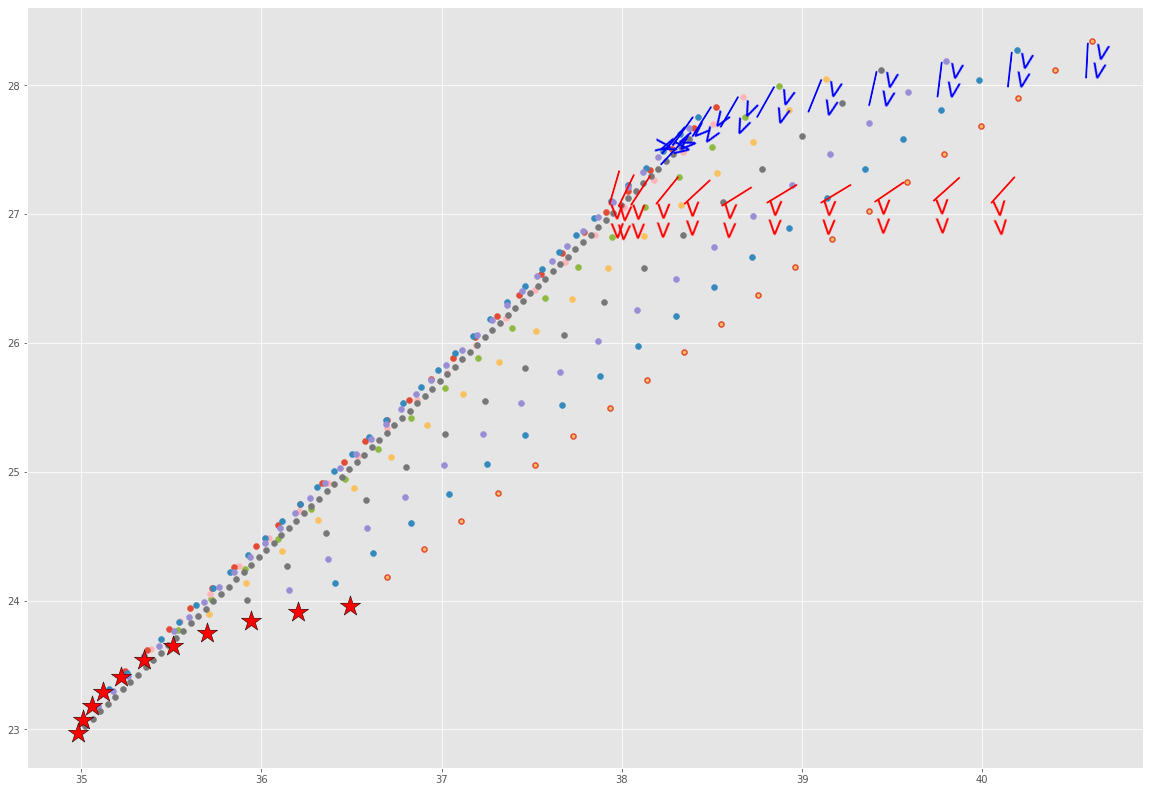

In [ ]:
#Aggregate all positional index data for plotting

def get_tracking_data(nfl_id, game_id, play_id):
  #get tracking_data x,y from frame_metrics table for game_id, play_id, reference1_id, reference2_id
  
  defender_id = defender_for_play(nfl_id, game_id, play_id)
  defender_id = defender_id['reference2_id'][0]
  passer_id = passer_for_play(nfl_id, game_id, play_id)
  passer_id = passer_id['reference1_id'][0]

  player_tracking_for_play = game_frames(nfl_id, defender_id, game_id, play_id)
  qb_tracking_offense = game_frames(passer_id, nfl_id, game_id, play_id)
  qb_tracking_defense = game_frames(passer_id, defender_id, game_id, play_id)

  df_len = len(player_tracking_for_play)
  df_limit = df_len - 5
  if df_len > 40:
      df_len = 40

  block_metrics = player_tracking_for_play[['ref1_role', 'reference1_x', 'reference1_y', 'ref2_role', 'reference2_x', 'reference2_y', 'euclidean']]
  qb_metrics_offense = qb_tracking_offense[['ref1_role', 'reference1_x', 'reference1_y', 'ref2_role', 'reference2_x', 'reference2_y', 'euclidean']]
  qb_metrics_defense = qb_tracking_defense[['ref1_role', 'reference1_x', 'reference1_y', 'ref2_role', 'reference2_x', 'reference2_y', 'euclidean']]
  block_metrics.rename(columns = {'ref1_role':'Blocker', 'reference1_x':'block_x', 'reference1_y':'block_y', 'ref2_role':'Rusher', 'reference2_x':'rush_x', 'reference2_y':'rush_y', 'euclidean':'block_euclidean'}, inplace = True)
  qb_metrics_offense.rename(columns = {'ref1_role':'QB_offense', 'reference1_x':'qb_x', 'reference1_y':'qb_y', 'ref2_role':'QB_Blocker', 'reference2_x':'qb_block_x', 'reference2_y':'qb_block_y', 'euclidean':'qb_blocker_euclidean'}, inplace = True)
  qb_metrics_defense.rename(columns = {'ref1_role':'QB_defense', 'reference1_x':'qb_def_x', 'reference1_y':'qb_def_y', 'ref2_role':'QB_Rusher', 'reference2_x':'qb_rush_x', 'reference2_y':'qb_rush_y', 'euclidean':'qb_rusher_euclidean'}, inplace = True)
  block_metrics = block_metrics[5:df_len-5]
  qb_metrics_offense = qb_metrics_offense[5:df_len-5]
  qb_metrics_defense = qb_metrics_defense[5:df_len-5]

  interface_zone = block_metrics.loc[block_metrics['block_euclidean'] < 1.6667]
  interface_zone_cnt = len(interface_zone)

      
  #get the first and last indexes of interface_frames
  interface_zone_index = interface_zone['block_euclidean'].index #interface_zone is set in Block Metrics Cohesion section
  interface_start = interface_zone_index[0]
  interface_end = len(interface_zone)
  distances = distance_for_interface(nfl_id, game_id, play_id, interface_start, interface_end-1)
      
  metrics_concat = pd.concat([block_metrics, qb_metrics_offense, qb_metrics_defense], axis=1)
  tracking_data = metrics_concat[['QB_offense', 'qb_x', 'qb_y', 'block_x', 'block_y', 'rush_x', 'rush_y', 'block_euclidean', 'qb_blocker_euclidean', 'qb_rusher_euclidean']]
  tracking_data = tracking_data[interface_start - 4:interface_start + interface_end - 1]
  tracking_data = tracking_data
  plot_tracking_data = tracking_data
  coords_list = generate_straight_lines(tracking_data, distances)

  return plot_tracking_data, coords_list, interface_start, defender_id

def plot_outliers():
    #sql = "select * from lines_metrics as lm WHERE lm.score > 1.5"
    sql = "select * from lines_metrics as lm"
    query = pd.read_sql_query(sql, con)
    #with pd.option_context('display.max_rows', None,):
    #    display(query)
    return query






In [ ]:

#get outliers and plot them 
outliers = plot_outliers()
outliers_plays = outliers[['blocker_id', 'gameId', 'playId']]

for g,h in outliers_plays.iterrows():
  if g > 99:
    break
  nfl_id = h['blocker_id']
  blocker_id = nfl_id
  game_id = h['gameId']
  play_id = h['playId']
  print(nfl_id, game_id, play_id)
  
  #testing variables
  #game_id = 2021090900
  #play_id = 97
  #nfl_id = 42377

  plot_tracking_data, coords_list, interface_start, defender_id = get_tracking_data(nfl_id, game_id, play_id)
  #display(plot_tracking_data)
  play_plot = plot_play(plot_tracking_data, coords_list, nfl_id, defender_id, game_id, play_id, interface_start)



In [ ]:
#momentum measure: the ability of the OT to slow down the DE over the length of the play
#add this to block_metrics, get weekx.a for interface range, the lower the a, the higher the score

# **Leaderboard: Rating Offensive Tackles**

In [ ]:
def get_scores(nfl_id):
    sql = "select * from qbi_metrics where blocker_id = "+str(nfl_id)
    qbi = pd.read_sql_query(sql, con)
    sql = "select * from block_metrics where blocker_id = "+str(nfl_id)
    block = pd.read_sql_query(sql, con)
    sql = "select * from lines_metrics where blocker_id = "+str(nfl_id)
    lines = pd.read_sql_query(sql, con)

    #with pd.option_context('display.max_rows', None,):
    #    display(query)
    return qbi,block,lines

def get_combined_tables(nfl_id):
    sql = """
              select * from qbi_metrics as qm, block_metrics as bm, lines_metrics as lm 
              where qm.blocker_id = """ + str(nfl_id) + """ 
              AND bm.blocker_id = """ + str(nfl_id) + """ 
              AND lm.blocker_id = """ + str(nfl_id) + """ 
              AND qm.playId = bm.playId 
              AND bm.playId = lm.playId 
              ORDER by qm.gameId ASC

    """
    rows = pd.read_sql_query(sql, con)
    rows = rows.drop_duplicates(subset=['playId']) 
    #with pd.option_context('display.max_rows', None,):
    #    display(rows)
    
    return rows

def add_data_to_leaderboard(blocker_id, qbi, momentum, efficiency, lines_score, games, plays):
    cursor = con.cursor()
    sql = "INSERT INTO `leaderboard` (`blocker_id`, `qbi`, `momentum`, `efficiency`, `lines_score`, `games`, `plays`) VALUES (" + str(blocker_id) + "," + str(qbi) + "," + str(momentum) + "," + str(efficiency) + "," + str(lines_score) + ", '" + str(games) + "', '" + str(plays) + "')"
    print(sql)
    print()   
    # Execute the query
    cursor.execute(sql)
    # the connection is not autocommited by default. So we must commit to save our changes.
    con.commit()

# df = df.drop_duplicates(subset=['col1', 'col2', ...])    








42377
plays rated:  815 247
qbi:  2.8066801619433197
momentum:  0.5332037158956388
efficiency:  0.8643968667402653
straight line score:  0.20351990749758442
games:  [2021092611, 2021091910, 2021103111, 2021102409, 2021101007, 2021090900, 2021101400, 2021100313]
plays:  [97, 410, 434, 456, 480, 509, 559, 869, 925, 947, 1203, 1227, 1312, 2032, 2419, 2441, 2871, 2915, 3462, 3588, 3633, 3655, 3793, 3933, 3962, 4538, 4560, 4653, 4677, 4728, 4750, 4772, 54, 168, 404, 473, 508, 734, 756, 976, 1025, 1290, 1362, 1384, 1408, 1754, 1799, 1840, 2313, 2335, 2359, 2380, 2885, 3195, 3343, 3365, 3540, 3564, 3871, 3893, 75, 124, 275, 299, 505, 553, 627, 1179, 1255, 1279, 1338, 1438, 1913, 1948, 2011, 2057, 2131, 2404, 2428, 2450, 2479, 2506, 2818, 2842, 2863, 3048, 3094, 3118, 3169, 3627, 3656, 3678, 3728, 3757, 3908, 3932, 3956, 3985, 4009, 4057, 4103, 4165, 4225, 4254, 226, 303, 327, 585, 678, 758, 780, 970, 1036, 1094, 2041, 2070, 2111, 2135, 2159, 2181, 2203, 2379, 2401, 2628, 2948, 2970, 3367, 34

In [ ]:

nflids = get_metric_nflids()
nfl_ids = nflids[['reference1_id']]
nflids_len = len(nfl_ids)

for c,r in nfl_ids.iterrows():
    if c > nflids_len:
      break

    nfl_id = r['reference1_id']
    qbi, block, lines = get_scores(nfl_id)

    if len(qbi) == 0:
      break

    if len(block) == 0:
      break

    if len(lines) == 0:
      break

    if len(qbi) > 10 and len(block) > 10 and len(lines) > 10:
      rows = get_combined_tables(nfl_id)
      avg_qbi_rating = rows['qbi_rating'].mean()
      avg_momentum_rating = rows['momentum_rating'].mean()
      avg_efficiency_rating = rows['efficiency'].mean()
      avg_lines_rating = rows['score'].mean()
      games = []
      plays = []
      for c,r in rows.iterrows():
        games.append(r['gameId'][0])
        plays.append(r['playId'][0])
        
      games = [*set(games)] #remove duplicates from games
      print()
      print(nfl_id)
      print("plays rated: ", len(rows))
      print("qbi: ", avg_qbi_rating)
      print("momentum: ", avg_momentum_rating)
      print("efficiency: ", avg_efficiency_rating)
      print("straight line score: ", avg_lines_rating)
      print("games: ", games)
      print("plays: ", plays)
      print("-------------------------------------------")
      print()
      add_data_to_leaderboard(nfl_id, avg_qbi_rating, avg_momentum_rating, avg_efficiency_rating, avg_lines_rating, games, plays)
    
      if len(rows) == 0:
        break
     


In [ ]:
def qbi_ranking():
  sql = "select ld.rowid, ld.* from leaderboard as ld, players as p WHERE ld.blocker_id = p.nflId ORDER BY ld.qbi DESC"
  query = pd.read_sql_query(sql, con)
  return query

def momentum_ranking():
  sql = "select ld.rowid, ld.* from leaderboard as ld, players as p WHERE ld.blocker_id = p.nflId ORDER BY ld.momentum DESC"
  query = pd.read_sql_query(sql, con)
  #with pd.option_context('display.max_rows', None,):
  #    display(query)
  return query

def efficiency_ranking():
  sql = "select ld.rowid, ld.* from leaderboard as ld, players as p WHERE ld.blocker_id = p.nflId ORDER BY ld.efficiency DESC"
  query = pd.read_sql_query(sql, con)
  return query

def straightlines_ranking():
  sql = "select ld.rowid, ld.* from leaderboard as ld, players as p WHERE ld.blocker_id = p.nflId ORDER BY ld.lines_score DESC"
  query = pd.read_sql_query(sql, con)
  return query

def players_ranking():
  sql = "select ld.blocker_id from leaderboard as ld ORDER BY ld.qbi DESC"
  query = pd.read_sql_query(sql, con)
  return query

def leader_board():
  sql = "select * from leaderboard as ld"
  query = pd.read_sql_query(sql, con)
  #display(query)
  return query

def get_name(nfl_id):
  sql = "select displayName, weight, height from players where nflId = "+str(nfl_id)
  query = pd.read_sql_query(sql, con)
  display(query)
  return query

def get_combine_info(name):
  name = name.replace("'", " ")
  sql = "select * from combine where Name LIKE '%"+name+"%'"
  query = pd.read_sql_query(sql, con)
  display(query)
  return query


#functionalize,lookup by blocker_id get from leaderboard blocker_ids
blocker = players_ranking()
lines = straightlines_ranking()
efficiencies = efficiency_ranking()
momentums = momentum_ranking()
qbis = qbi_ranking()

leader_board()

print()
for c,r in blocker.iterrows():
  player_id = r['blocker_id']
  
  print()
  print("--------------------------------------------------------------------")
  print()
  get_info = get_name(player_id)
  name = get_info['displayName'].values
  for n in name:
    name = n

  name = str(name)
  combine_info = get_combine_info(name)
  print(player_id)
  qbi_ranking = qbis.loc[(qbis['blocker_id'] == player_id)].index.values
  print("QBI: ", qbi_ranking)
  lines_ranking = lines.loc[(lines['blocker_id'] == player_id)].index.values
  #print("lines: ", lines_ranking['rowid'])
  print("lines: ", lines_ranking)
  efficiencies_ranking = efficiencies.loc[(efficiencies['blocker_id'] == player_id)].index.values
  print("efficiency: ", efficiencies_ranking)
  momentum_ranking = momentums.loc[(momentums['blocker_id'] == player_id)].index.values
  print("momentum: ", momentum_ranking)
  print("--------------------------------------------------------------------")
  
  print()
  print()
  print()
  print()









--------------------------------------------------------------------



displayName  weight height
0  Tristan Wirfs     322    6-5

Name Pos School        College   Ht     Wt  40yd  Vertical  Bench  \
0  Tristan Wirfs  OL   Iowa  College Stats  6-5  320.0  4.85      36.5   24.0   

   Broad Jump  3Cone  Shuttle                            Drafted (tm/rnd/yr)  \
0       121.0   7.65     4.68  Tampa Bay Buccaneers / 1st / 13th pick / 2020   

  Player-additional  
0          WirfTr00

52421.0
QBI:  [0]
lines:  [6]
efficiency:  [10]
momentum:  [9]
--------------------------------------------------------------------





--------------------------------------------------------------------



displayName  weight height
0  Riley Reiff     305    6-6

Name Pos School        College   Ht     Wt  40yd  Vertical  Bench  \
0  Riley Reiff  OT   Iowa  College Stats  6-6  313.0  5.16      26.5   23.0   

   Broad Jump  3Cone  Shuttle                     Drafted (tm/rnd/yr)  \
0        98.0   7.87     4.75  Detroit Lions / 1st / 23rd pick / 2012   

  Player-additional  
0          ReifRi00

38553.0
QBI:  [1]
lines:  [9]
efficiency:  [4]
momentum:  [13]
--------------------------------------------------------------------





--------------------------------------------------------------------



displayName  weight height
0  Brian O'Neill     297    6-7

Empty DataFrame
Columns: [Name, Pos, School, College, Ht, Wt, 40yd, Vertical, Bench, Broad Jump, 3Cone, Shuttle, Drafted (tm/rnd/yr), Player-additional]
Index: []

46131.0
QBI:  [2]
lines:  [7]
efficiency:  [17]
momentum:  [20]
--------------------------------------------------------------------





--------------------------------------------------------------------



displayName  weight height
0  Dion Dawkins     320    6-5

Name Pos  School        College   Ht     Wt  40yd  Vertical  Bench  \
0  Dion Dawkins  OG  Temple  College Stats  6-4  314.0  5.11      26.0   26.0   

   Broad Jump  3Cone  Shuttle                     Drafted (tm/rnd/yr)  \
0       106.0    7.3     4.78  Buffalo Bills / 2nd / 63rd pick / 2017   

  Player-additional  
0          DawkDi00

44875.0
QBI:  [3]
lines:  [10]
efficiency:  [18]
momentum:  [7]
--------------------------------------------------------------------





--------------------------------------------------------------------



displayName  weight height
0  George Fant     322    6-5

Empty DataFrame
Columns: [Name, Pos, School, College, Ht, Wt, 40yd, Vertical, Bench, Broad Jump, 3Cone, Shuttle, Drafted (tm/rnd/yr), Player-additional]
Index: []

43586.0
QBI:  [4]
lines:  [17]
efficiency:  [11]
momentum:  [2]
--------------------------------------------------------------------





--------------------------------------------------------------------



displayName  weight height
0  Morgan Moses     330    6-6

Name Pos    School        College   Ht     Wt  40yd  Vertical  \
0  Morgan Moses  OT  Virginia  College Stats  6-6  314.0  5.35      21.5   
1  Morgan Moses  OT  Virginia  College Stats  6-6  314.0  5.35      21.5   

  Bench  Broad Jump  3Cone  Shuttle  \
0  None       106.0   7.93     4.95   
1  None       106.0   7.93     4.95   

                            Drafted (tm/rnd/yr) Player-additional  
0  Washington Redskins / 3rd / 66th pick / 2014          MoseMo00  
1  Washington Redskins / 3rd / 66th pick / 2014          MoseMo00

41295.0
QBI:  [5]
lines:  [3]
efficiency:  [15]
momentum:  [18]
--------------------------------------------------------------------





--------------------------------------------------------------------



displayName  weight height
0  Lane Johnson     317    6-6

Name Pos    School College   Ht     Wt  40yd  Vertical  Bench  \
0  Lane Johnson  OT  Oklahoma    None  6-6  303.0  4.72      34.0   28.0   

   Broad Jump  3Cone  Shuttle                          Drafted (tm/rnd/yr)  \
0       118.0   7.31     4.52  Philadelphia Eagles / 1st / 4th pick / 2013   

  Player-additional  
0          JohnLa01

39950.0
QBI:  [6]
lines:  [18]
efficiency:  [13]
momentum:  [4]
--------------------------------------------------------------------





--------------------------------------------------------------------



displayName  weight height
0  Mekhi Becton     355    6-7

Name Pos      School        College   Ht     Wt  40yd Vertical  \
0  Mekhi Becton  OL  Louisville  College Stats  6-7  364.0   5.1     None   

   Bench Broad Jump 3Cone Shuttle                     Drafted (tm/rnd/yr)  \
0   23.0       None  None    None  New York Jets / 1st / 11th pick / 2020   

  Player-additional  
0          BectMe00

52419.0
QBI:  [7]
lines:  [0]
efficiency:  [20]
momentum:  [14]
--------------------------------------------------------------------





--------------------------------------------------------------------



displayName  weight height
0  Spencer Brown     321    6-9

Empty DataFrame
Columns: [Name, Pos, School, College, Ht, Wt, 40yd, Vertical, Bench, Broad Jump, 3Cone, Shuttle, Drafted (tm/rnd/yr), Player-additional]
Index: []

53522.0
QBI:  [8]
lines:  [8]
efficiency:  [12]
momentum:  [17]
--------------------------------------------------------------------





--------------------------------------------------------------------



displayName  weight height
0  Daryl Williams     330    6-6

Name Pos    School        College   Ht     Wt  40yd  Vertical  \
0  Daryl Williams  OT  Oklahoma  College Stats  6-5  327.0  5.34      26.0   

   Bench  Broad Jump 3Cone  Shuttle  \
0   27.0        97.0  None     5.15   

                           Drafted (tm/rnd/yr) Player-additional  
0  Carolina Panthers / 4th / 102nd pick / 2015          WillDa06

42445.0
QBI:  [9]
lines:  [20]
efficiency:  [8]
momentum:  [19]
--------------------------------------------------------------------





--------------------------------------------------------------------



displayName  weight height
0  Jonah Williams     305    6-4

Name Pos   School        College   Ht     Wt  40yd  Vertical  \
0  Jonah Williams  OT  Alabama  College Stats  6-4  302.0  5.12      28.0   

   Bench  Broad Jump  3Cone  Shuttle  \
0   23.0       100.0   8.01     4.79   

                           Drafted (tm/rnd/yr) Player-additional  
0  Cincinnati Bengals / 1st / 11th pick / 2019          WillJo10

47794.0
QBI:  [10]
lines:  [15]
efficiency:  [6]
momentum:  [1]
--------------------------------------------------------------------





--------------------------------------------------------------------



displayName  weight height
0  Donovan Smith     338    6-6

Name Pos      School        College   Ht     Wt  40yd  Vertical  \
0  Donovan Smith  OT  Penn State  College Stats  6-6  338.0  5.27      32.0   

   Bench  Broad Jump  3Cone  Shuttle  \
0   26.0       109.0   7.95     4.79   

                             Drafted (tm/rnd/yr) Player-additional  
0  Tampa Bay Buccaneers / 2nd / 34th pick / 2015          SmitDo02

42377.0
QBI:  [11]
lines:  [13]
efficiency:  [5]
momentum:  [11]
--------------------------------------------------------------------





--------------------------------------------------------------------



displayName  weight height
0  Jake Matthews     309    6-5

Name Pos     School        College   Ht     Wt  40yd  Vertical  \
0  Jake Matthews  OT  Texas A&M  College Stats  6-5  308.0  5.07      30.5   
1  Jake Matthews  OT  Texas A&M  College Stats  6-5  308.0  5.07      30.5   

   Bench  Broad Jump  3Cone  Shuttle                      Drafted (tm/rnd/yr)  \
0   24.0       105.0   7.34     4.47  Atlanta Falcons / 1st / 6th pick / 2014   
1   24.0       105.0   7.34     4.47  Atlanta Falcons / 1st / 6th pick / 2014   

  Player-additional  
0          MattJa00  
1          MattJa00

41232.0
QBI:  [12]
lines:  [14]
efficiency:  [1]
momentum:  [6]
--------------------------------------------------------------------





--------------------------------------------------------------------



displayName  weight height
0  La'el Collins     320    6-4

Empty DataFrame
Columns: [Name, Pos, School, College, Ht, Wt, 40yd, Vertical, Bench, Broad Jump, 3Cone, Shuttle, Drafted (tm/rnd/yr), Player-additional]
Index: []

42654.0
QBI:  [13]
lines:  [12]
efficiency:  [0]
momentum:  [3]
--------------------------------------------------------------------





--------------------------------------------------------------------



displayName  weight height
0  Kaleb McGary     306    6-6

Name Pos      School        College   Ht     Wt  40yd  Vertical  \
0  Kaleb McGary  OT  Washington  College Stats  6-7  317.0  5.05      33.5   

   Bench  Broad Jump  3Cone  Shuttle  \
0   23.0       111.0   7.66     4.58   

                        Drafted (tm/rnd/yr) Player-additional  
0  Atlanta Falcons / 1st / 31st pick / 2019          McGaKa00

47814.0
QBI:  [14]
lines:  [5]
efficiency:  [7]
momentum:  [16]
--------------------------------------------------------------------





--------------------------------------------------------------------



displayName  weight height
0  Matt Nelson     299    6-7

Empty DataFrame
Columns: [Name, Pos, School, College, Ht, Wt, 40yd, Vertical, Bench, Broad Jump, 3Cone, Shuttle, Drafted (tm/rnd/yr), Player-additional]
Index: []

48455.0
QBI:  [15]
lines:  [2]
efficiency:  [2]
momentum:  [0]
--------------------------------------------------------------------





--------------------------------------------------------------------



displayName  weight height
0  Taylor Moton     325    6-5

Name Pos          School        College   Ht     Wt  40yd  \
0  Taylor Moton  OT  West. Michigan  College Stats  6-5  319.0  5.18   

   Vertical  Bench  Broad Jump  3Cone  Shuttle  \
0      30.5   23.0       109.0   7.73     4.58   

                          Drafted (tm/rnd/yr) Player-additional  
0  Carolina Panthers / 2nd / 64th pick / 2017          MotoTa00

44876.0
QBI:  [16]
lines:  [1]
efficiency:  [3]
momentum:  [10]
--------------------------------------------------------------------





--------------------------------------------------------------------



displayName  weight height
0  Rashod Hill     313    6-6

Empty DataFrame
Columns: [Name, Pos, School, College, Ht, Wt, 40yd, Vertical, Bench, Broad Jump, 3Cone, Shuttle, Drafted (tm/rnd/yr), Player-additional]
Index: []

43640.0
QBI:  [17]
lines:  [16]
efficiency:  [16]
momentum:  [15]
--------------------------------------------------------------------





--------------------------------------------------------------------



displayName  weight height
0  Jordan Mailata     344    6-8

Empty DataFrame
Columns: [Name, Pos, School, College, Ht, Wt, 40yd, Vertical, Bench, Broad Jump, 3Cone, Shuttle, Drafted (tm/rnd/yr), Player-additional]
Index: []

46302.0
QBI:  [18]
lines:  [4]
efficiency:  [19]
momentum:  [5]
--------------------------------------------------------------------





--------------------------------------------------------------------



displayName  weight height
0  Cameron Erving     313    6-5

Name Pos         School        College   Ht     Wt  40yd  \
0  Cameron Erving   C  Florida State  College Stats  6-5  313.0  5.15   

   Vertical  Bench  Broad Jump  3Cone  Shuttle  \
0      30.5   30.0       112.0   7.48     4.63   

                         Drafted (tm/rnd/yr) Player-additional  
0  Cleveland Browns / 1st / 19th pick / 2015          ErviCa00

42362.0
QBI:  [19]
lines:  [11]
efficiency:  [14]
momentum:  [12]
--------------------------------------------------------------------





--------------------------------------------------------------------



displayName  weight height
0  Tyron Smith     320    6-5

Name Pos School        College   Ht     Wt  40yd Vertical  Bench  \
0  Tyron Smith  OT    USC  College Stats  6-5  307.0  4.93     None   29.0   

  Broad Jump 3Cone Shuttle                     Drafted (tm/rnd/yr)  \
0       None  None    None  Dallas Cowboys / 1st / 9th pick / 2011   

  Player-additional  
0          SmitTy00

37082.0
QBI:  [20]
lines:  [19]
efficiency:  [9]
momentum:  [8]
--------------------------------------------------------------------






# **SQLite Admin Tasks**

In [ ]:
#sql = "DELETE FROM qbi_metrics"
sql = "DELETE FROM block_metrics"
#sql = "DELETE FROM lines_metrics"
#sql = "DROP TABLE '456_2021090900'"
#sql = "SELECT * from sqlite_master"
#sql = "SELECT * from frame_metrics ORDER BY rowid desc"
'''
sql = """CREATE TABLE IF NOT EXISTS "lines_metrics" (
"blocker_id" INT NOT NULL,
"defender_id" INT NOT NULL,
"gameId" INT NOT NULL,
"playId" INT NOT NULL,
    "score"  REAL NOT NULL,
    "total_frames" INT NOT NULL,
    "euclideans" varchar(1000),
    "lines_list" varchar(2500)
    )"""

blocker_id, qbi, momentum, efficiency, lines_score, games, plays

sql = """CREATE TABLE IF NOT EXISTS "leaderboard" (
"blocker_id"   REAL NOT NULL,
"qbi"   REAL NOT NULL,
"momentum"   REAL NOT NULL,
"efficiency"   REAL NOT NULL,
    "lines_score"  REAL NOT NULL,
    "games" varchar(1000),
    "plays" varchar(2500)
    )"""

'''
# blocker_id, defender_id, game_id, play_id, score, total_frames, euclideans, lines_list
#sql = "DROP TABLE 'week8'"
'''
sql = """CREATE TABLE IF NOT EXISTS "leaderboard" (
"blocker_id"   REAL NOT NULL,
"qbi"   REAL NOT NULL,
"momentum"   REAL NOT NULL,
"efficiency"   REAL NOT NULL,
    "lines_score"  REAL NOT NULL,
    "games" varchar(1000),
    "plays" varchar(2500)
    )"""
'''
#sql = "ALTER TABLE block_metrics ADD COLUMN qb_de_eucl_avg REAL"
#sql = "ALTER TABLE block_metrics ADD COLUMN qb_de_rating INT"
cursor = con.cursor()
# Execute the query
cursor.execute(sql)
# the connection is not autocommited by default. So we must commit to save our changes.
con.commit()

#con = sqlite3.connect(data_dir + "original_databowl.db")
#rows = pd.read_sql_query(sql, con)
#rows.tail(10)
